In [ ]:
using 
CSV,
Dates,
DataFrames,
Markdown,
Plots,
Statistics,
StatsPlots
gr()
;

In [2]:
death_path = "COVID-19/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_global.csv"
confirmed_path = "COVID-19/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv"
;

In [3]:
death = CSV.read(death_path) |> DataFrame! |> x -> rename!(x, Dict(Symbol("Province/State") => :state, Symbol("Country/Region") => :country))
confirmed = CSV.read(confirmed_path) |> DataFrame! |> x -> rename!(x, Dict(Symbol("Province/State") => :state, Symbol("Country/Region") => :country))
;

In [4]:
"""
    convert an array of columns and column names into a markdown table

    parameters: 
        cols : Array[Array[Any]] | DataFrame
            an array of arrays which are the columns of the table
        names : Array[String]
            an array of column names. If inputting a df, input `string.(names(df))`
        df : Boolean
            whether or not the cols are an array of arrays or a dataframe

    returns: String
        string of markdown text
"""
function markdown_table(cols, names; df=false)
    if df
        cols = [col for col in eachcol(cols)]
    end
    output_string = ""
    cols = [repr.(col) for col in cols]
    for i in 1:length(names)
        output_string = output_string * "|" * names[i]
    end
    output_string *= "\n"
    for i in 1:length(names)
        output_string = output_string * "|" * "---"
    end
    output_string *= "\n"
    for row in 1:length(cols[1])
        for col in 1:length(cols)
            output_string = output_string * "|" * cols[col][row]
        end
        output_string *= "\n"
    end
    # displaying strings without quotes
    output_string =  replace(output_string, "\"" => "")

    return output_string
end
;

In [5]:
function country_data(country; state=false, start_date=Dates.Date(2020, 1, 22), end_date="max")
    aggregate(x) = [sum(col) for col in eachcol(x)]
    
    state_mask = typeof(state) == String ? death.state .== state : true
    d = death[(death.country .== country) .& state_mask, 5:end] |> aggregate
    dates = [Dates.Date(2020, 1, 22) + Dates.Day(day) for day in 1:length(d)] |> x -> reshape(x, :, 1)
    state_mask = typeof(state) == String ? confirmed.state .== state : true
    c = confirmed[(confirmed.country .== country) .& state_mask, 5:end] |> aggregate
    
    df = convert(DataFrame, dates) |> x -> rename!(x, [:date])
    country_name = typeof(state) == String ? country * "-" * state : country
    df[!, :country] .= country_name
    df[!, :confirmed] = c
    df[!, :deaths] = d
    df[!, :death_rate] = d ./ c
    df[!, :new_cases] .= 0
    df[2:end, :new_cases] = df[2:end, :confirmed] .- df[1:end-1, :confirmed]
    df[!, :new_deaths] .= 0
    df[2:end, :new_deaths] = df[2:end, :deaths] .- df[1:end-1, :deaths]
    df[!, :acceleration_cases] .= 0
    df[2:end, :acceleration_cases] = df[2:end, :new_cases] .- df[1:end-1, :new_cases]
    df[!, :acceleration_deaths] .= 0
    df[2:end, :acceleration_deaths] = df[2:end, :new_deaths] .- df[1:end-1, :new_deaths]
    df[!, :days_since_100] .= 0
    counter = 0
    for row in eachrow(df)
        if row.confirmed > 100
            counter += 1
        end
        row.days_since_100 = counter
    end
    df[!, :days_since_10] .= 0
    counter = 0
    for row in eachrow(df)
        if row.deaths > 10
            counter += 1
        end
        row.days_since_10 = counter
    end
    
    if end_date == "max"
        end_date = maximum(df.date)
    end
    return df[(df.date .>= start_date) .& (df.date .<= end_date), :]
end
;

In [6]:
function plot_country(country; state=false, metric=:confirmed, start_date=Dates.Date(2020, 1, 22), end_date="max", days_since_100=false)
    data = country_data(country; state=state, start_date=start_date, end_date=end_date)
    if days_since_100
        if metric == :confirmed
            plot(data[data.days_since_100 .> 0, :days_since_100], data[data.days_since_100 .> 0, metric], label=country, legend=:outertopright, size=(1000, 500))
        else
            plot(data[data.days_since_10 .> 0, :days_since_10], data[data.days_since_10 .> 0, metric], label=country, legend=:outertopright, size=(1000, 500))
        end
    else
        plot(data.date, data[!, metric], label=country, legend=:outertopright, size=(1000, 500))
    end
    
    plot!([0], linetype=:hline, color=:black, label="")
    plot!(yformatter=:plain)
end
function plot_country!(country; state=false, metric=:confirmed, start_date=Dates.Date(2020, 1, 22), end_date="max", days_since_100=false)
    data = country_data(country; state=state, start_date=start_date, end_date=end_date)
    if days_since_100
        if metric == :confirmed
            plot!(data[data.days_since_100 .> 0, :days_since_100], data[data.days_since_100 .> 0, metric], label=country, legend=:outertopright, size=(1000, 500))
        else
            plot!(data[data.days_since_10 .> 0, :days_since_10], data[data.days_since_10 .> 0, metric], label=country, legend=:outertopright, size=(1000, 500))
        end
    else
        plot!(data.date, data[!, metric], label=country, legend=:outertopright, size=(1000, 500))
    end
    plot!(yformatter=:plain)
end
bar_plot(country, metric) = bar(
    all_country_data[
        (all_country_data.country .== country) .& (all_country_data.date .>= Dates.Date(2020, 1, 1)),
        :date
    ], 
    all_country_data[
        (all_country_data.country .== country) .& (all_country_data.date .>= Dates.Date(2020, 1, 1)),
        metric
    ], 
    legend=false, 
    linecolor=1, 
    title=country,
    yformatter=:plain
)
function accel_plot(country_name="World")
    if country_name == "World"
        tmp = all_country_data
    else
        tmp = all_country_data[all_country_data.country .== country_name, :]
    end
    agg = by(tmp, [:date], :confirmed => sum, :deaths => sum)
    conf = plot(agg.date, agg.confirmed_sum, legend=false, title="$country_name Confirmed Cases", size=(1400, 700), color=:grey, yformatter=:plain)
    death_plot = plot(agg.date, agg.deaths_sum, legend=false, title="$country_name Deaths", size=(1400, 700), color=:orange, yformatter=:plain)

    # derivates
    agg[!, :new_cases] .= 0
    agg[!, :new_cases][2:end] = agg.confirmed_sum[2:end] - agg.confirmed_sum[1:end-1]
    agg[!, :new_deaths] .= 0
    agg[!, :new_deaths][2:end] = agg.deaths_sum[2:end] - agg.deaths_sum[1:end-1]
    agg[!, :conf_acceleration] .= 0
    agg[!, :conf_acceleration][2:end] = agg.new_cases[2:end] - agg.new_cases[1:end-1]
    agg[!, :death_acceleration] .= 0
    agg[!, :death_acceleration][2:end] = agg.new_deaths[2:end] - agg.new_deaths[1:end-1]

    # moving average
    moving_average(vs,n) = [sum(@view vs[i:(i+n-1)])/n for i in 1:(length(vs)-(n-1))]
    n_days = 3
    ma_date = agg.date[1 + n_days-1:end]
    conf_slope = moving_average(agg.new_cases, n_days)
    death_slope = moving_average(agg.new_deaths, n_days)
    conf_acc = moving_average(agg.conf_acceleration, n_days)
    death_acc = moving_average(agg.death_acceleration, n_days)

    p_conf_slope = plot(ma_date, conf_slope, legend=false, title="$country_name 1st Derivative (new cases)", size=(1400, 700), color=:grey)
    plot!([0], linetype=:hline, color=:black, label="", yformatter=:plain)

    p_death_slope = plot(ma_date, death_slope, legend=false, title="$country_name 1st Derivative (new deaths)", size=(1400, 700), color=:orange)
    plot!([0], linetype=:hline, color=:black, label="", yformatter=:plain)

    p_conf_acc = plot(ma_date, conf_acc, legend=false, title="$country_name 2nd Derivative (cases acceleration)", size=(1400, 700), color=:grey)
    plot!([0], linetype=:hline, color=:black, label="", yformatter=:plain)

    p_death_acc = plot(ma_date, death_acc, legend=false, title="$country_name 2nd Derivative (deaths acceleration)", size=(1400, 700), color=:orange)
    plot!([0], linetype=:hline, color=:black, label="", yformatter=:plain)

    plot(conf, death_plot, p_conf_slope, p_death_slope, p_conf_acc, p_death_acc, layout=(3,2))
end
;

In [7]:
all_countries = death.country |> unique |> sort
all_country_data = vcat([country_data(country) for country in all_countries]...)
current_state = by(all_country_data, [:country], :confirmed => maximum, :deaths => maximum)
current_state[!, :death_rate] = current_state.deaths_maximum ./ current_state.confirmed_maximum
;

In [8]:
Markdown.parse("""
    # Overview of COVID-19 as of $(maximum(all_country_data.date))
    This page uses data from https://github.com/CSSEGISandData/COVID-19 (Johns Hopkins CSSE is the original source) to create a report on the status of COVID-19 cases and deaths around the world. It is updated once a day around 10:00am CET.
    """)

# Overview of COVID-19 as of 2020-03-29

This page uses data from https://github.com/CSSEGISandData/COVID-19 (Johns Hopkins CSSE is the original source) to create a report on the status of COVID-19 cases and deaths around the world. It is updated once a day around 10:00am CET.


## Worldwide Current State

In [9]:
tmp = current_state
Markdown.parse("""
- Confirmed cases: $(sum(tmp.confirmed_maximum))
- Deaths: $(sum(tmp.deaths_maximum))
- Death Rate: $(round(sum(tmp.deaths_maximum) / sum(tmp.confirmed_maximum) * 100, digits=2))%
""")

  * Confirmed cases: 660718
  * Deaths: 30658
  * Death Rate: 4.64%


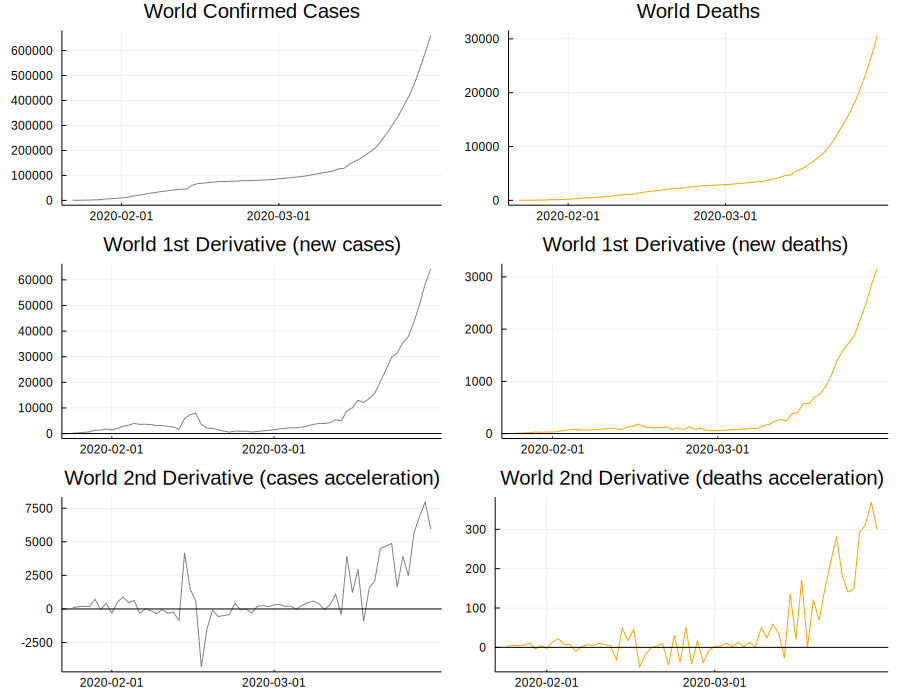

In [10]:
accel_plot("World")
plot!(size=(900, 700))

## Top 10 Worst Affected Countries
### Confirmed

In [11]:
top_10 = sort(current_state, order(:confirmed_maximum, rev=true))[1:10, :]
top_10[!, :death_rate] = string.(round.(top_10.death_rate * 100, digits=2)) .* "%"
Markdown.parse(
    markdown_table(top_10, ["Country", "Confirmed Cases", "Deaths", "Death Rate"]; df=true)
)

|        Country | Confirmed Cases | Deaths | Death Rate |
| --------------:| ---------------:| ------:| ----------:|
|             US |          140886 |   2467 |      1.75% |
|          Italy |           97689 |  10779 |     11.03% |
|          China |           82122 |   3304 |      4.02% |
|          Spain |           80110 |   6803 |      8.49% |
|        Germany |           62095 |    533 |      0.86% |
|         France |           40708 |   2611 |      6.41% |
|           Iran |           38309 |   2640 |      6.89% |
| United Kingdom |           19780 |   1231 |      6.22% |
|    Switzerland |           14829 |    300 |      2.02% |
|    Netherlands |           10930 |    772 |      7.06% |


# Acceleration (>1000 cases now)
The `Acceleration of Last 5 Days` column is calculated by the average second derivative over the last 5 days / number of cases 5 days ago. It doesn't have much intrinsic meaning but is rather a more comparable/relative measure between countries of how fast new cases are accelerating.

In [12]:
countries = unique(all_country_data.country)
acceleration = []
cases_5_ago = []
cases_now = []
for country in countries
    metric = mean(all_country_data[all_country_data.country .== country, :acceleration_cases][end-4:end])
    metric /= all_country_data[all_country_data.country .== country, :confirmed][end-4]
    if isnan(metric)
        metric = 0
    end
    push!(acceleration, metric)
    push!(cases_5_ago, all_country_data[all_country_data.country .== country, :confirmed][end-4])
    push!(cases_now, all_country_data[all_country_data.country .== country, :confirmed][end])
end
last_5 = rename!(DataFrame([countries, acceleration, cases_now, cases_5_ago]), [:country, :last_5_accel, :cases_now, :cases_5_ago])
last_5[!, :perc_increase] = last_5.cases_now ./ last_5.cases_5_ago .- 1
tmp = sort(last_5[(last_5.cases_5_ago .> 20) .& (last_5.cases_now .> 1000), :], order(:last_5_accel, rev=true))
tmp[!, :perc_increase] = string.(round.(tmp.perc_increase .* 100, digits=2)) .* "%"
rename!(tmp, [:Country, Symbol("Acceleration of Last 5 Days"), Symbol("Cases Now"), Symbol("Cases 5 Days Ago"), Symbol("% Increase in 5 Days")])
tmp[!, Symbol("Acceleration of Last 5 Days")] = string.(round.(tmp[!, Symbol("Acceleration of Last 5 Days")] * 100, digits=2)) .* "%"

Markdown.parse(
    markdown_table(tmp, string.(names(tmp)), df=true)
)

|        Country | Acceleration of Last 5 Days | Cases Now | Cases 5 Days Ago | % Increase in 5 Days |
| --------------:| ---------------------------:| ---------:| ----------------:| --------------------:|
|         Turkey |                       12.1% |      9217 |             2433 |              278.83% |
|    Philippines |                       7.96% |      1418 |              636 |              122.96% |
|         Russia |                       6.47% |      1534 |              658 |              133.13% |
|        Belgium |                       4.76% |     10836 |             4937 |              119.49% |
|         Israel |                       3.89% |      4247 |             2369 |               79.27% |
|       Portugal |                       3.27% |      5962 |             2995 |               99.07% |
|        Romania |                        3.2% |      1815 |              906 |              100.33% |
|             US |                       2.89% |    140886 |            65778 |              114.18% |
| United Kingdom |                       2.14% |     19780 |             9640 |              105.19% |
|          Japan |                       1.65% |      1866 |             1307 |               42.77% |
|         Poland |                       1.37% |      1862 |             1051 |               77.16% |
|         Greece |                       1.14% |      1156 |              821 |                40.8% |
|          Chile |                       0.95% |      2139 |             1142 |                87.3% |
|    Netherlands |                       0.92% |     10930 |             6438 |               69.77% |
|          Spain |                       0.86% |     80110 |            49515 |               61.79% |
|           Iran |                       0.84% |     38309 |            27017 |                41.8% |
|       Thailand |                       0.79% |      1388 |              934 |               48.61% |
|      Indonesia |                       0.58% |      1285 |              790 |               62.66% |
|        Denmark |                       0.56% |      2564 |             1862 |                37.7% |
|       Malaysia |                       0.49% |      2470 |             1796 |               37.53% |
|        Czechia |                       0.34% |      2817 |             1654 |               70.31% |
|        Germany |                       0.25% |     62095 |            37323 |               66.37% |
|         Brazil |                       0.23% |      4256 |             2554 |               66.64% |
|         Norway |                       0.18% |      4284 |             3084 |               38.91% |
|         Sweden |                        0.1% |      3700 |             2526 |               46.48% |
|       Pakistan |                       0.09% |      1597 |             1063 |               50.24% |
|         France |                       0.08% |     40708 |            25600 |               59.02% |
|   Korea, South |                       0.06% |      9583 |             9137 |                4.88% |
|         Canada |                       0.01% |      6280 |             3251 |               93.17% |
|          China |                       0.01% |     82122 |            81661 |                0.56% |
|        Ecuador |                        0.0% |      1924 |             1173 |               64.02% |
|          India |                        0.0% |      1024 |              657 |               55.86% |
|          Italy |                      -0.01% |     97689 |            74386 |               31.33% |
|        Ireland |                      -0.05% |      2615 |             1564 |                67.2% |
|        Iceland |                      -0.08% |      1020 |              737 |                38.4% |
|      Australia |                      -0.15% |      3984 |             2364 |               68.53% |
|        Finland |                      -0.43% |      1240 |              880 |               40.91% |
|    Switzerland |                       -0.6% |     14829 |            10897 |               36.08% |
|        Austria |                      -1.05% |      8788 |             5588 |               57.27% |
|     Luxembourg |                      -1.58% |      1950 |             1333 |               46.29% |
|   South Africa |                      -1.66% |      1280 |              709 |               80.54% |
|   Saudi Arabia |                      -2.42% |      1299 |              900 |               44.33% |


In [13]:
function individual_country(country; comparison_country="Italy")
    # line plots
    cases_100 = plot_country(country, days_since_100=true, metric=:confirmed)
    plot_country!(comparison_country, days_since_100=true, metric=:confirmed)
    plot!(title="$country Days Since 100th Case", titlefont=font(10))
    deaths_10 = plot_country(country, days_since_100=true, metric=:deaths)
    plot_country!(comparison_country, days_since_100=true, metric=:deaths)
    plot!(title="$country Days Since 10th Death", titlefont=font(10))
    line_plots = plot(cases_100, deaths_10, layout=(2,1))
    
    #accel plots
    accel_plots = accel_plot(country)
    plot!(titlefont=font(10))
    
    # bar plots
    cases_bar = bar_plot(country, :new_cases)
    plot!(title="$country New Cases Per Day", titlefont=font(10))
    deaths_bar = bar_plot(country, :new_deaths)
    plot!(title="$country Deaths Per Day", titlefont=font(10))
    bar_plots = plot(cases_bar, deaths_bar, layout=(2,1))
    
    final_plot = plot(accel_plots, line_plots, bar_plots, layout=(3, 1))
    plot!(size=(900, 1400))
    return final_plot
end
;

# Countries
Days since 100th case and 10th death plotted with Italy for comparison. Only countries with >= 500 confirmed cases show graphs. Derivative plots are 3 days moving average.

## Afghanistan


  * Confirmed cases: 120
  * Deaths: 4
  * Death Rate: 3.33%


## Albania


  * Confirmed cases: 212
  * Deaths: 10
  * Death Rate: 4.72%


## Algeria


  * Confirmed cases: 511
  * Deaths: 31
  * Death Rate: 6.07%


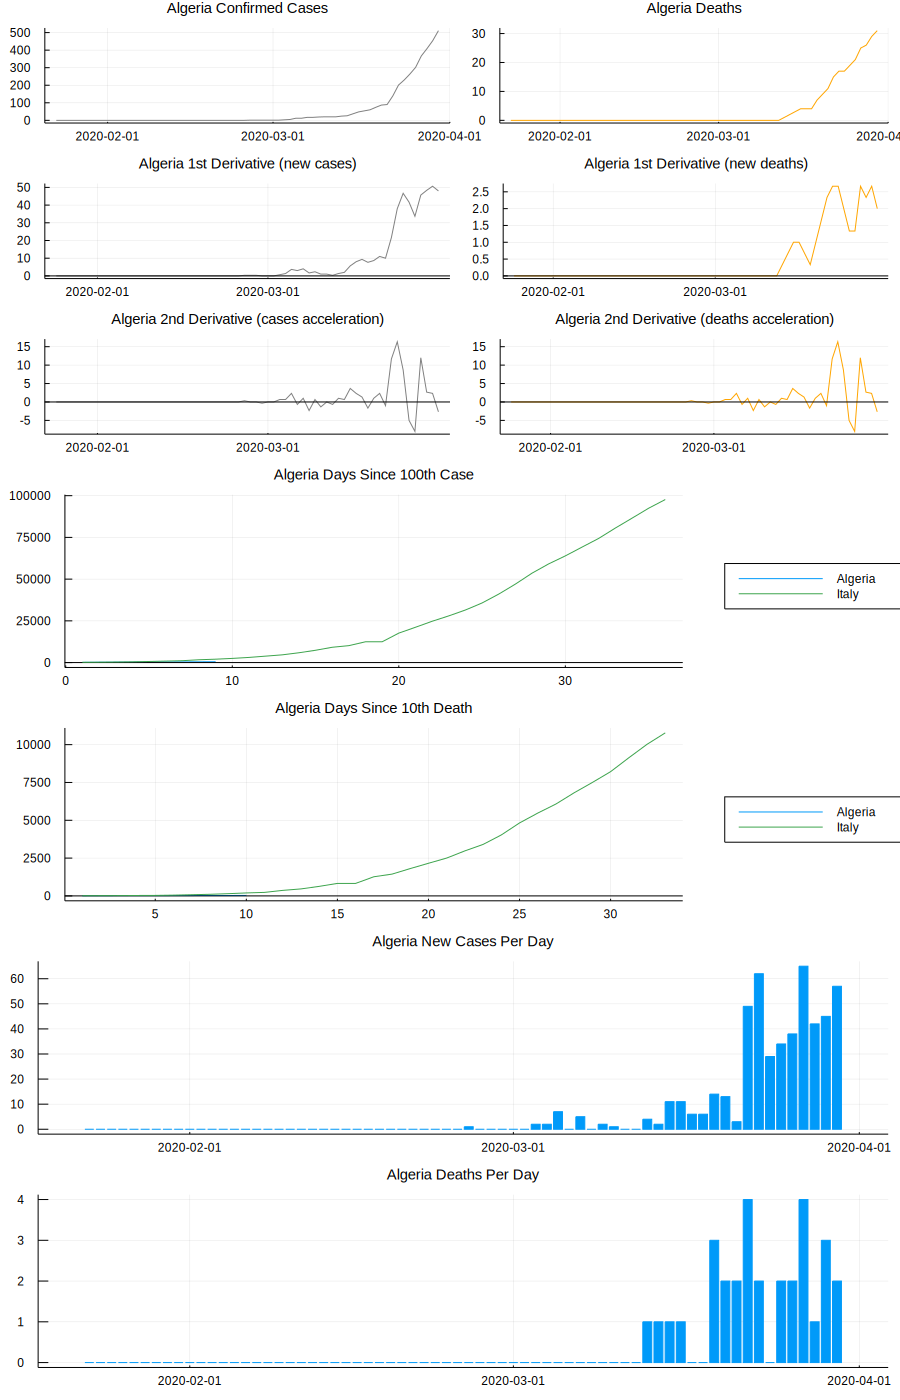

## Andorra


  * Confirmed cases: 334
  * Deaths: 6
  * Death Rate: 1.8%


## Angola


  * Confirmed cases: 7
  * Deaths: 2
  * Death Rate: 28.57%


## Antigua and Barbuda


  * Confirmed cases: 7
  * Deaths: 0
  * Death Rate: 0.0%


## Argentina


  * Confirmed cases: 745
  * Deaths: 19
  * Death Rate: 2.55%


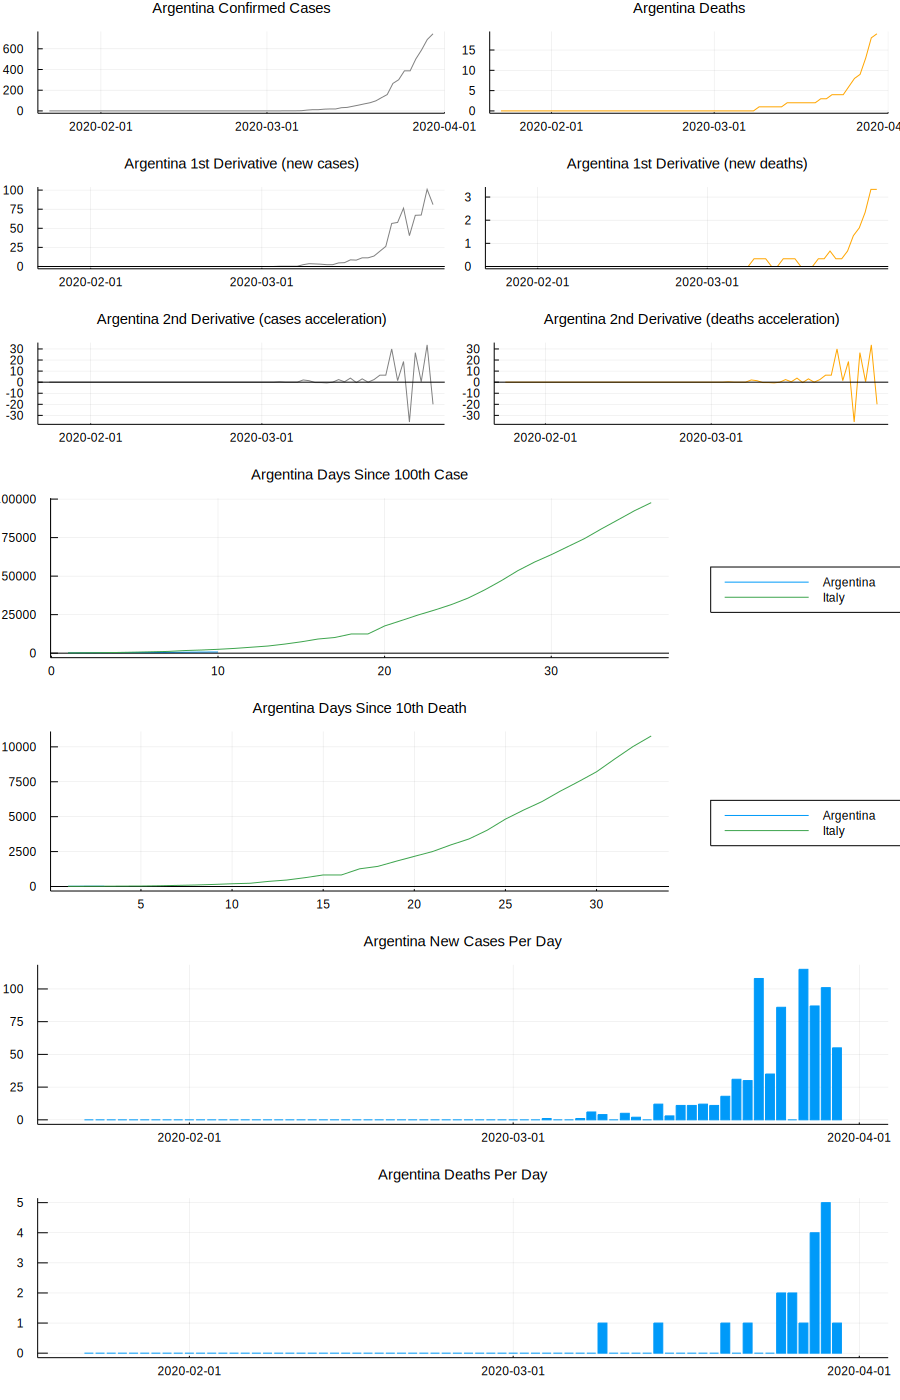

## Armenia


  * Confirmed cases: 424
  * Deaths: 3
  * Death Rate: 0.71%


## Australia


  * Confirmed cases: 3984
  * Deaths: 16
  * Death Rate: 0.4%


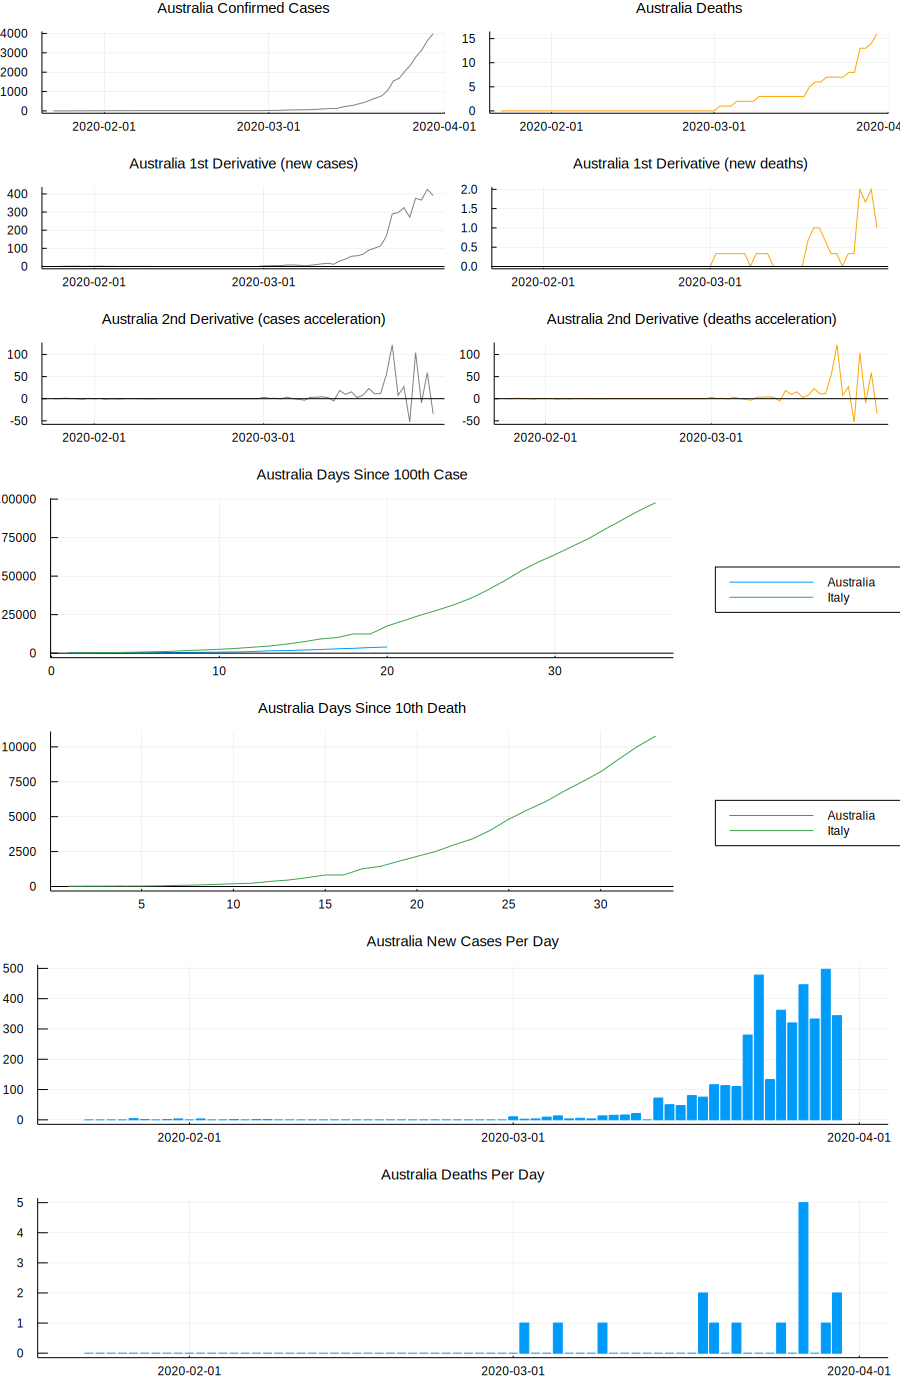

## Austria


  * Confirmed cases: 8788
  * Deaths: 86
  * Death Rate: 0.98%


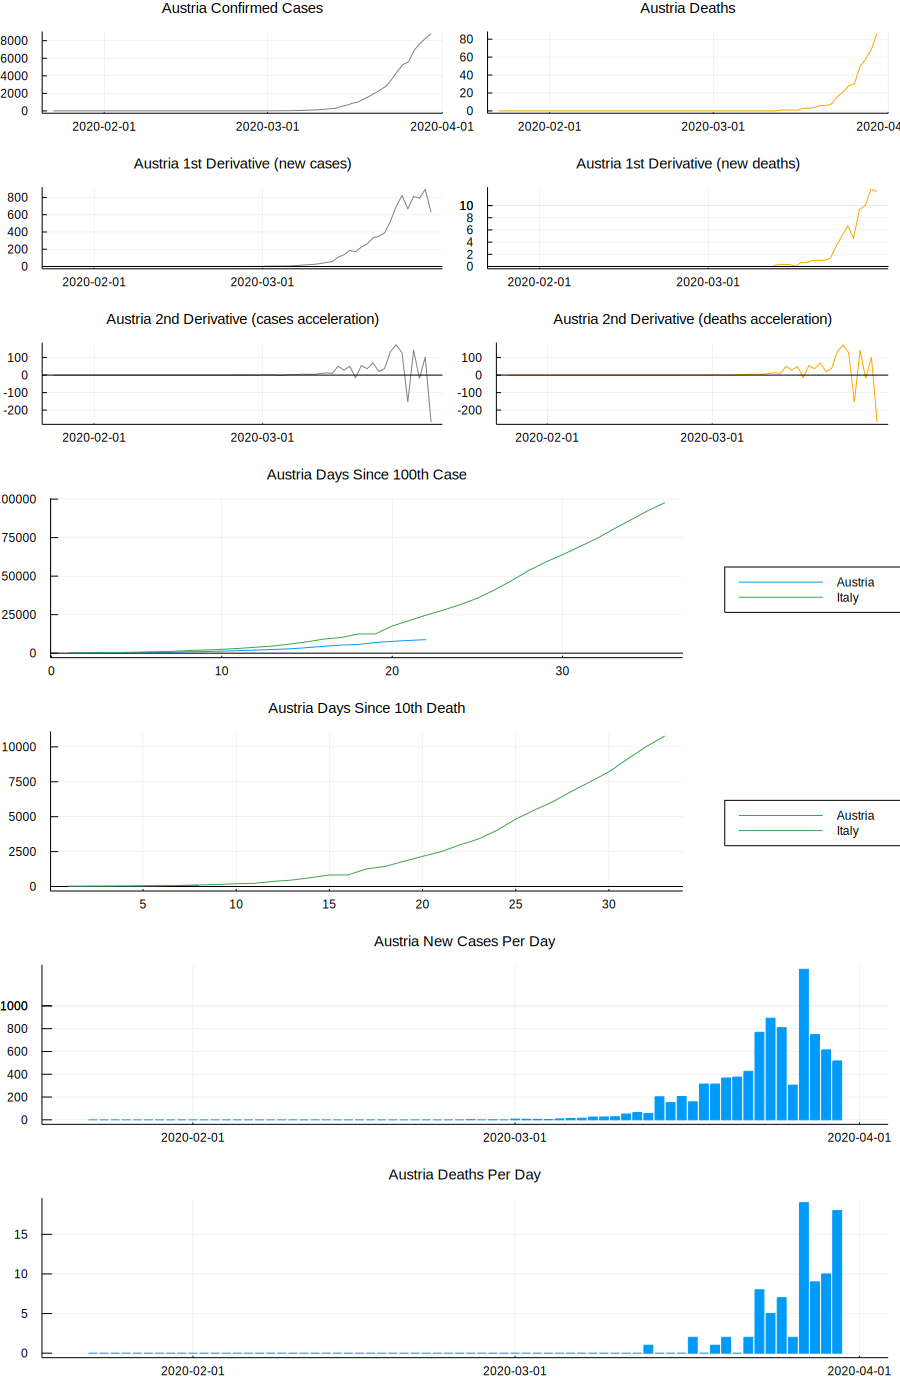

## Azerbaijan


  * Confirmed cases: 209
  * Deaths: 4
  * Death Rate: 1.91%


## Bahamas


  * Confirmed cases: 11
  * Deaths: 0
  * Death Rate: 0.0%


## Bahrain


  * Confirmed cases: 499
  * Deaths: 4
  * Death Rate: 0.8%


## Bangladesh


  * Confirmed cases: 48
  * Deaths: 5
  * Death Rate: 10.42%


## Barbados


  * Confirmed cases: 33
  * Deaths: 0
  * Death Rate: 0.0%


## Belarus


  * Confirmed cases: 94
  * Deaths: 0
  * Death Rate: 0.0%


## Belgium


  * Confirmed cases: 10836
  * Deaths: 431
  * Death Rate: 3.98%


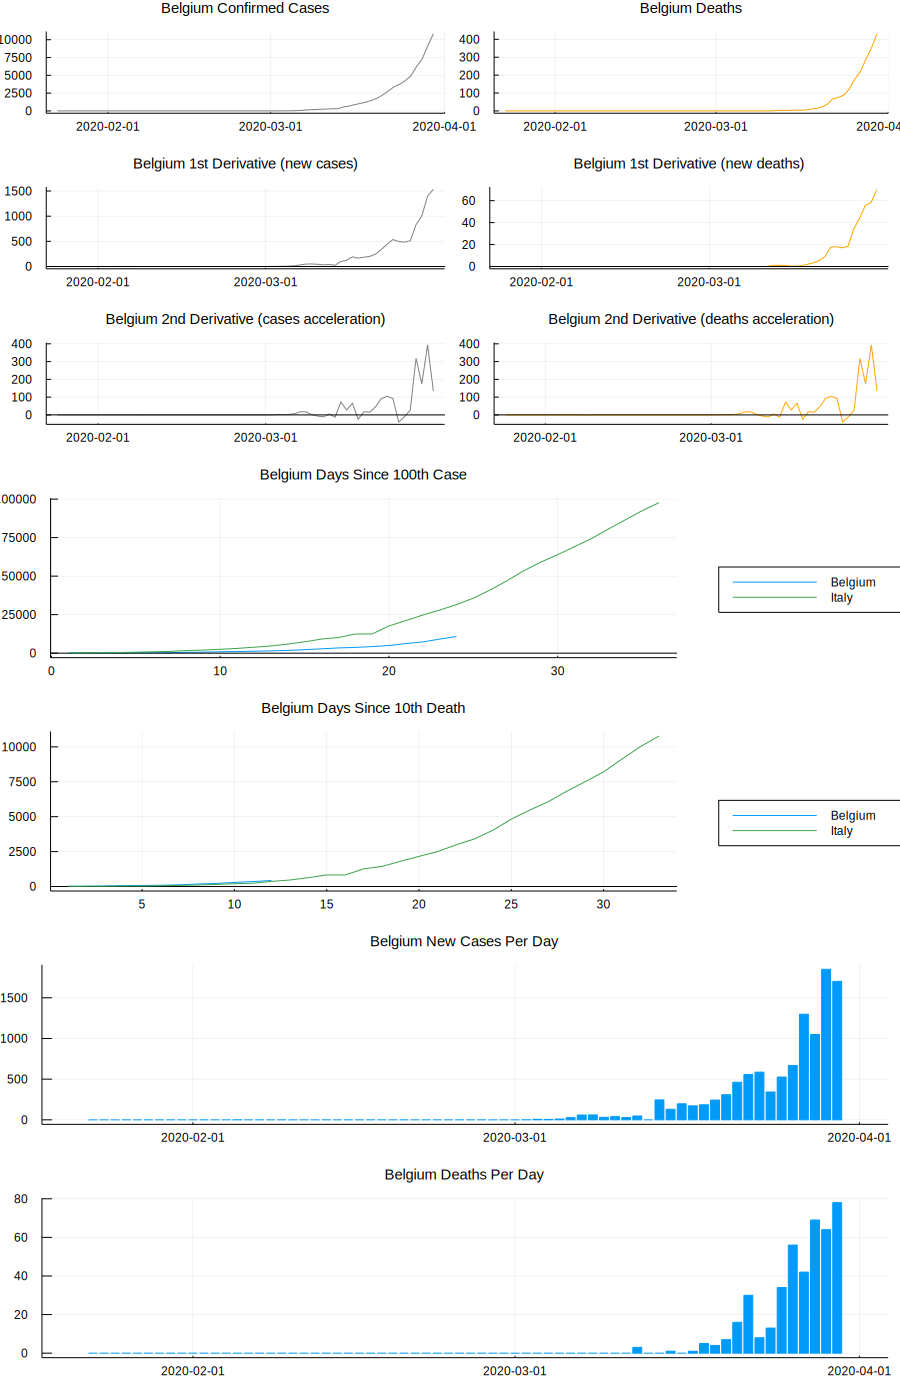

## Belize


  * Confirmed cases: 2
  * Deaths: 0
  * Death Rate: 0.0%


## Benin


  * Confirmed cases: 6
  * Deaths: 0
  * Death Rate: 0.0%


## Bhutan


  * Confirmed cases: 4
  * Deaths: 0
  * Death Rate: 0.0%


## Bolivia


  * Confirmed cases: 81
  * Deaths: 1
  * Death Rate: 1.23%


## Bosnia and Herzegovina


  * Confirmed cases: 323
  * Deaths: 6
  * Death Rate: 1.86%


## Brazil


  * Confirmed cases: 4256
  * Deaths: 136
  * Death Rate: 3.2%


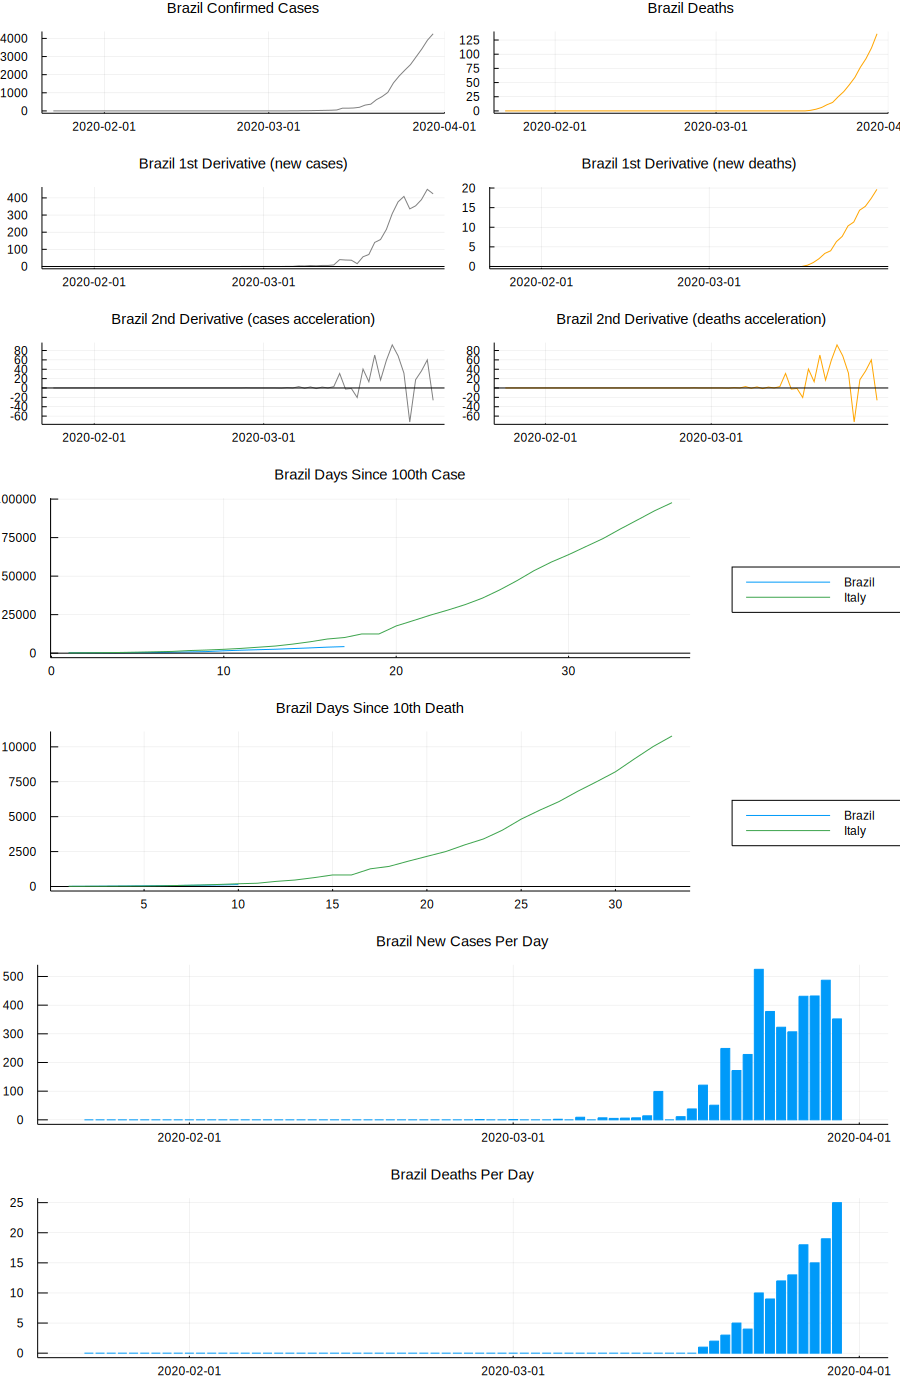

## Brunei


  * Confirmed cases: 126
  * Deaths: 1
  * Death Rate: 0.79%


## Bulgaria


  * Confirmed cases: 346
  * Deaths: 8
  * Death Rate: 2.31%


## Burkina Faso


  * Confirmed cases: 222
  * Deaths: 12
  * Death Rate: 5.41%


## Burma


  * Confirmed cases: 10
  * Deaths: 0
  * Death Rate: 0.0%


## Cabo Verde


  * Confirmed cases: 6
  * Deaths: 1
  * Death Rate: 16.67%


## Cambodia


  * Confirmed cases: 103
  * Deaths: 0
  * Death Rate: 0.0%


## Cameroon


  * Confirmed cases: 139
  * Deaths: 6
  * Death Rate: 4.32%


## Canada


  * Confirmed cases: 6280
  * Deaths: 64
  * Death Rate: 1.02%


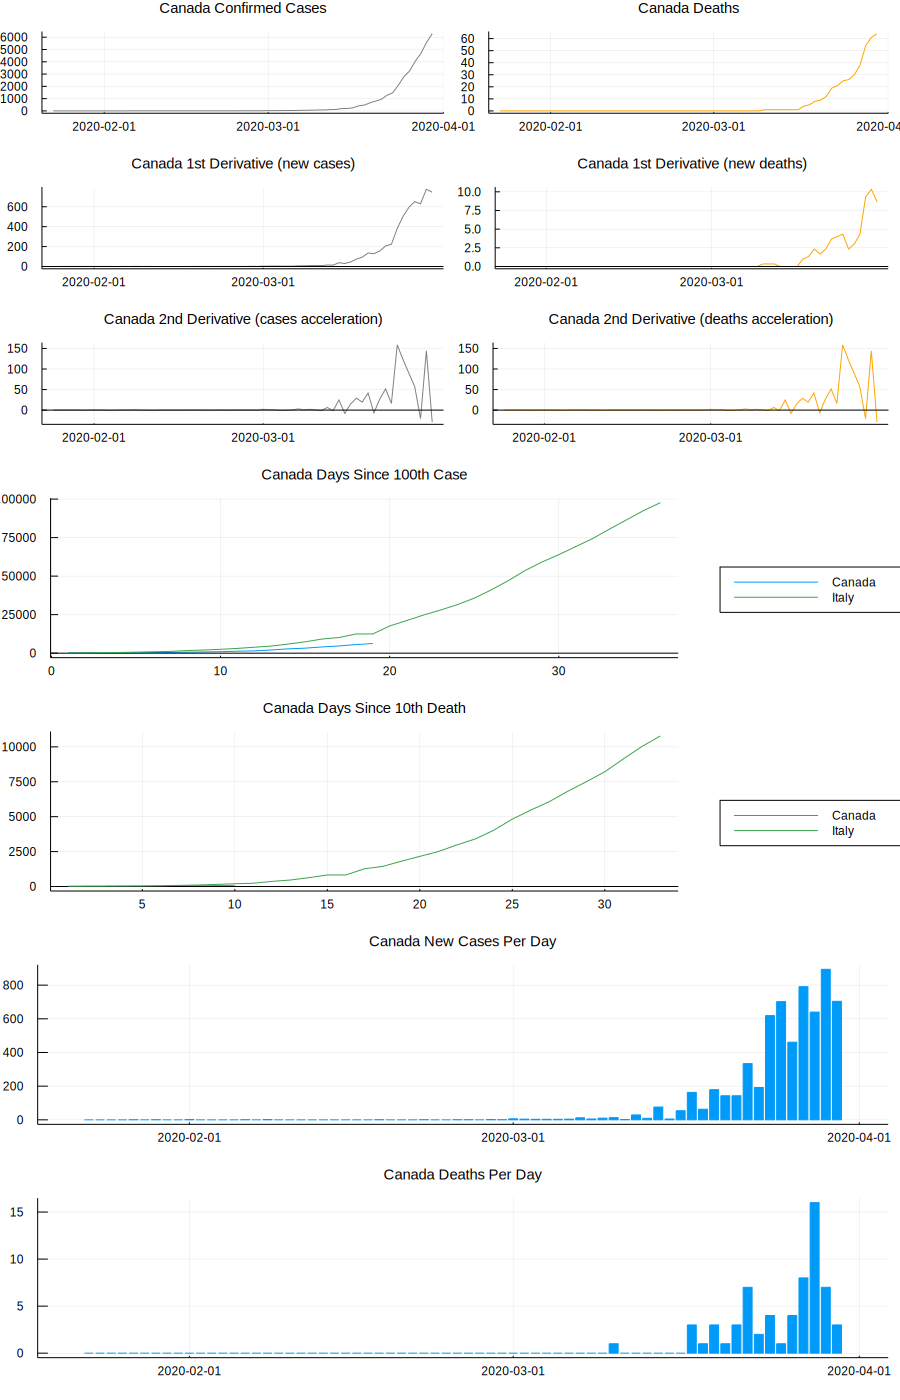

## Central African Republic


  * Confirmed cases: 3
  * Deaths: 0
  * Death Rate: 0.0%


## Chad


  * Confirmed cases: 3
  * Deaths: 0
  * Death Rate: 0.0%


## Chile


  * Confirmed cases: 2139
  * Deaths: 7
  * Death Rate: 0.33%


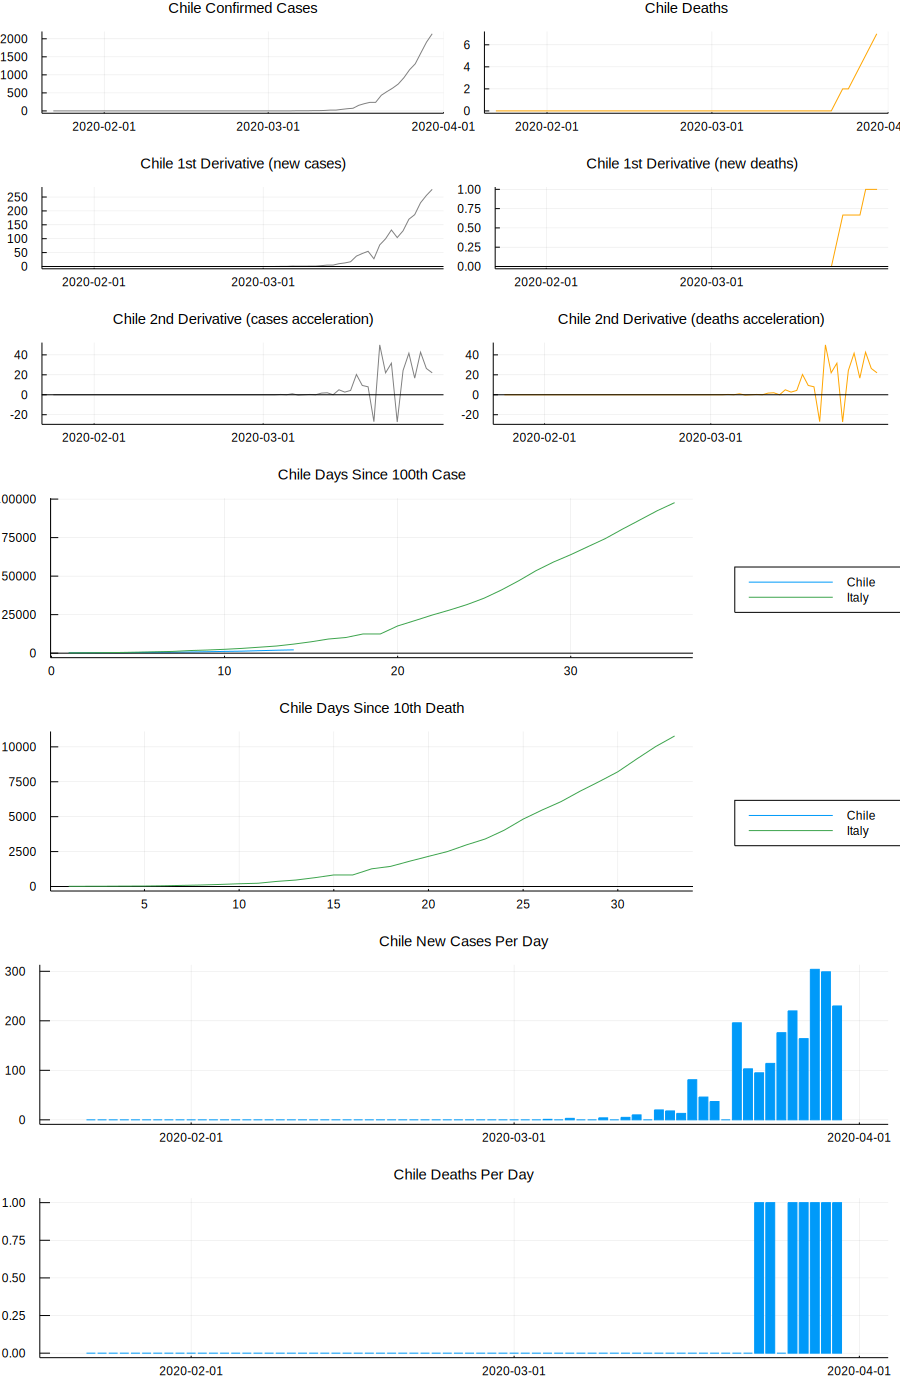

## China


  * Confirmed cases: 82122
  * Deaths: 3304
  * Death Rate: 4.02%


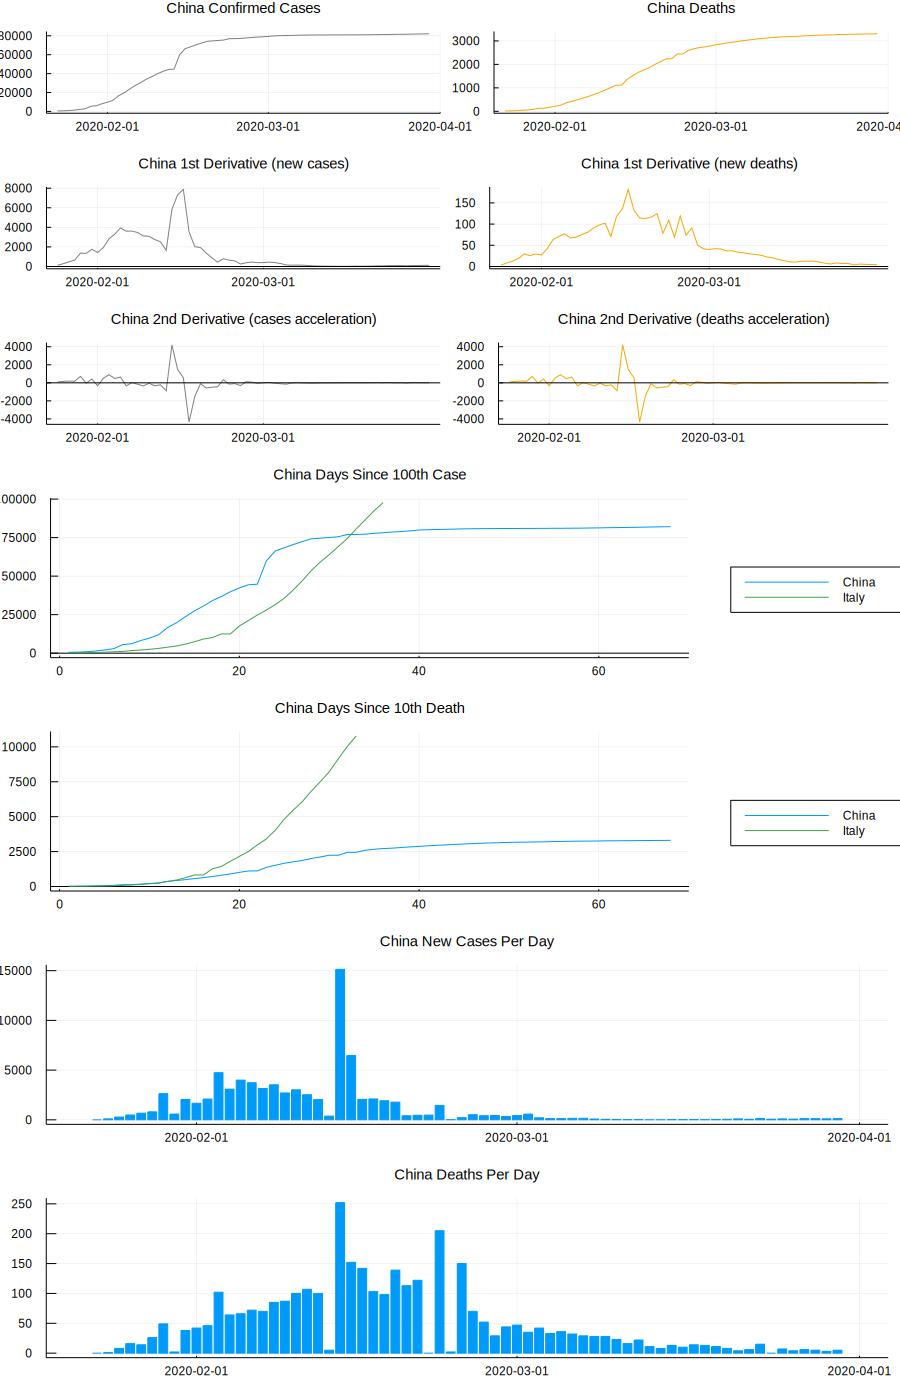

## Colombia


  * Confirmed cases: 702
  * Deaths: 10
  * Death Rate: 1.42%


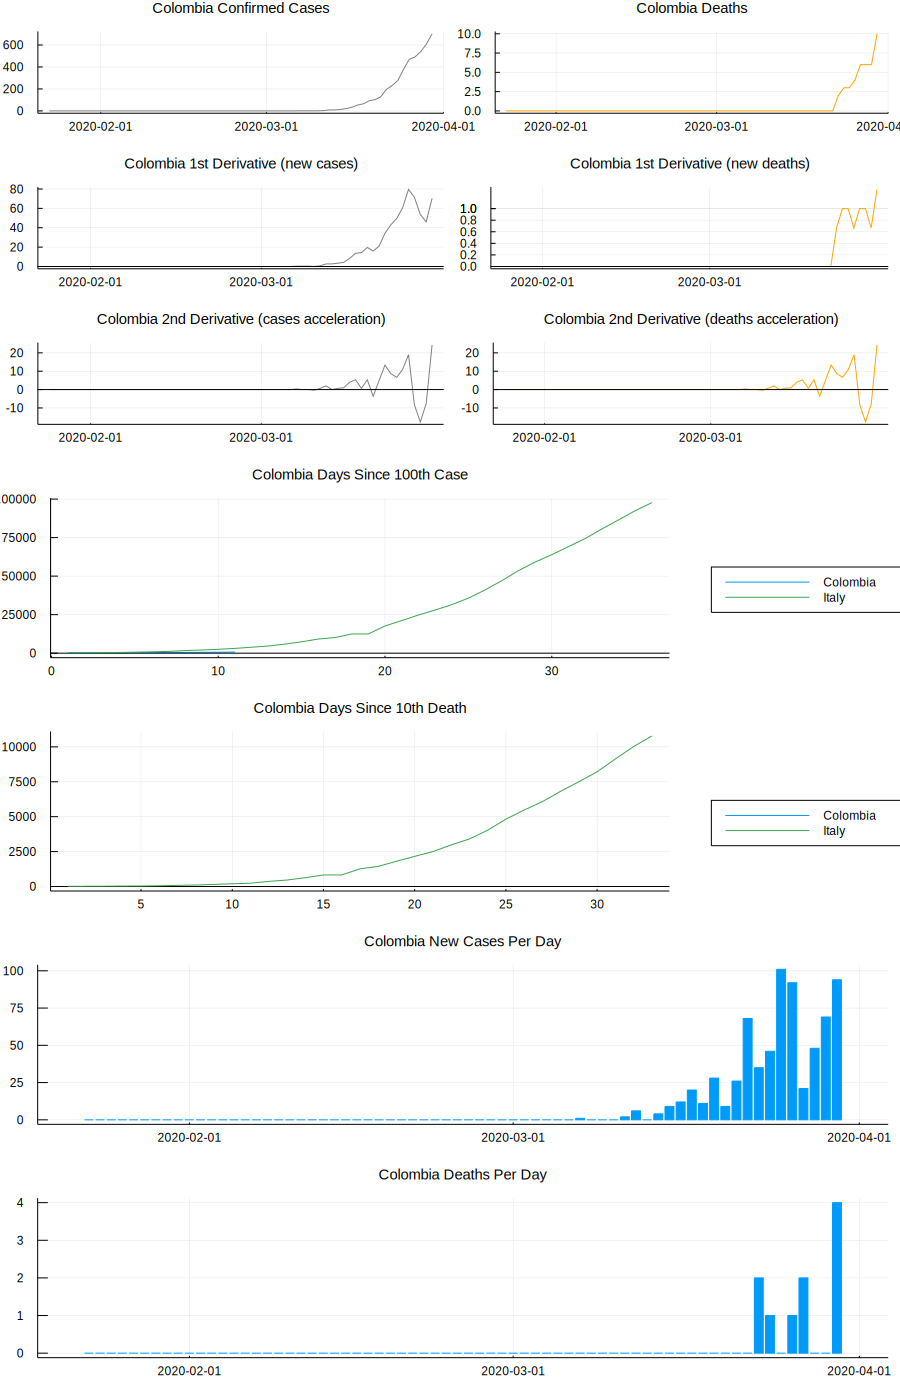

## Congo (Brazzaville)


  * Confirmed cases: 19
  * Deaths: 0
  * Death Rate: 0.0%


## Congo (Kinshasa)


  * Confirmed cases: 65
  * Deaths: 6
  * Death Rate: 9.23%


## Costa Rica


  * Confirmed cases: 314
  * Deaths: 2
  * Death Rate: 0.64%


## Cote d'Ivoire


  * Confirmed cases: 165
  * Deaths: 1
  * Death Rate: 0.61%


## Croatia


  * Confirmed cases: 713
  * Deaths: 6
  * Death Rate: 0.84%


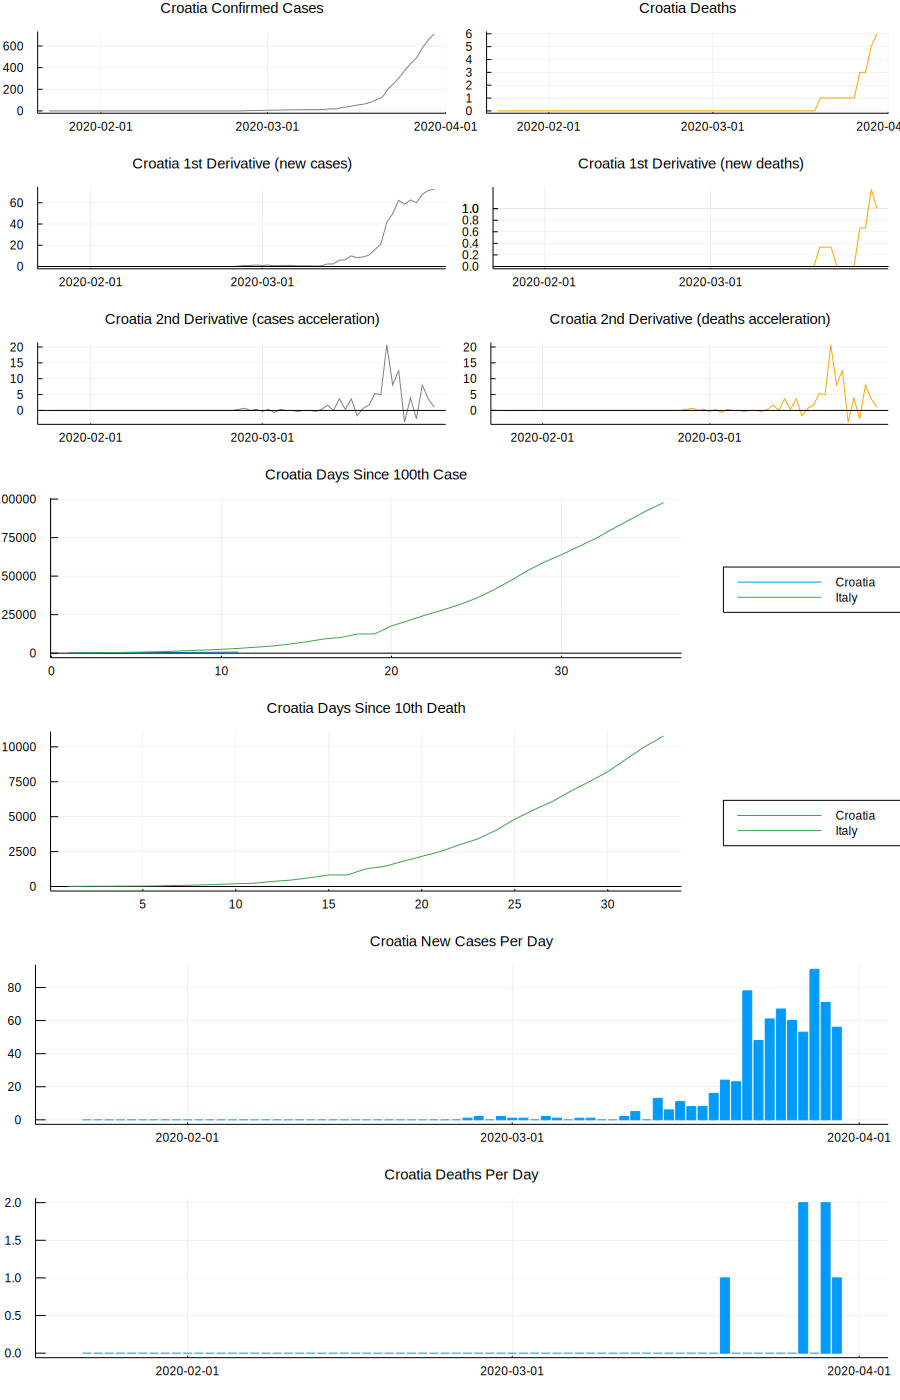

## Cuba


  * Confirmed cases: 139
  * Deaths: 3
  * Death Rate: 2.16%


## Cyprus


  * Confirmed cases: 214
  * Deaths: 5
  * Death Rate: 2.34%


## Czechia


  * Confirmed cases: 2817
  * Deaths: 16
  * Death Rate: 0.57%


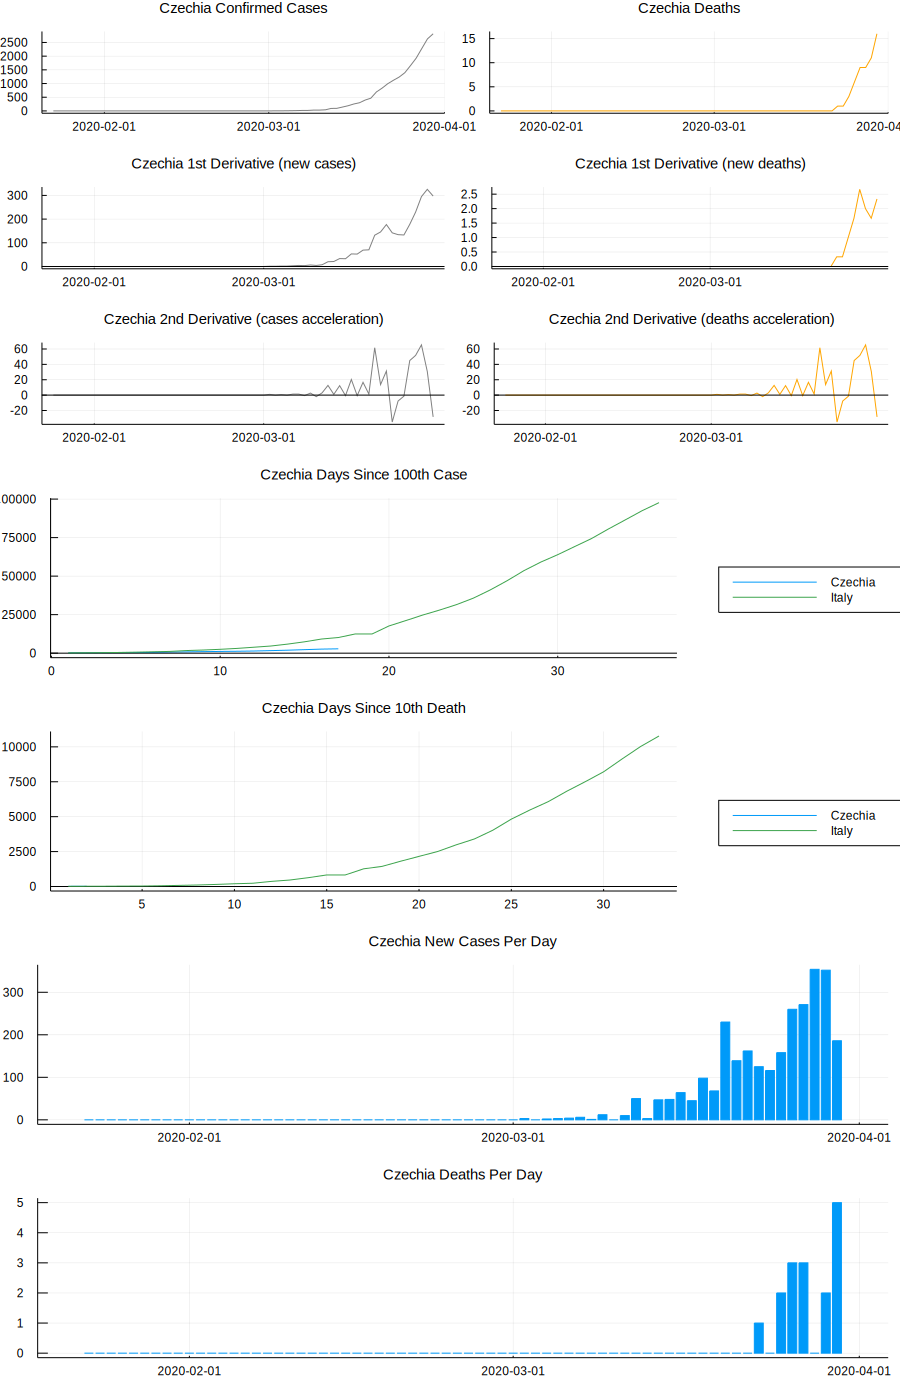

## Denmark


  * Confirmed cases: 2564
  * Deaths: 72
  * Death Rate: 2.81%


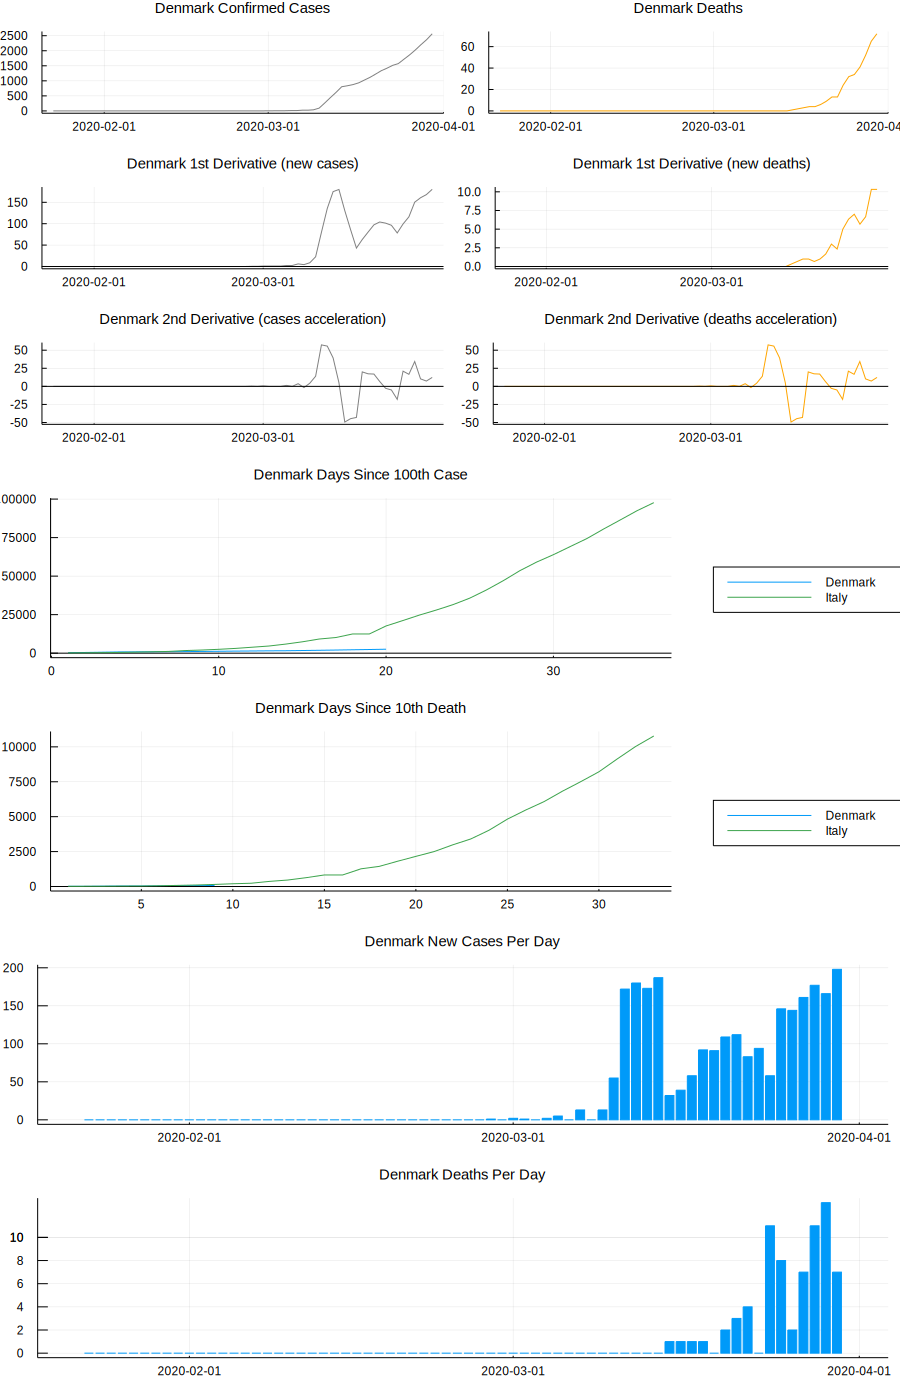

## Diamond Princess


  * Confirmed cases: 712
  * Deaths: 10
  * Death Rate: 1.4%


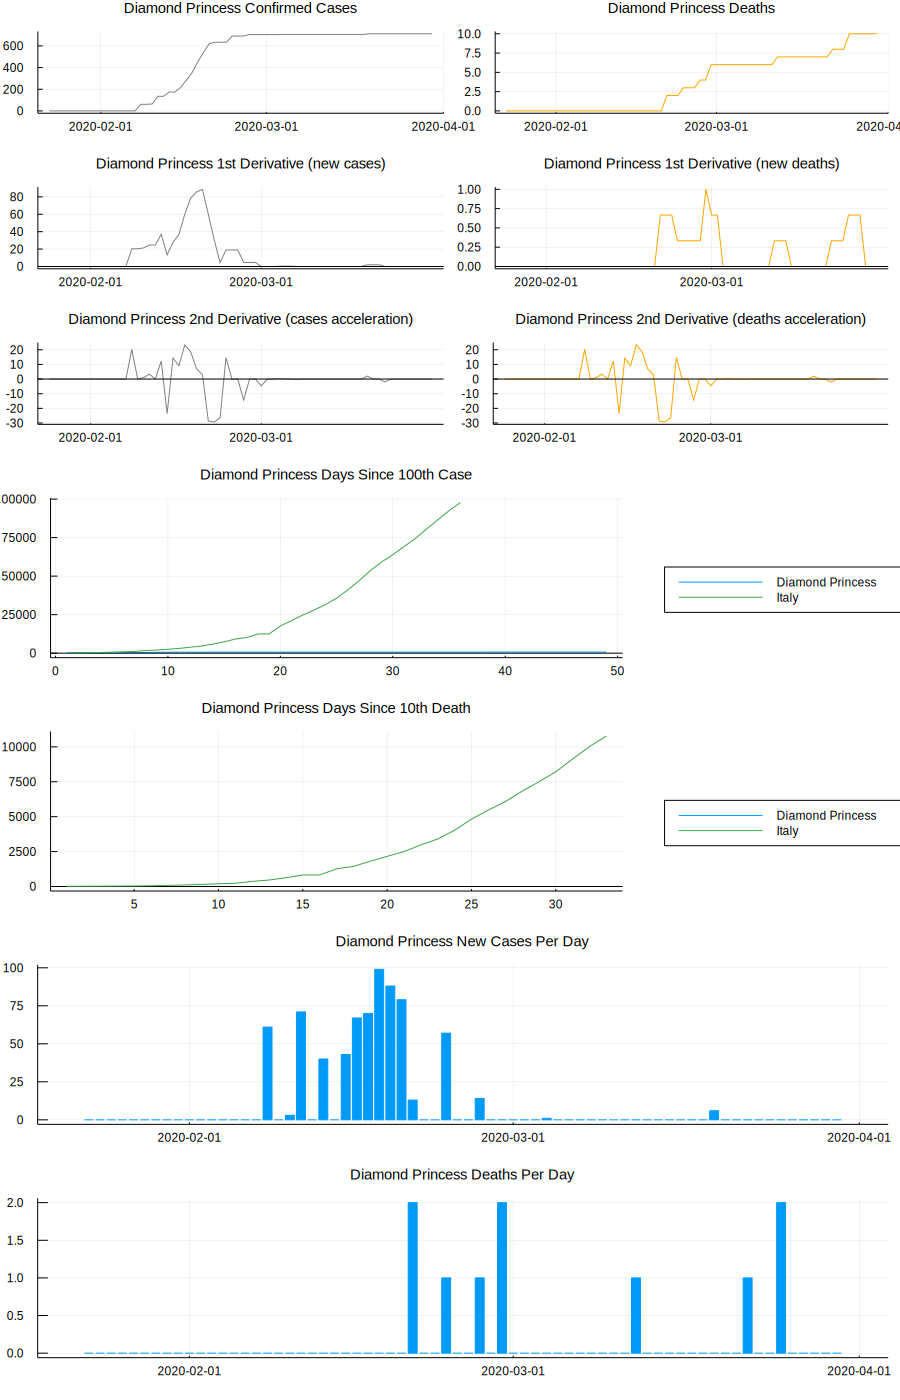

## Djibouti


  * Confirmed cases: 18
  * Deaths: 0
  * Death Rate: 0.0%


## Dominica


  * Confirmed cases: 11
  * Deaths: 0
  * Death Rate: 0.0%


## Dominican Republic


  * Confirmed cases: 859
  * Deaths: 39
  * Death Rate: 4.54%


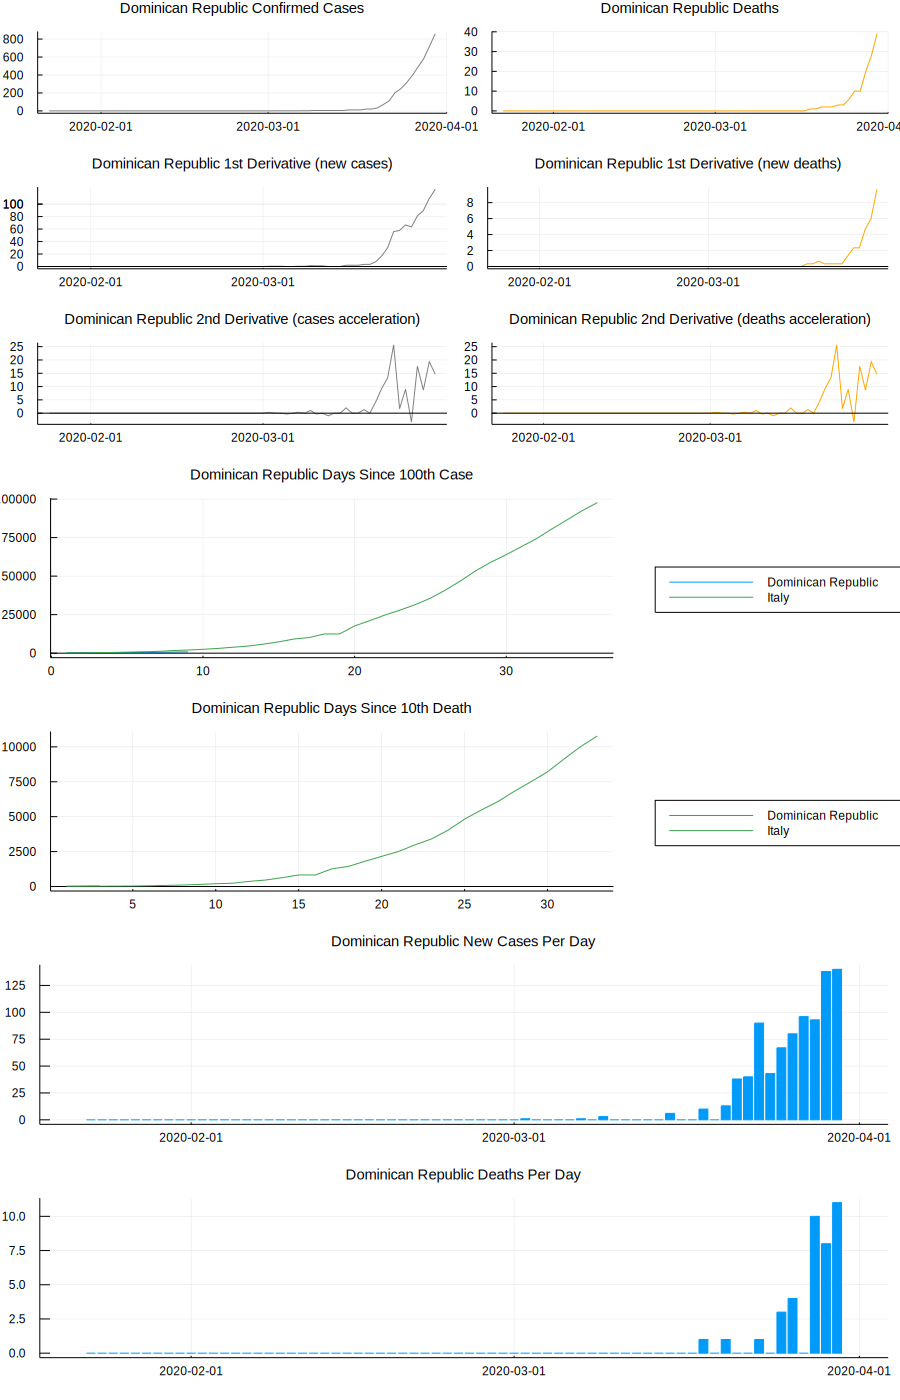

## Ecuador


  * Confirmed cases: 1924
  * Deaths: 58
  * Death Rate: 3.01%


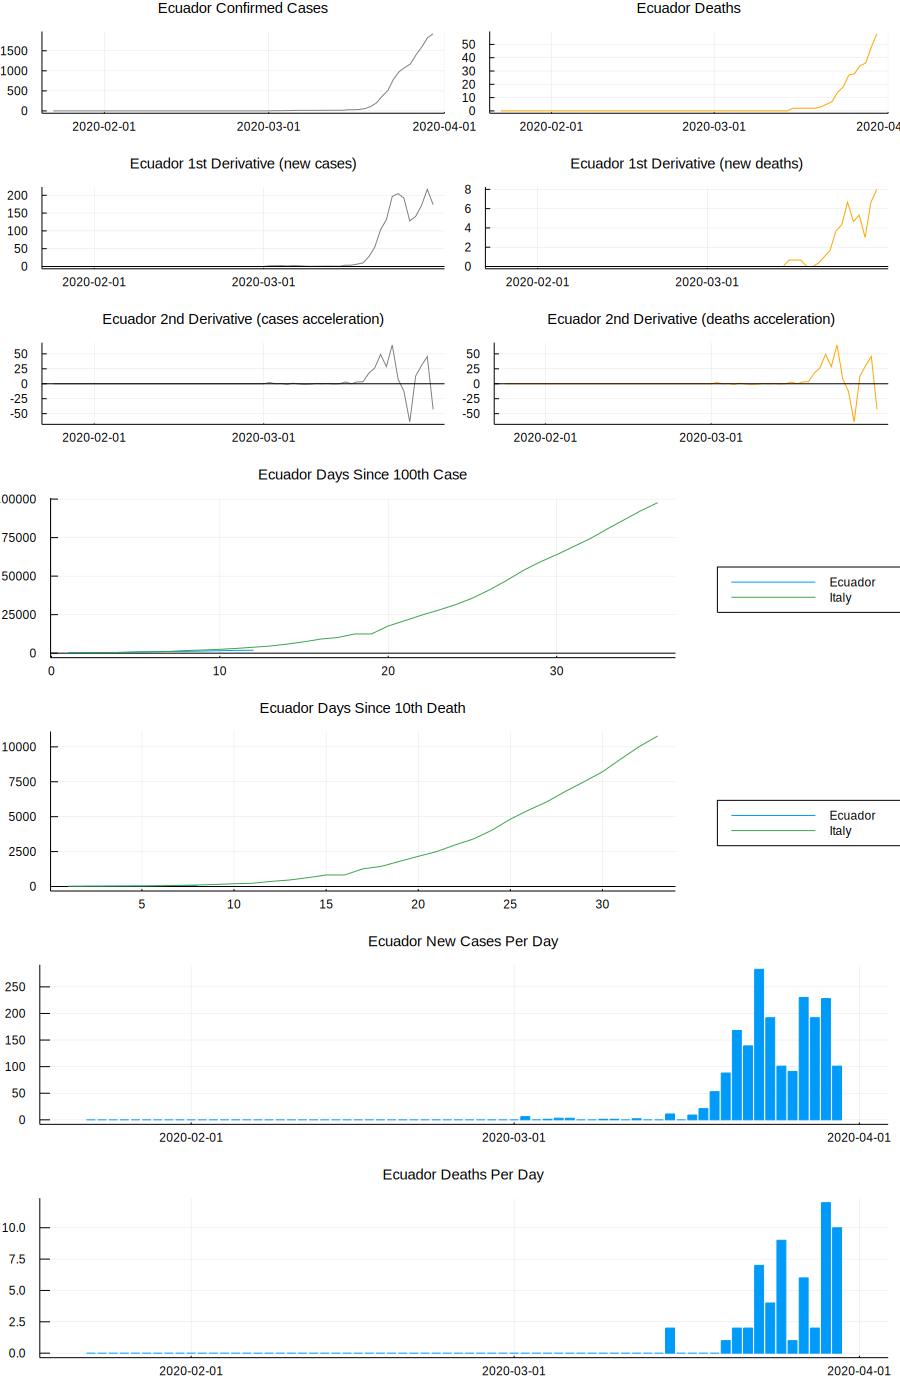

## Egypt


  * Confirmed cases: 609
  * Deaths: 40
  * Death Rate: 6.57%


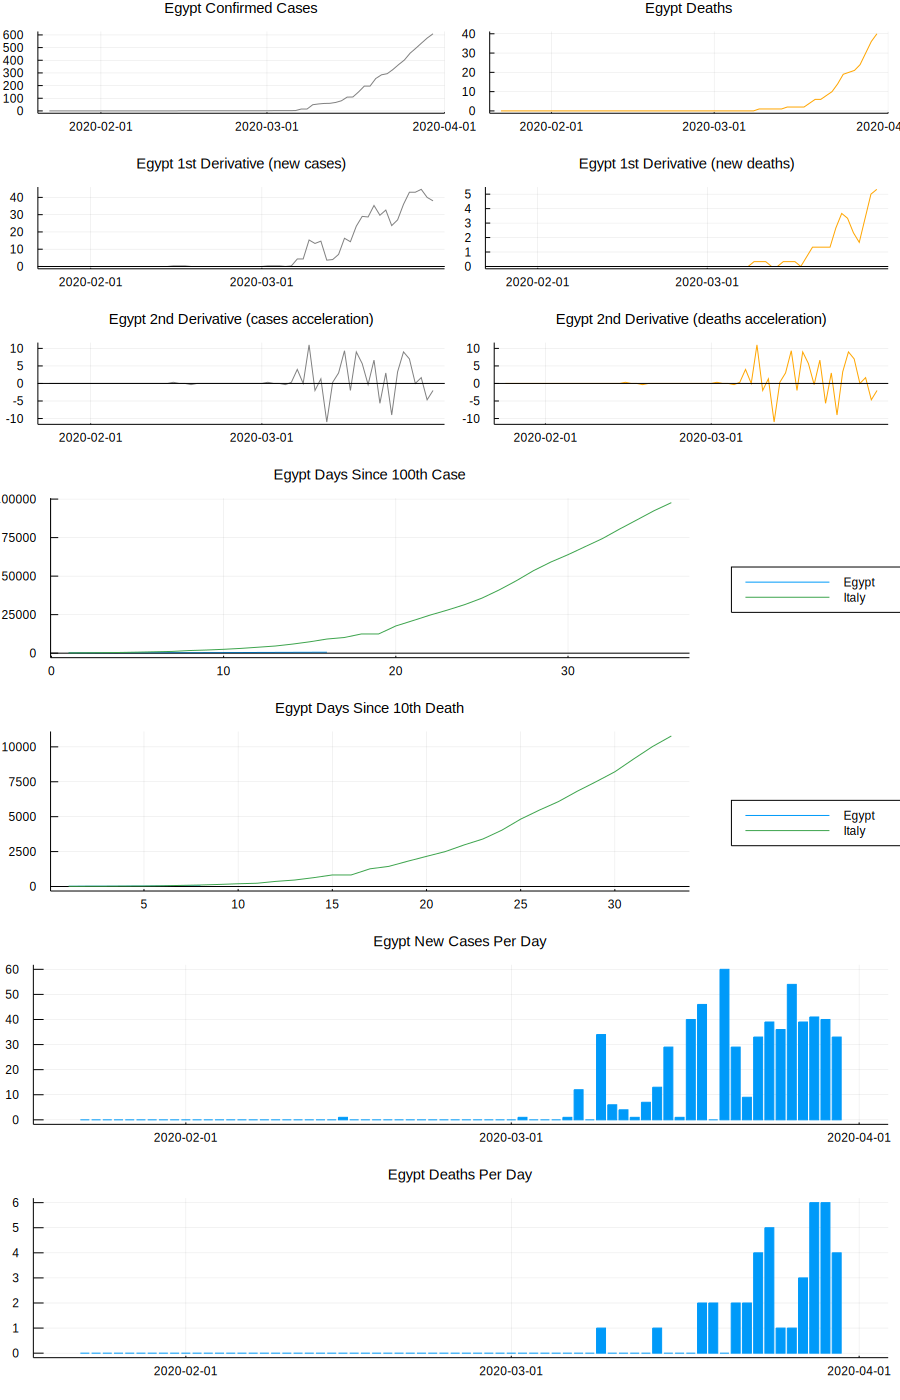

## El Salvador


  * Confirmed cases: 24
  * Deaths: 0
  * Death Rate: 0.0%


## Equatorial Guinea


  * Confirmed cases: 12
  * Deaths: 0
  * Death Rate: 0.0%


## Eritrea


  * Confirmed cases: 12
  * Deaths: 0
  * Death Rate: 0.0%


## Estonia


  * Confirmed cases: 679
  * Deaths: 3
  * Death Rate: 0.44%


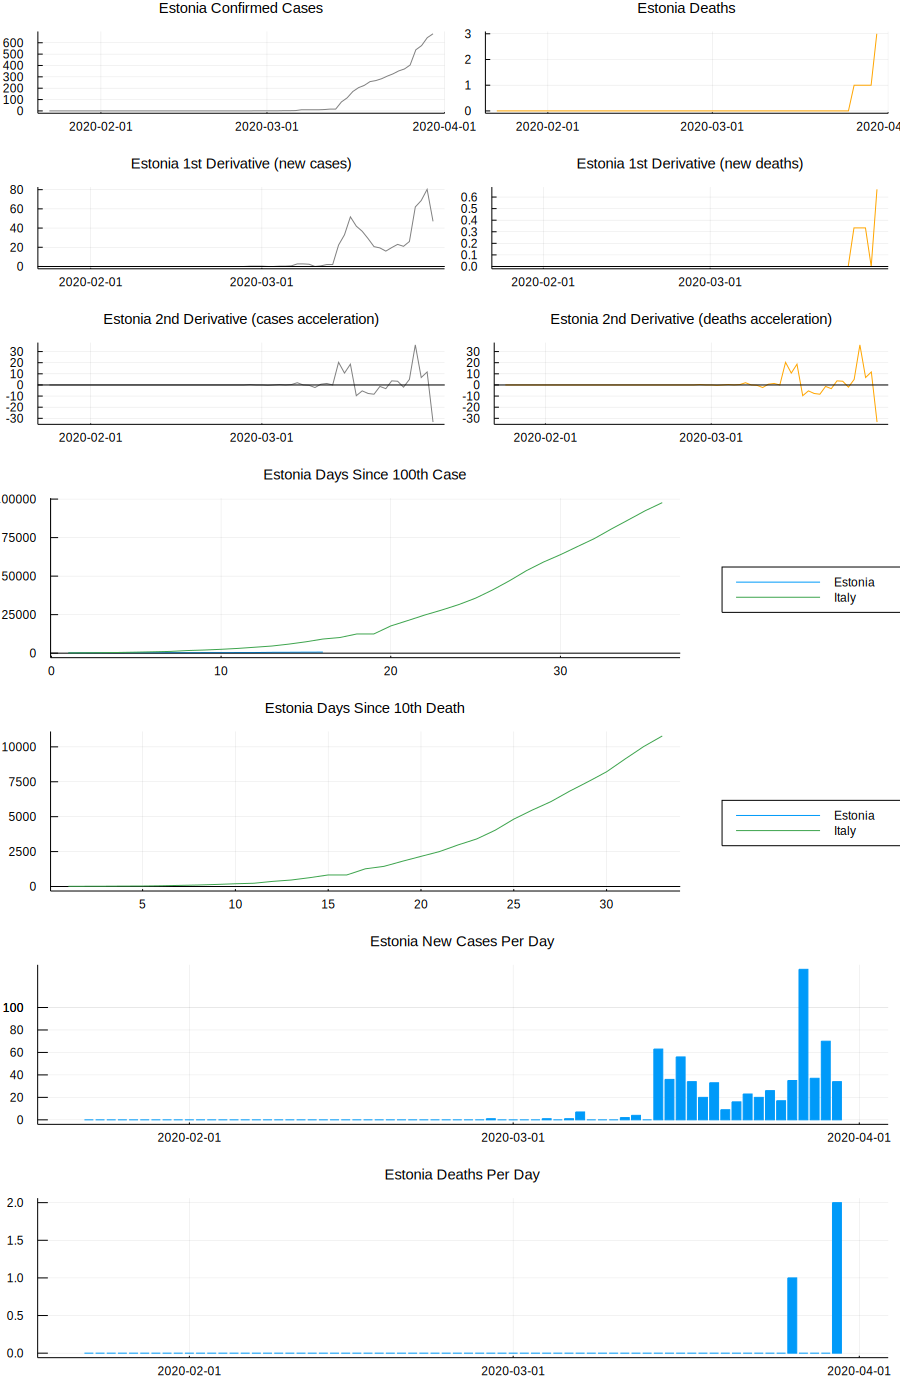

## Eswatini


  * Confirmed cases: 9
  * Deaths: 0
  * Death Rate: 0.0%


## Ethiopia


  * Confirmed cases: 21
  * Deaths: 0
  * Death Rate: 0.0%


## Fiji


  * Confirmed cases: 5
  * Deaths: 0
  * Death Rate: 0.0%


## Finland


  * Confirmed cases: 1240
  * Deaths: 11
  * Death Rate: 0.89%


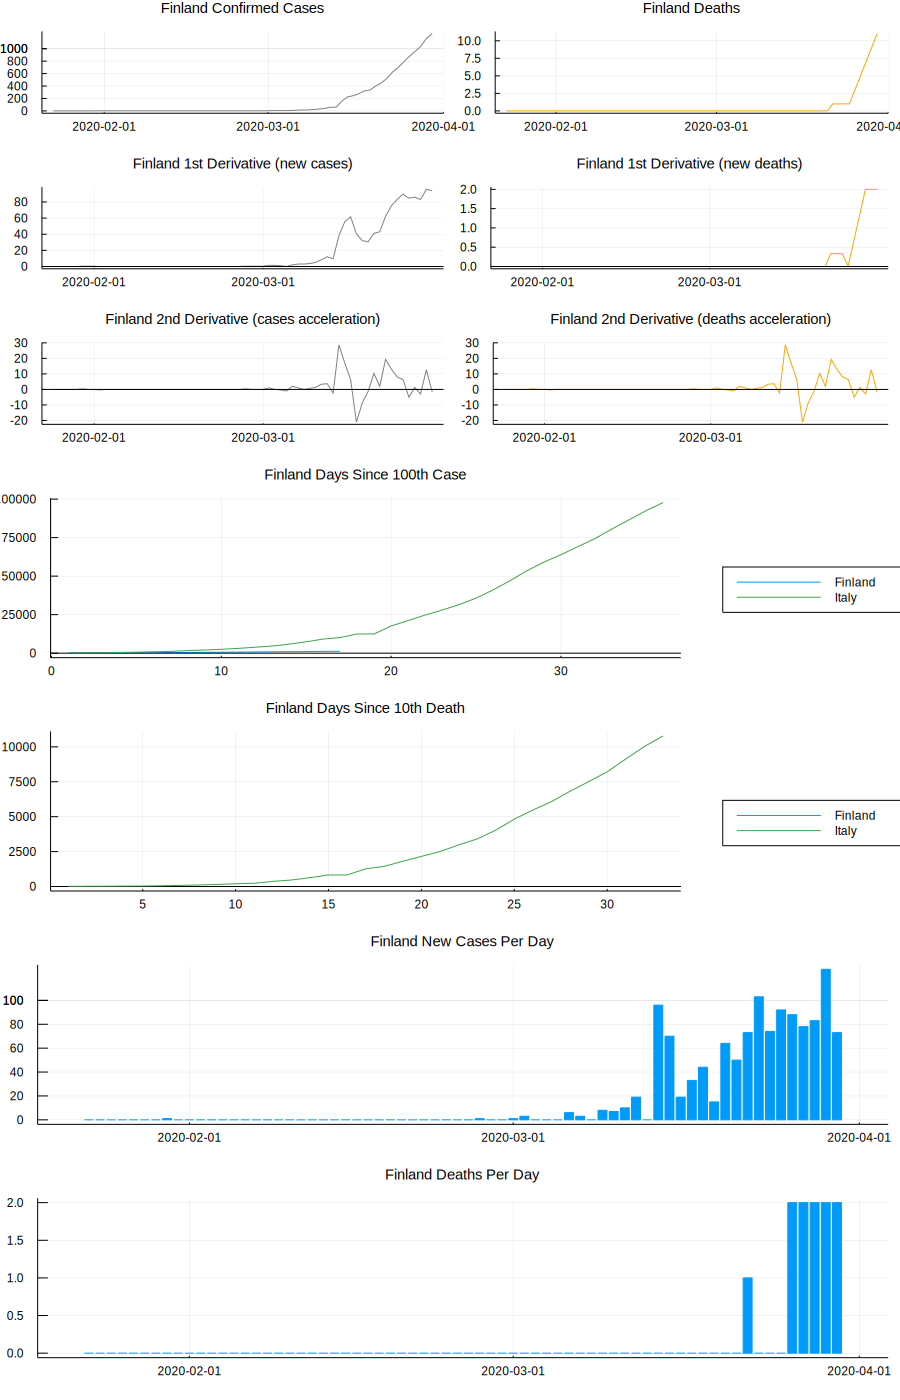

## France


  * Confirmed cases: 40708
  * Deaths: 2611
  * Death Rate: 6.41%


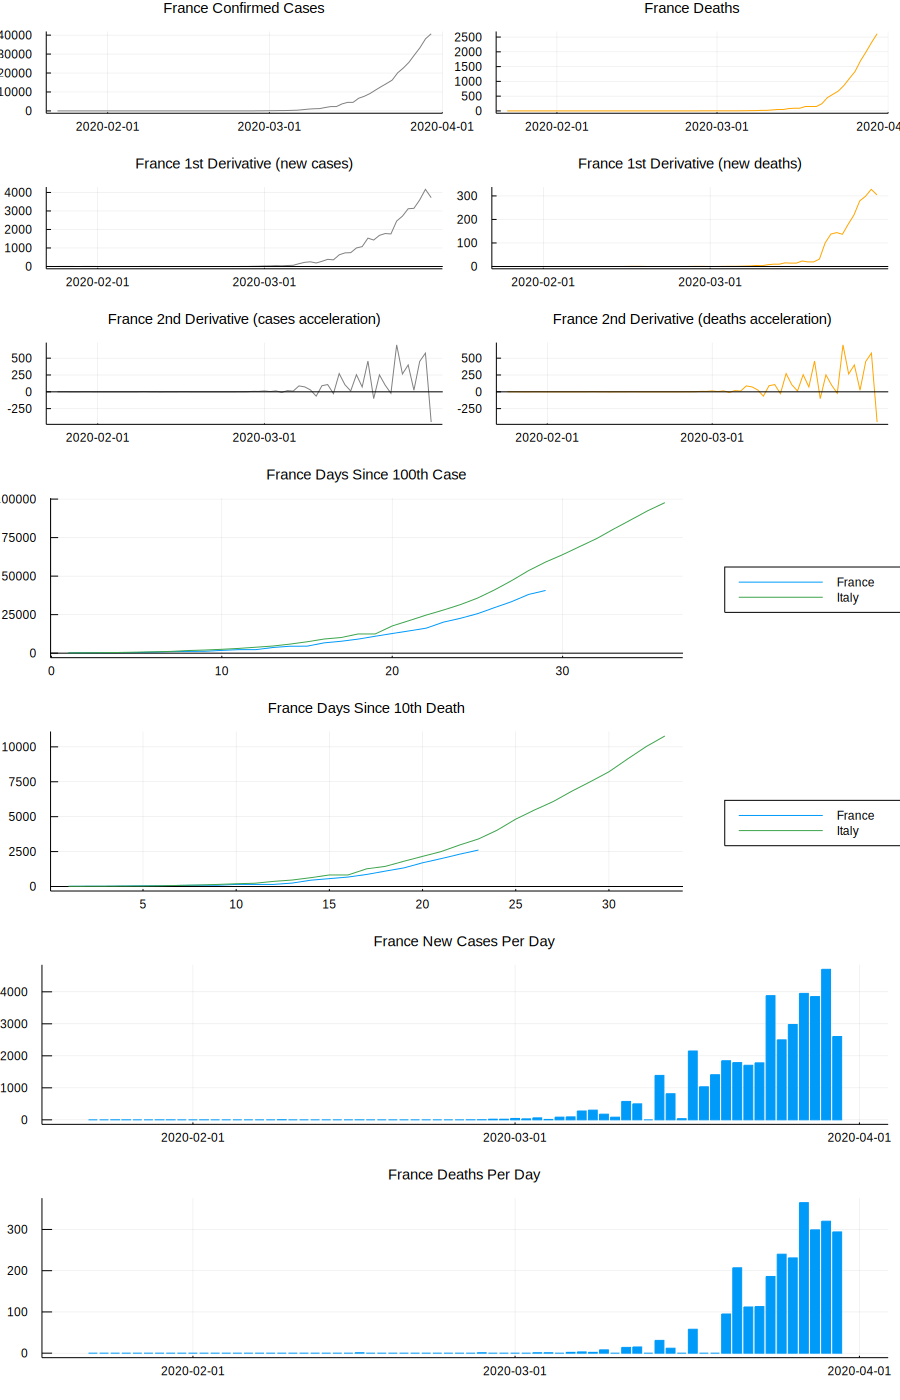

## Gabon


  * Confirmed cases: 7
  * Deaths: 1
  * Death Rate: 14.29%


## Gambia


  * Confirmed cases: 4
  * Deaths: 1
  * Death Rate: 25.0%


## Georgia


  * Confirmed cases: 91
  * Deaths: 0
  * Death Rate: 0.0%


## Germany


  * Confirmed cases: 62095
  * Deaths: 533
  * Death Rate: 0.86%


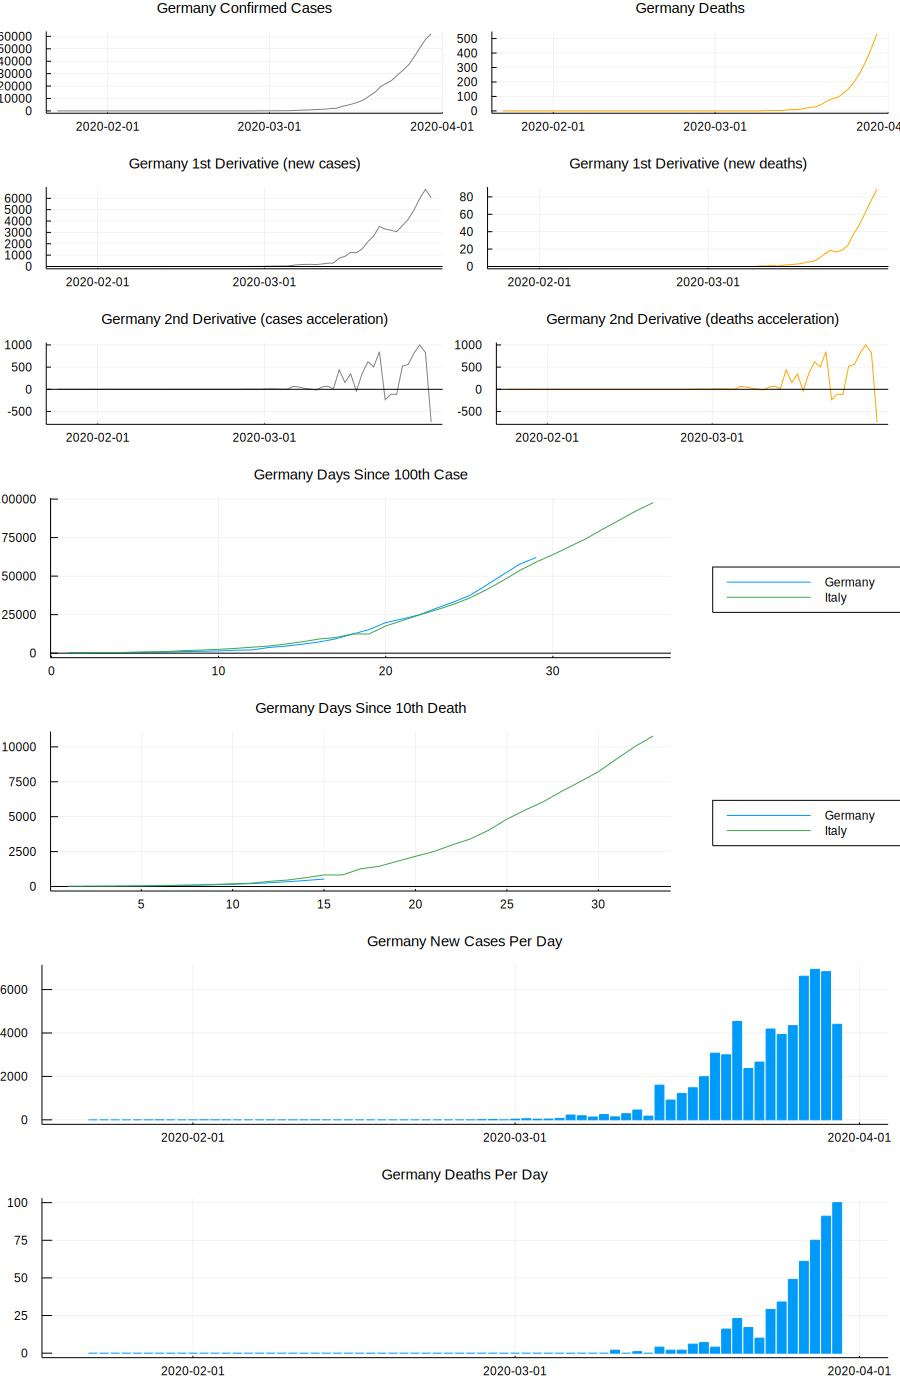

## Ghana


  * Confirmed cases: 152
  * Deaths: 5
  * Death Rate: 3.29%


## Greece


  * Confirmed cases: 1156
  * Deaths: 38
  * Death Rate: 3.29%


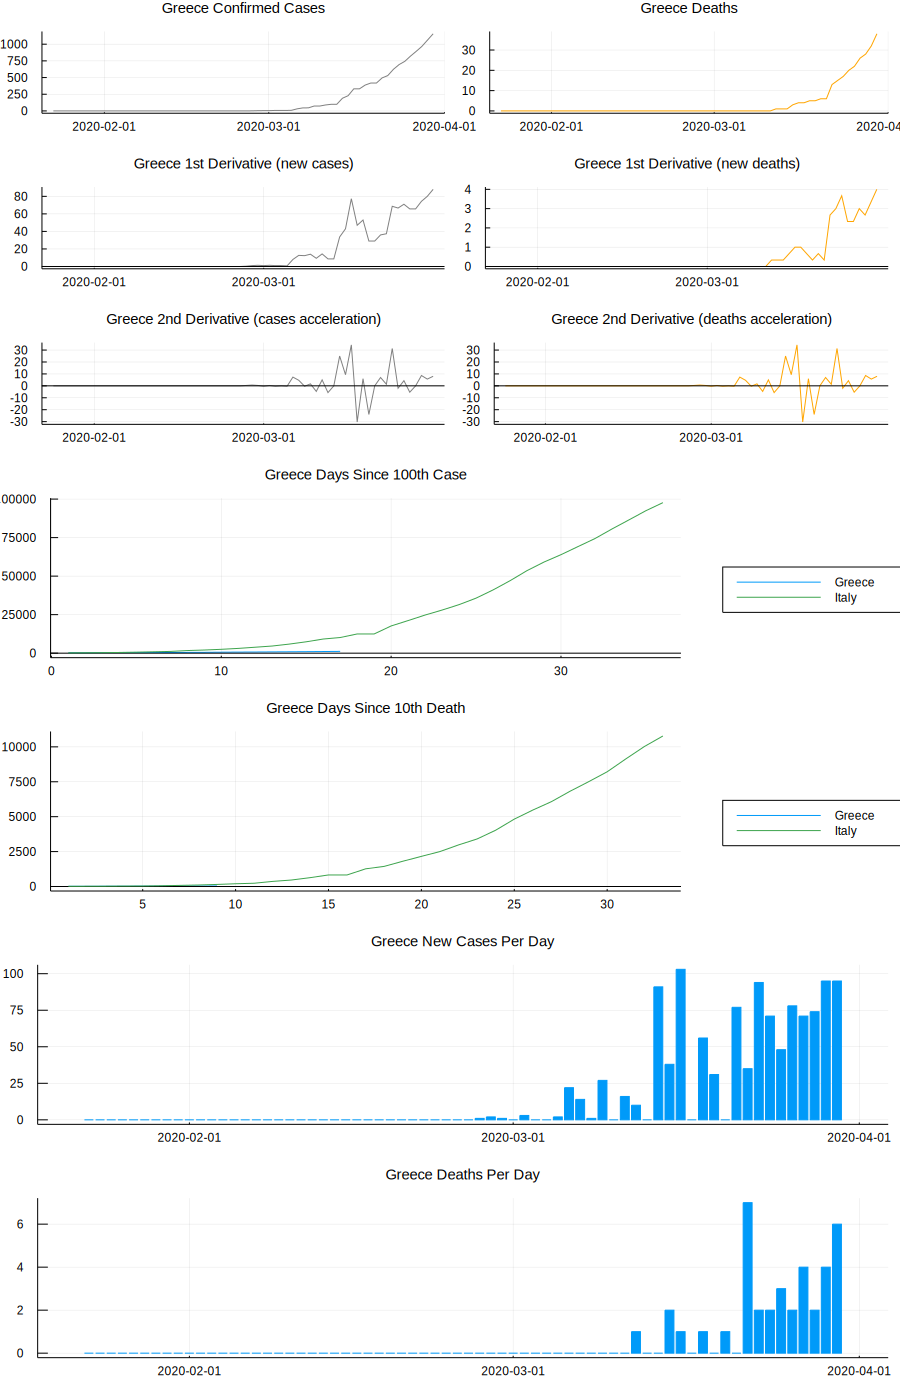

## Grenada


  * Confirmed cases: 9
  * Deaths: 0
  * Death Rate: 0.0%


## Guatemala


  * Confirmed cases: 34
  * Deaths: 1
  * Death Rate: 2.94%


## Guinea


  * Confirmed cases: 16
  * Deaths: 0
  * Death Rate: 0.0%


## Guinea-Bissau


  * Confirmed cases: 2
  * Deaths: 0
  * Death Rate: 0.0%


## Guyana


  * Confirmed cases: 20
  * Deaths: 1
  * Death Rate: 5.0%


## Haiti


  * Confirmed cases: 15
  * Deaths: 0
  * Death Rate: 0.0%


## Holy See


  * Confirmed cases: 6
  * Deaths: 0
  * Death Rate: 0.0%


## Honduras


  * Confirmed cases: 110
  * Deaths: 3
  * Death Rate: 2.73%


## Hungary


  * Confirmed cases: 408
  * Deaths: 13
  * Death Rate: 3.19%


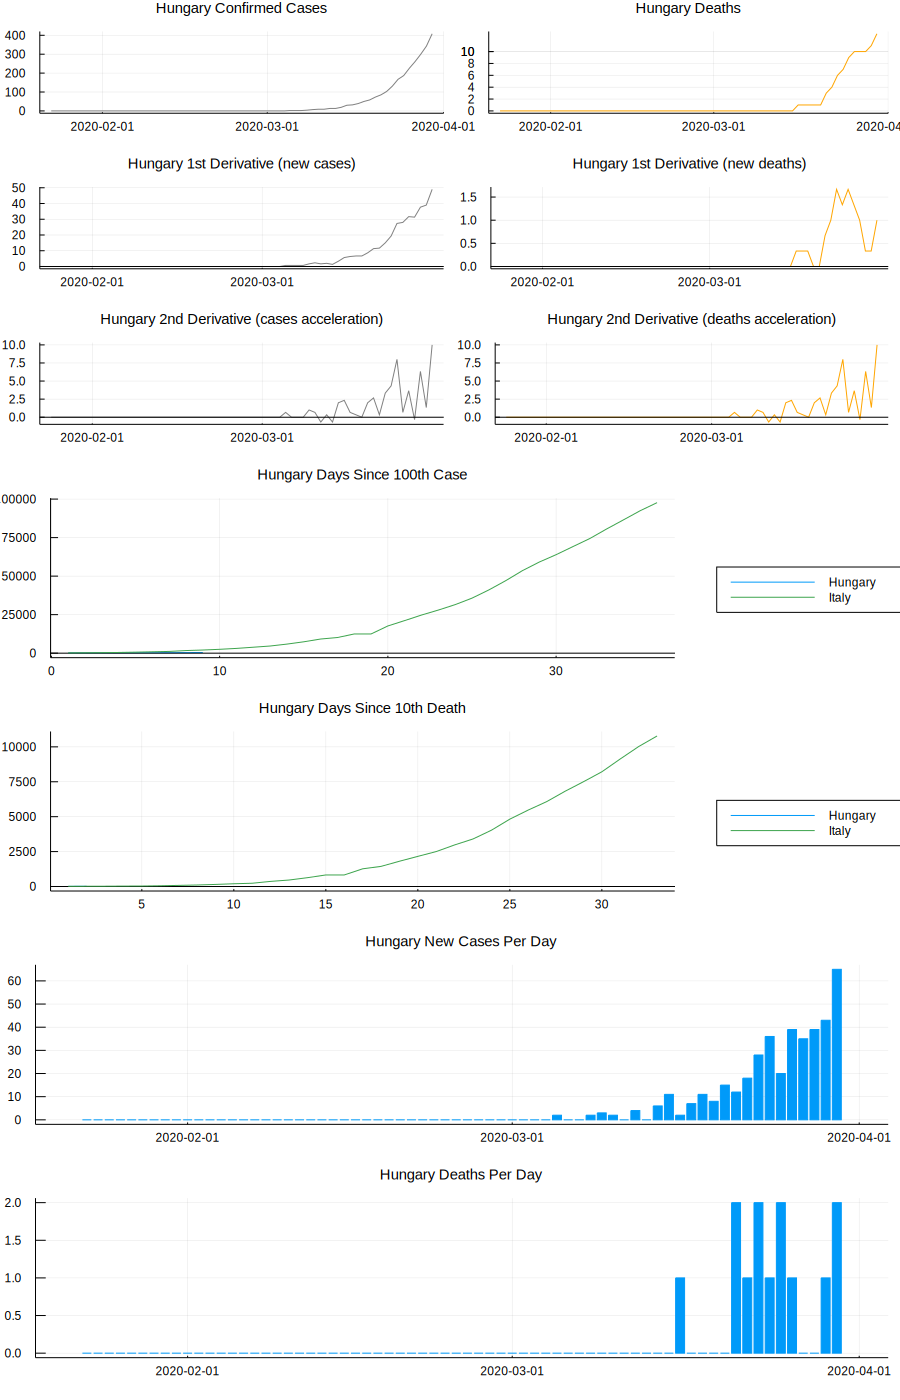

## Iceland


  * Confirmed cases: 1020
  * Deaths: 5
  * Death Rate: 0.49%


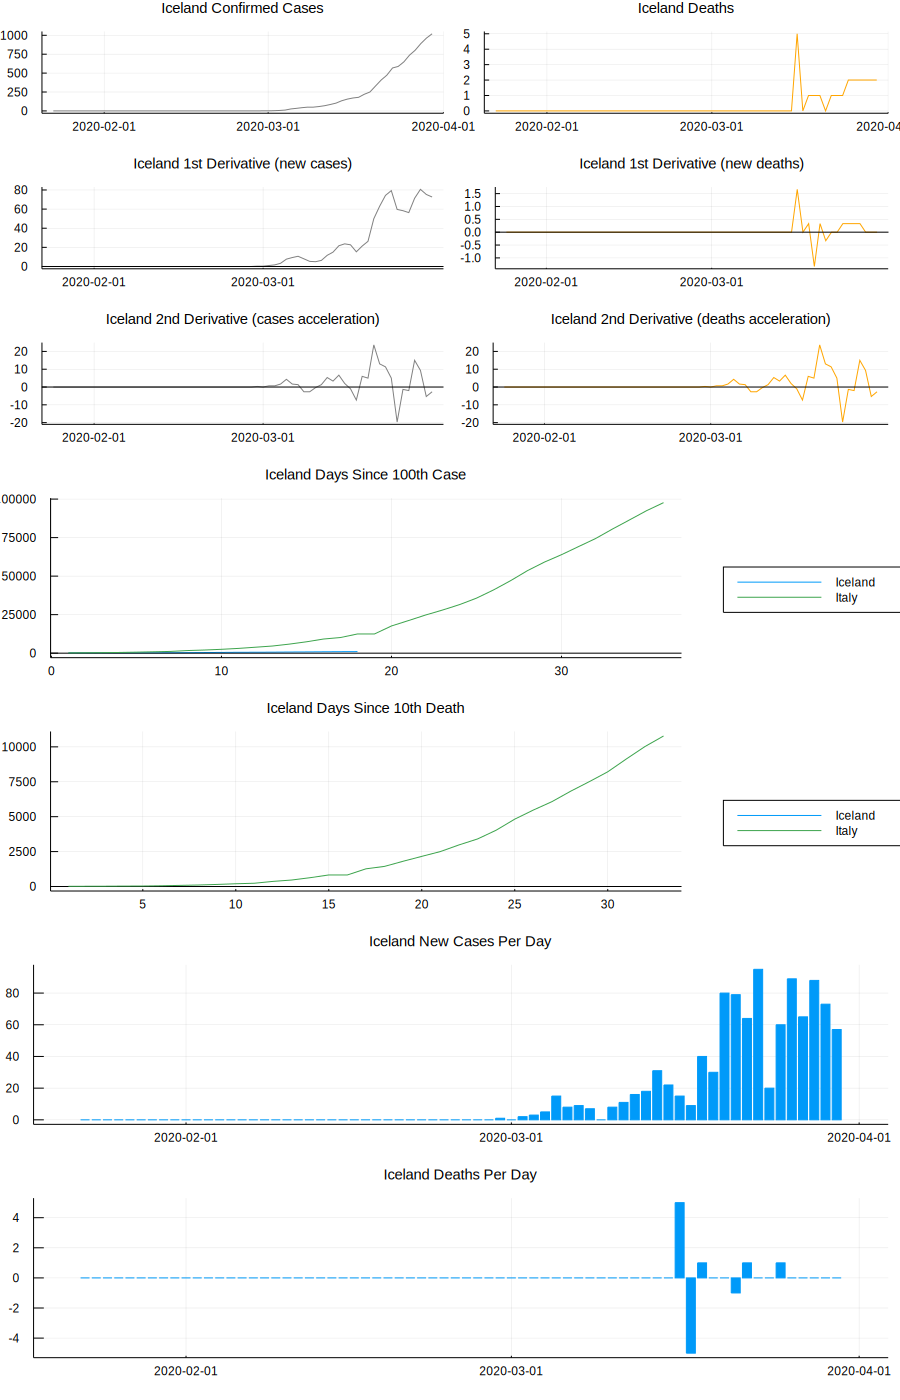

## India


  * Confirmed cases: 1024
  * Deaths: 27
  * Death Rate: 2.64%


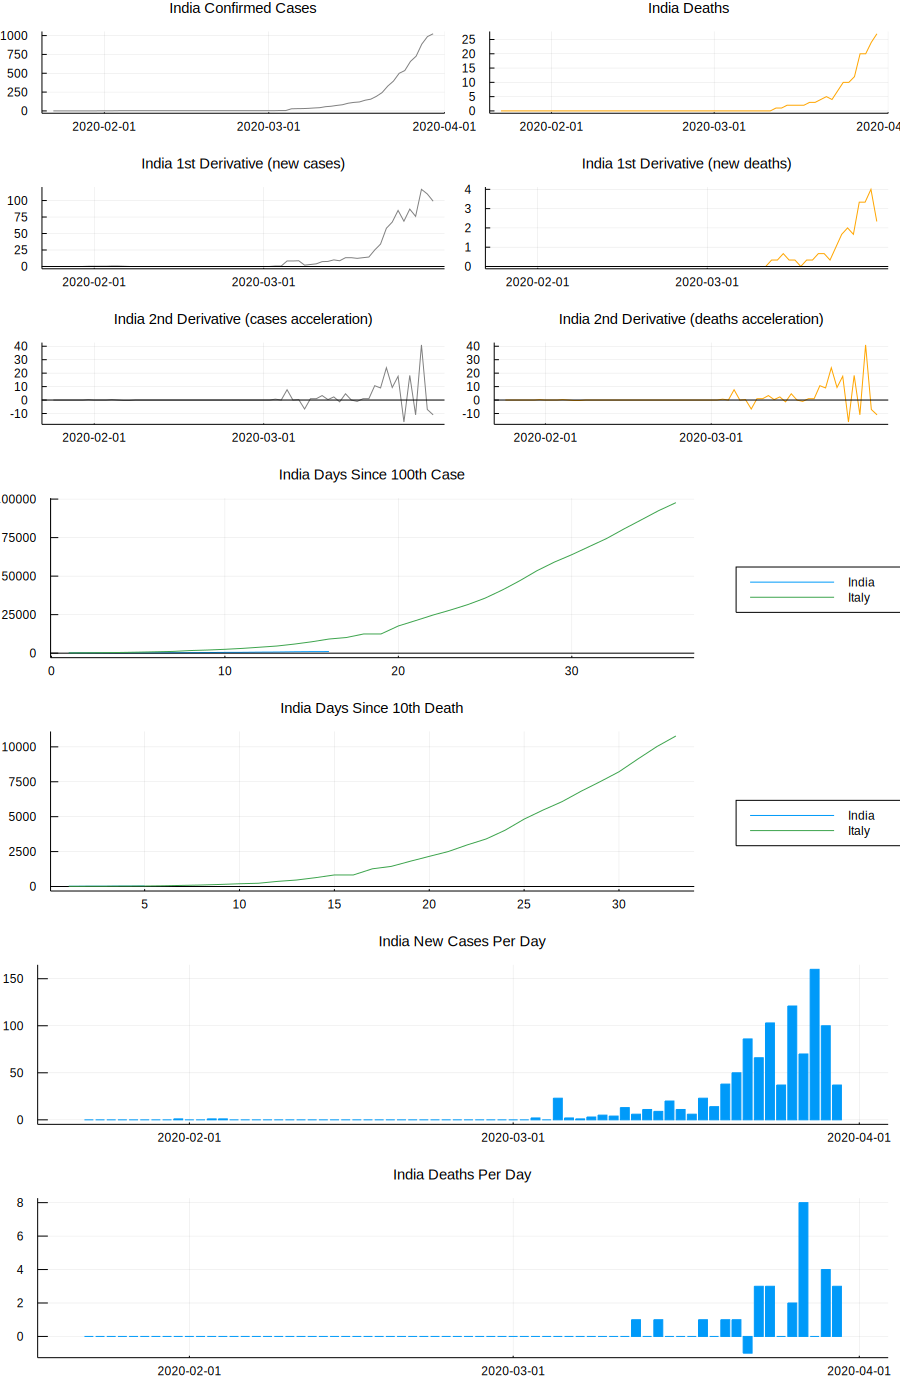

## Indonesia


  * Confirmed cases: 1285
  * Deaths: 114
  * Death Rate: 8.87%


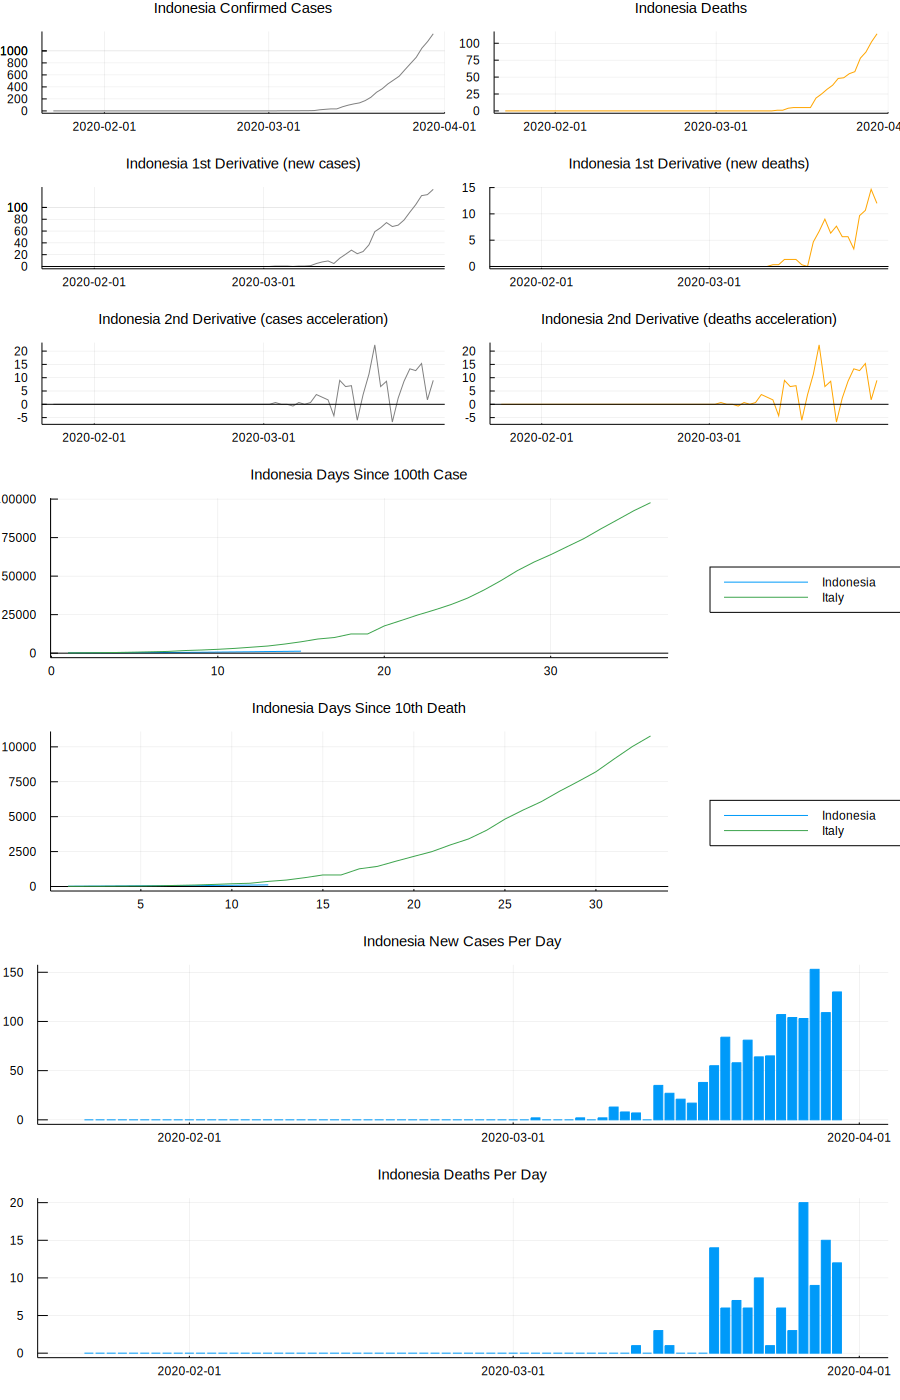

## Iran


  * Confirmed cases: 38309
  * Deaths: 2640
  * Death Rate: 6.89%


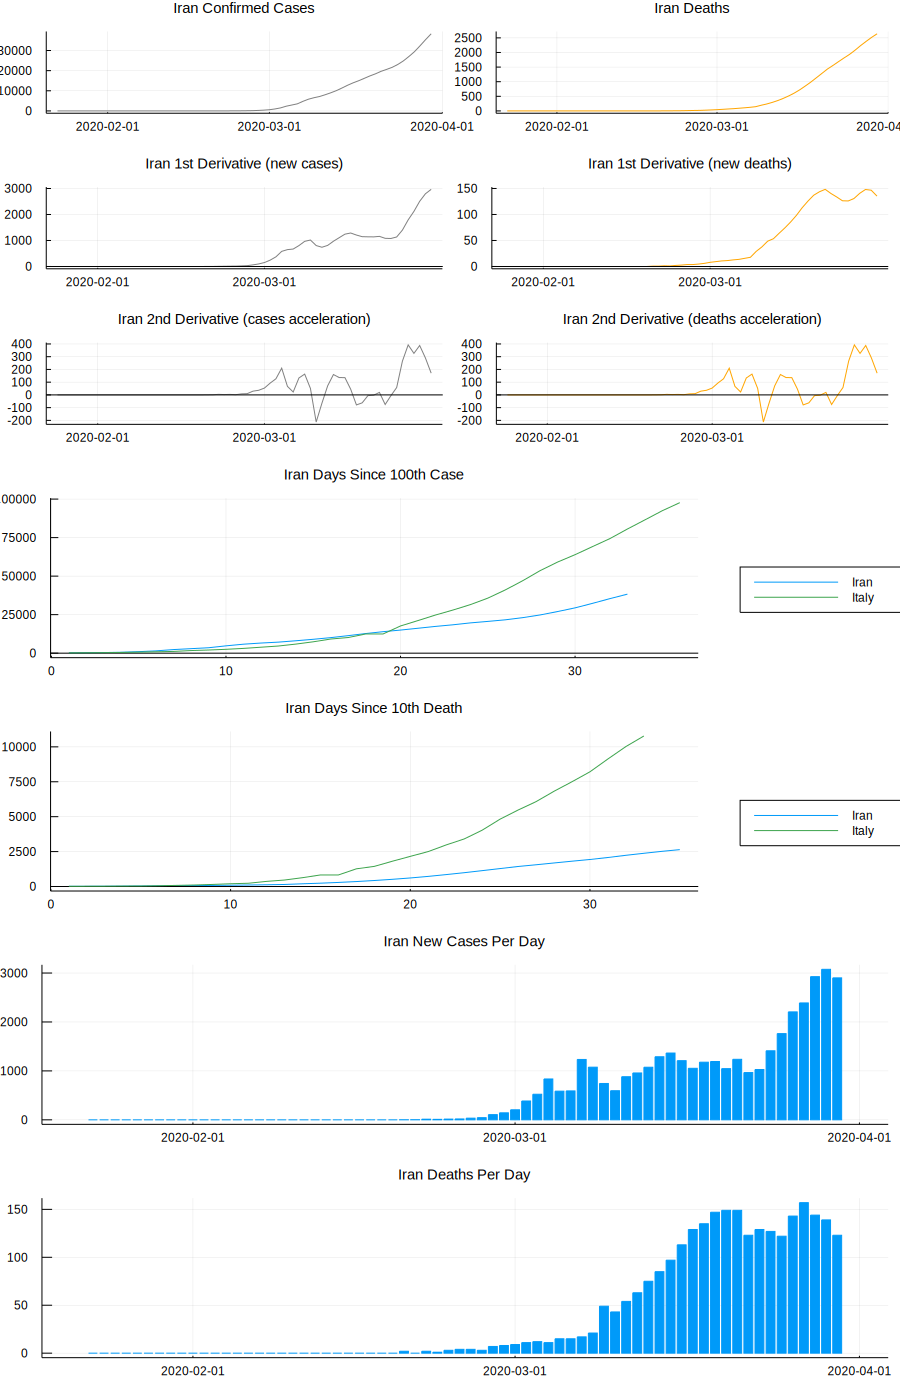

## Iraq


  * Confirmed cases: 547
  * Deaths: 42
  * Death Rate: 7.68%


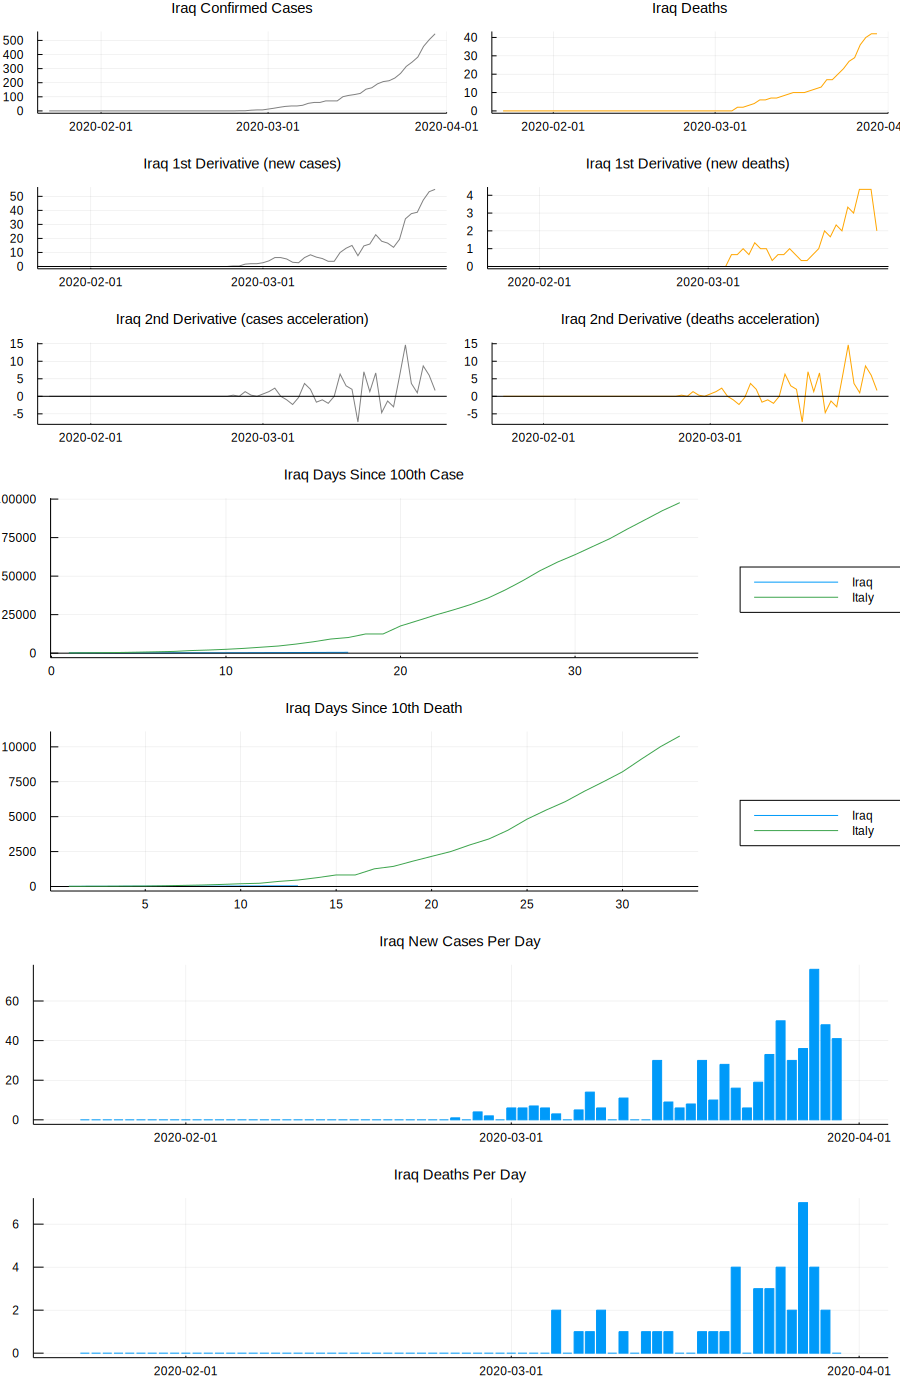

## Ireland


  * Confirmed cases: 2615
  * Deaths: 46
  * Death Rate: 1.76%


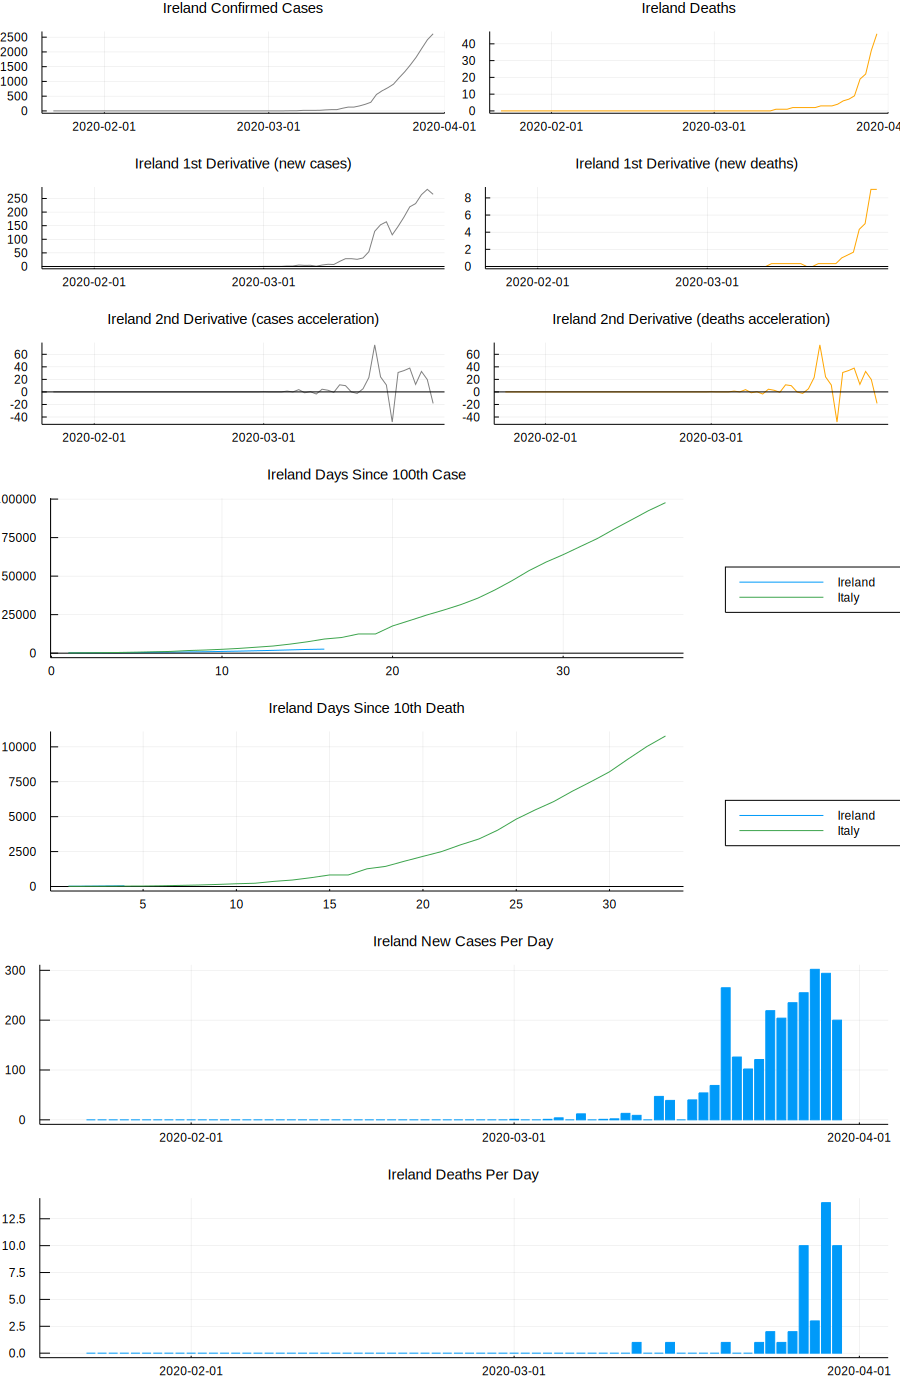

## Israel


  * Confirmed cases: 4247
  * Deaths: 15
  * Death Rate: 0.35%


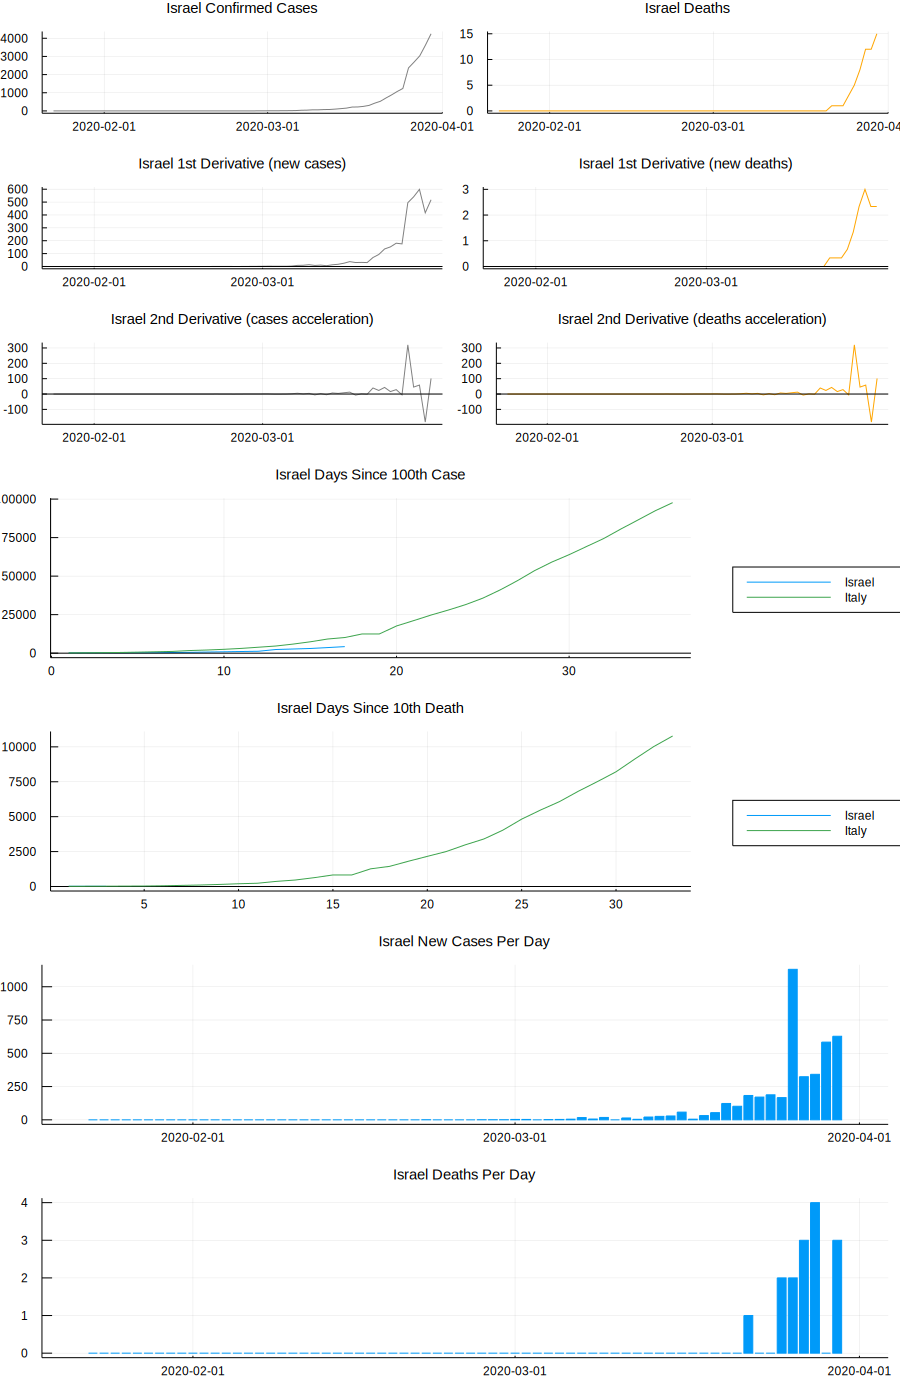

## Italy


  * Confirmed cases: 97689
  * Deaths: 10779
  * Death Rate: 11.03%


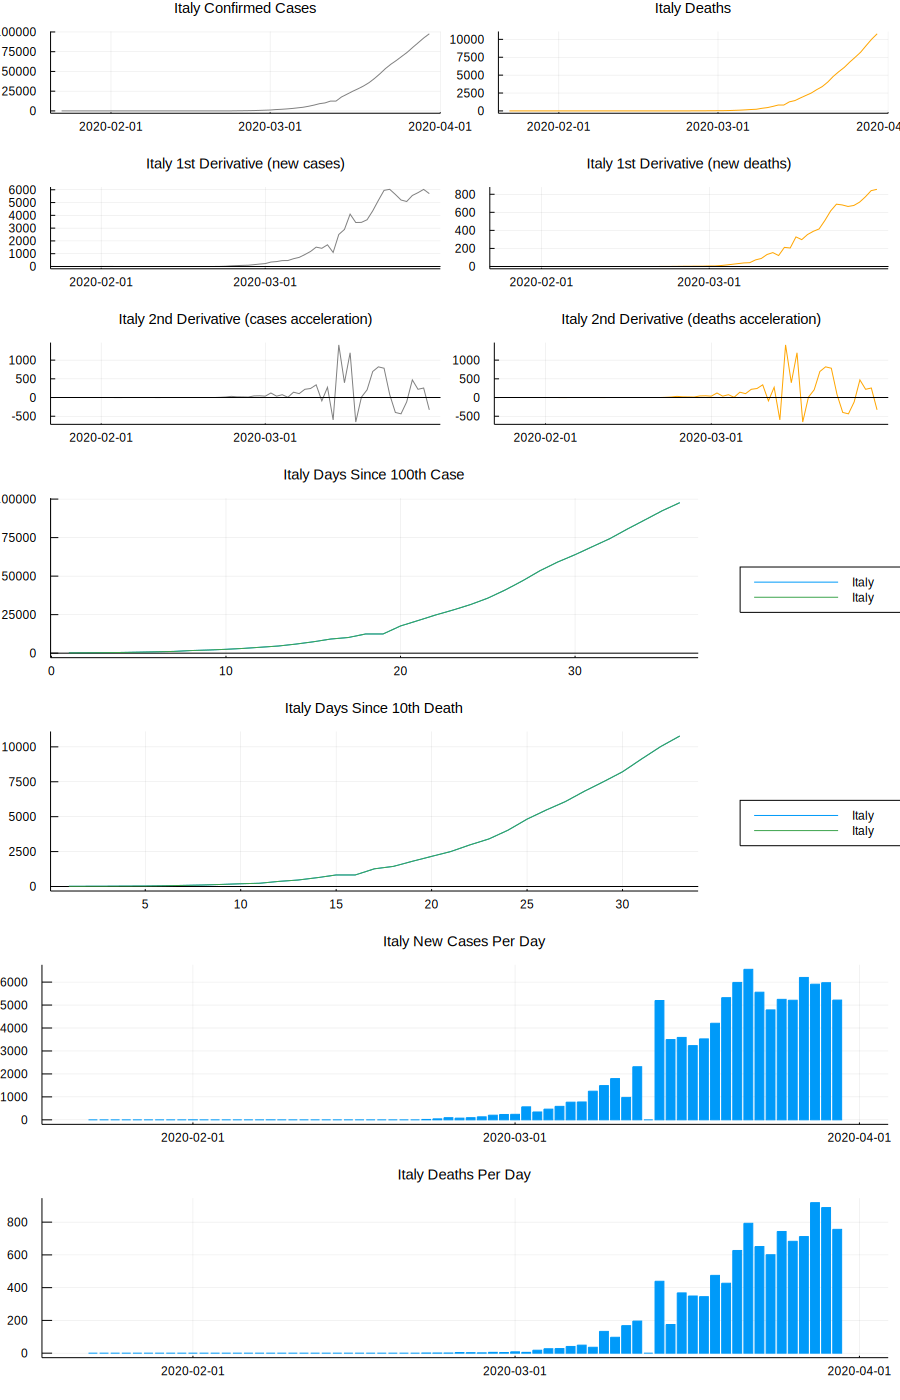

## Jamaica


  * Confirmed cases: 32
  * Deaths: 1
  * Death Rate: 3.12%


## Japan


  * Confirmed cases: 1866
  * Deaths: 54
  * Death Rate: 2.89%


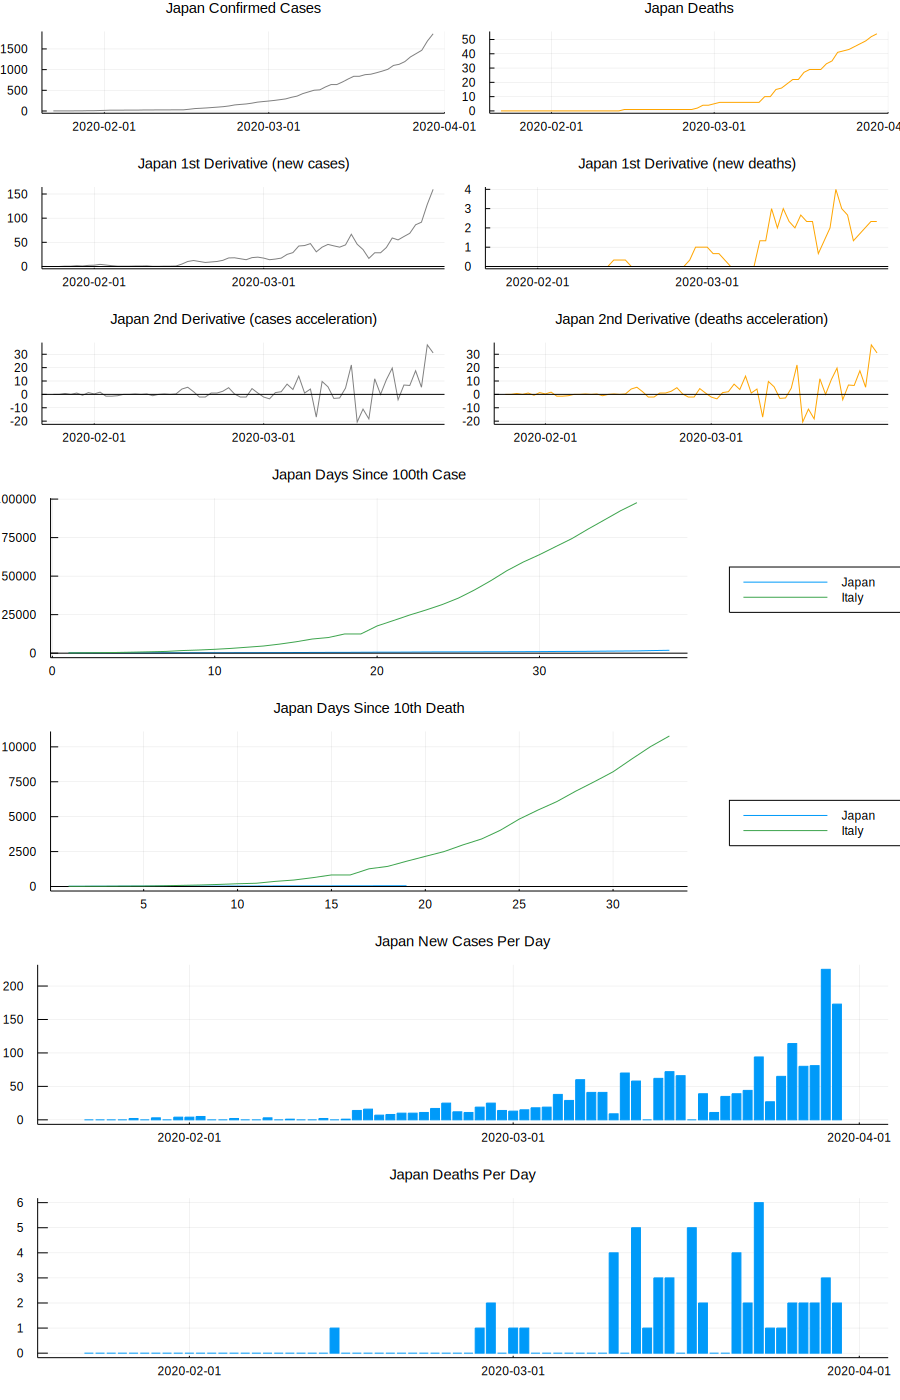

## Jordan


  * Confirmed cases: 259
  * Deaths: 3
  * Death Rate: 1.16%


## Kazakhstan


  * Confirmed cases: 284
  * Deaths: 3
  * Death Rate: 1.06%


## Kenya


  * Confirmed cases: 42
  * Deaths: 1
  * Death Rate: 2.38%


## Korea, South


  * Confirmed cases: 9583
  * Deaths: 152
  * Death Rate: 1.59%


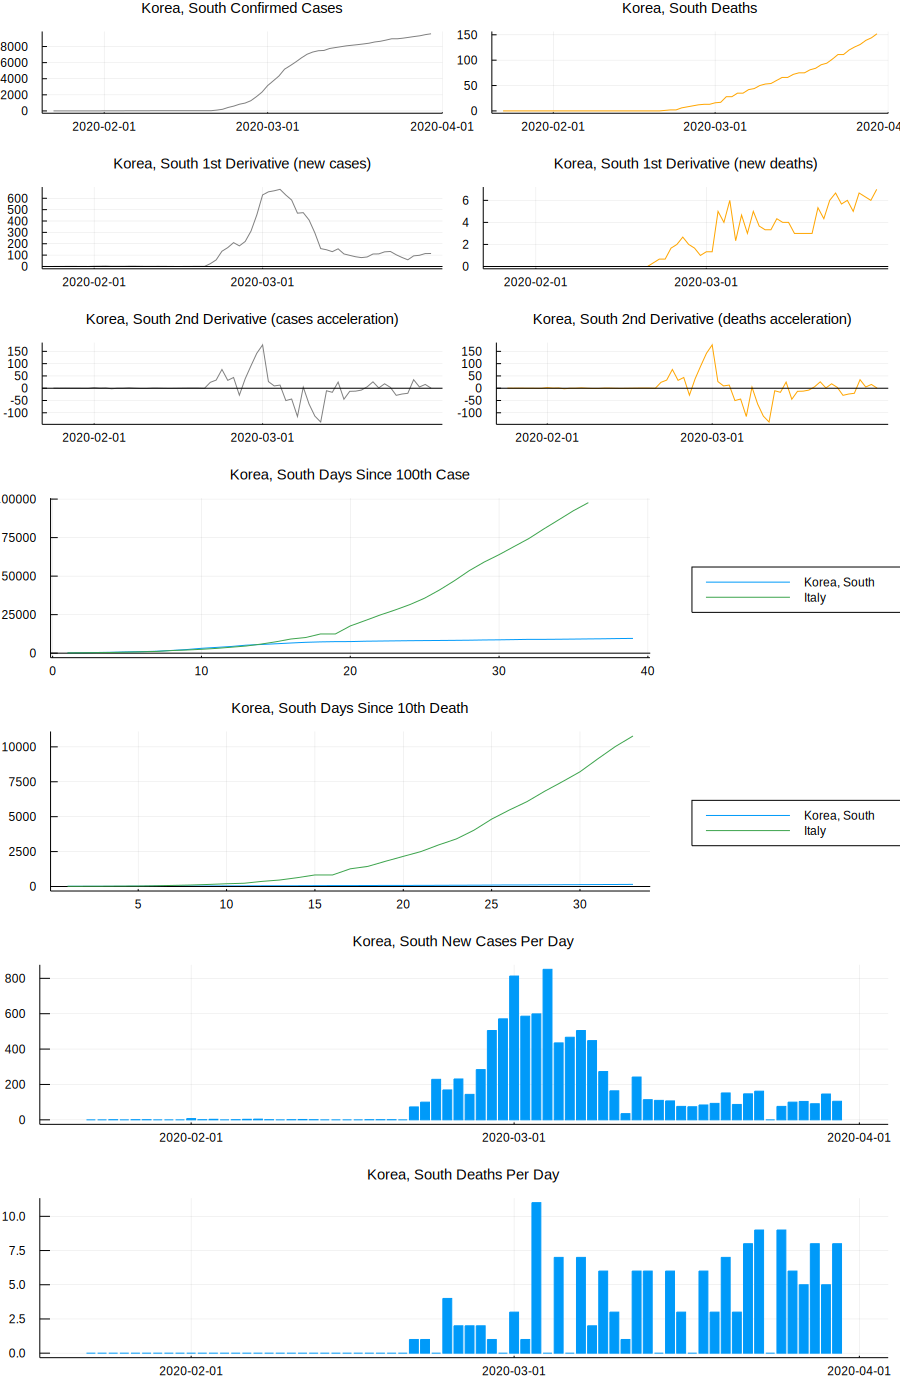

## Kosovo


  * Confirmed cases: 94
  * Deaths: 1
  * Death Rate: 1.06%


## Kuwait


  * Confirmed cases: 255
  * Deaths: 0
  * Death Rate: 0.0%


## Kyrgyzstan


  * Confirmed cases: 84
  * Deaths: 0
  * Death Rate: 0.0%


## Laos


  * Confirmed cases: 8
  * Deaths: 0
  * Death Rate: 0.0%


## Latvia


  * Confirmed cases: 347
  * Deaths: 0
  * Death Rate: 0.0%


## Lebanon


  * Confirmed cases: 438
  * Deaths: 10
  * Death Rate: 2.28%


## Liberia


  * Confirmed cases: 3
  * Deaths: 0
  * Death Rate: 0.0%


## Libya


  * Confirmed cases: 8
  * Deaths: 0
  * Death Rate: 0.0%


## Liechtenstein


  * Confirmed cases: 56
  * Deaths: 0
  * Death Rate: 0.0%


## Lithuania


  * Confirmed cases: 460
  * Deaths: 7
  * Death Rate: 1.52%


## Luxembourg


  * Confirmed cases: 1950
  * Deaths: 21
  * Death Rate: 1.08%


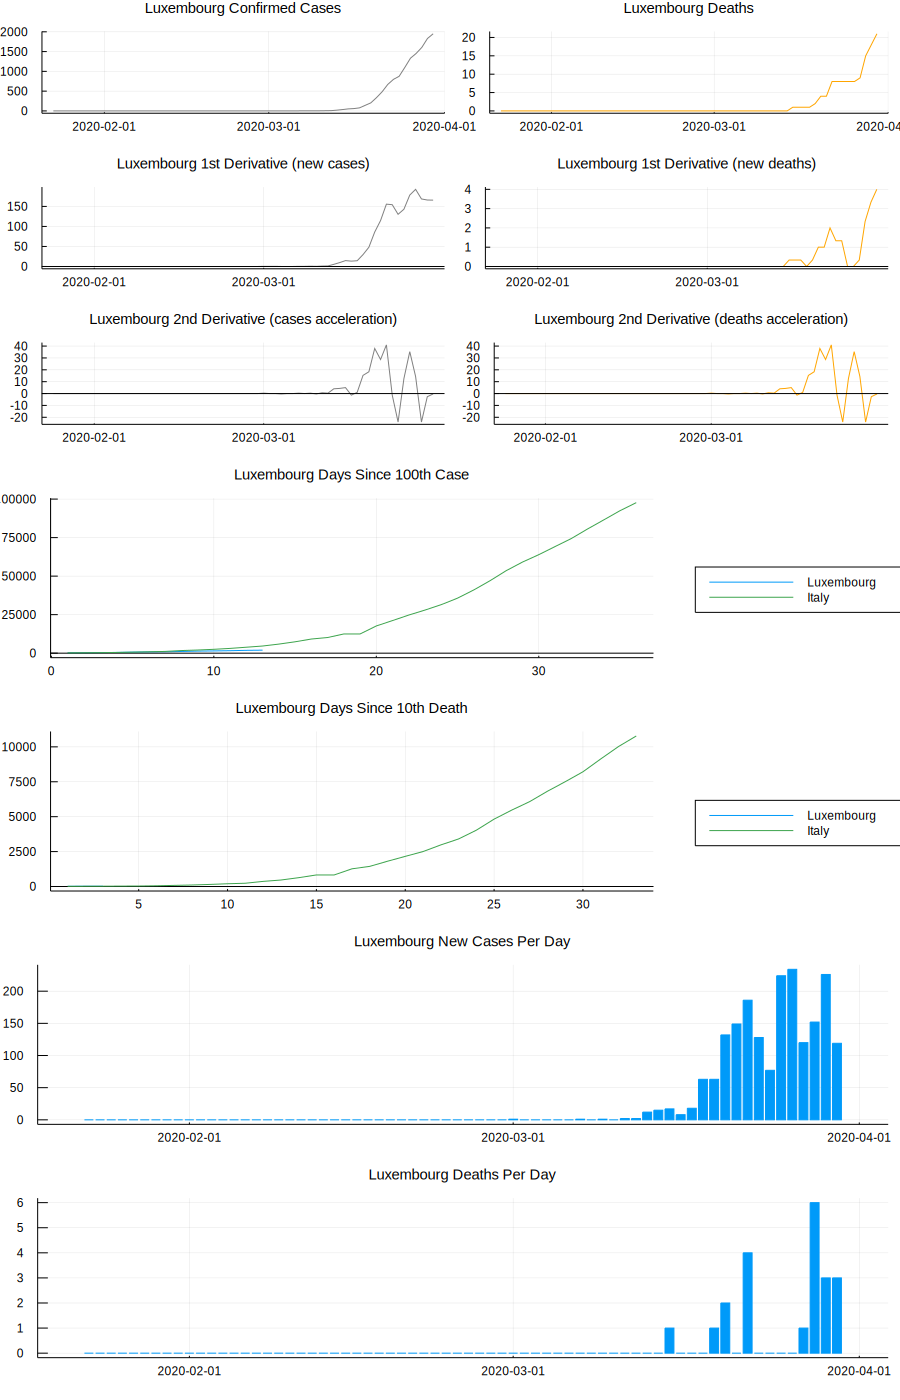

## MS Zaandam


  * Confirmed cases: 2
  * Deaths: 0
  * Death Rate: 0.0%


## Madagascar


  * Confirmed cases: 39
  * Deaths: 0
  * Death Rate: 0.0%


## Malaysia


  * Confirmed cases: 2470
  * Deaths: 35
  * Death Rate: 1.42%


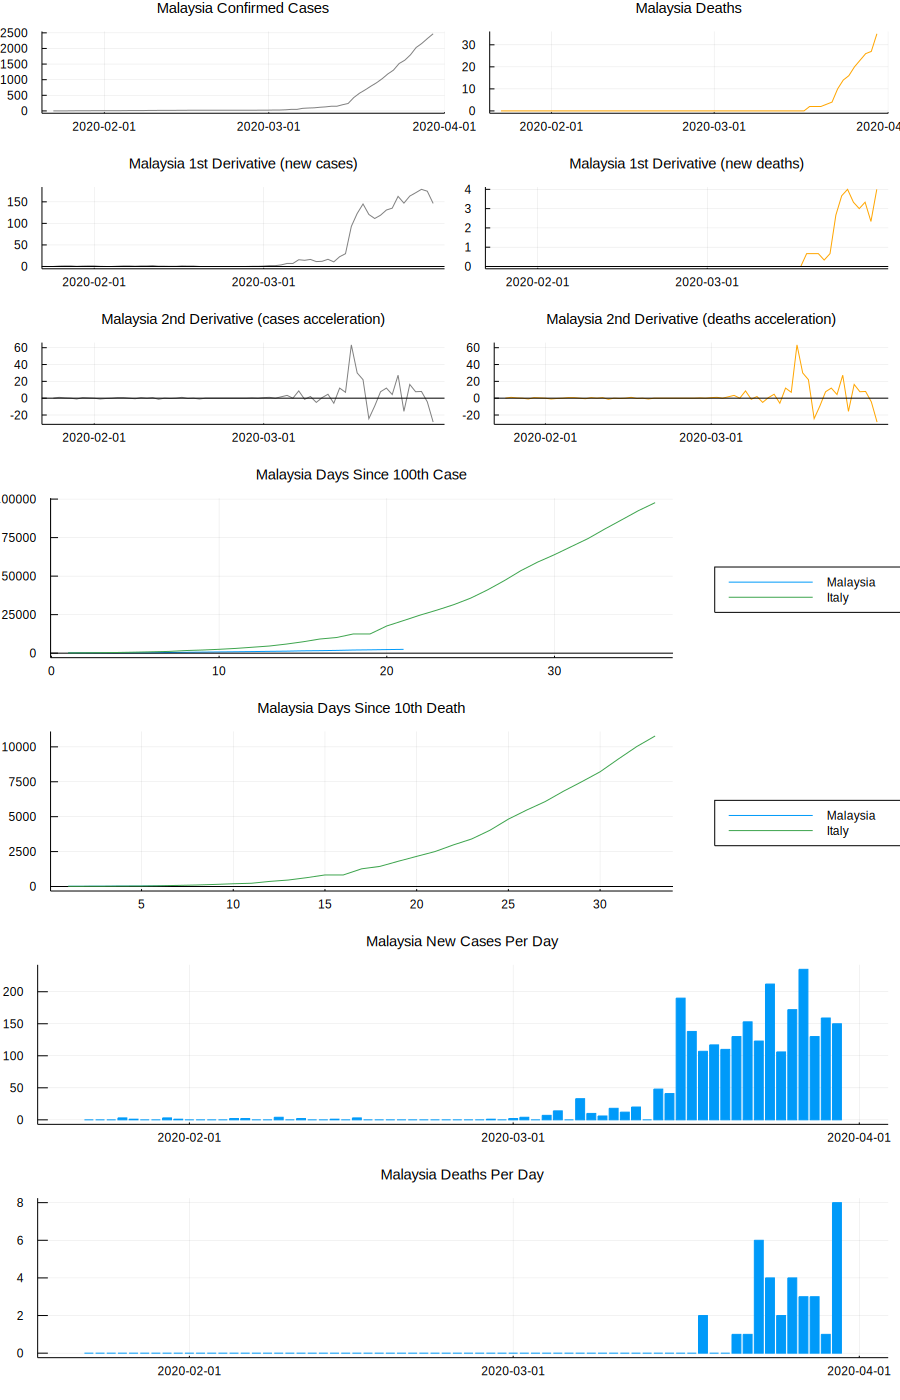

## Maldives


  * Confirmed cases: 17
  * Deaths: 0
  * Death Rate: 0.0%


## Mali


  * Confirmed cases: 18
  * Deaths: 1
  * Death Rate: 5.56%


## Malta


  * Confirmed cases: 151
  * Deaths: 0
  * Death Rate: 0.0%


## Mauritania


  * Confirmed cases: 5
  * Deaths: 0
  * Death Rate: 0.0%


## Mauritius


  * Confirmed cases: 107
  * Deaths: 3
  * Death Rate: 2.8%


## Mexico


  * Confirmed cases: 848
  * Deaths: 16
  * Death Rate: 1.89%


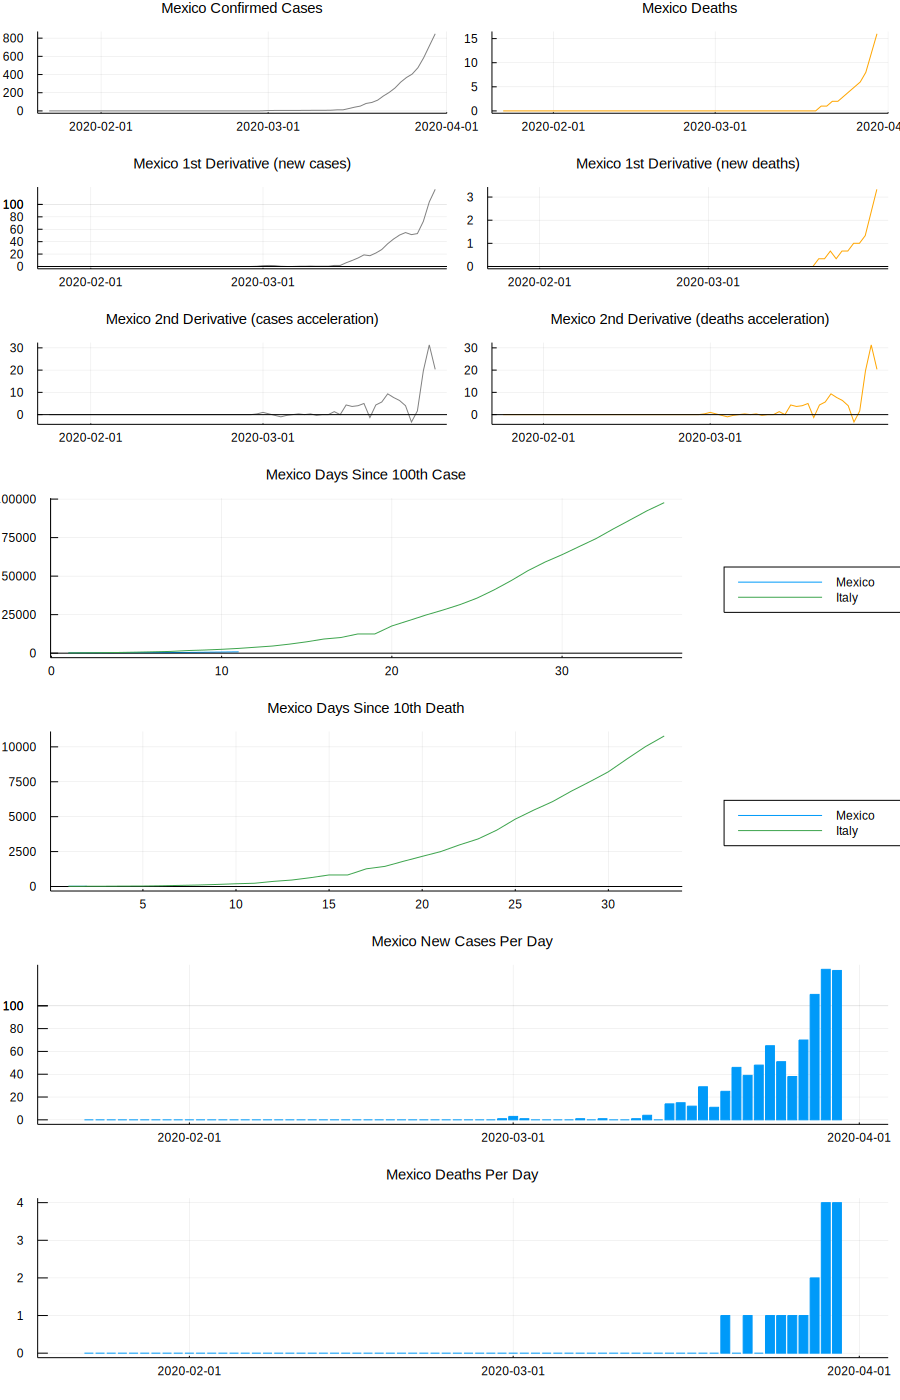

## Moldova


  * Confirmed cases: 263
  * Deaths: 2
  * Death Rate: 0.76%


## Monaco


  * Confirmed cases: 46
  * Deaths: 1
  * Death Rate: 2.17%


## Mongolia


  * Confirmed cases: 12
  * Deaths: 0
  * Death Rate: 0.0%


## Montenegro


  * Confirmed cases: 85
  * Deaths: 1
  * Death Rate: 1.18%


## Morocco


  * Confirmed cases: 479
  * Deaths: 26
  * Death Rate: 5.43%


## Mozambique


  * Confirmed cases: 8
  * Deaths: 0
  * Death Rate: 0.0%


## Namibia


  * Confirmed cases: 11
  * Deaths: 0
  * Death Rate: 0.0%


## Nepal


  * Confirmed cases: 5
  * Deaths: 0
  * Death Rate: 0.0%


## Netherlands


  * Confirmed cases: 10930
  * Deaths: 772
  * Death Rate: 7.06%


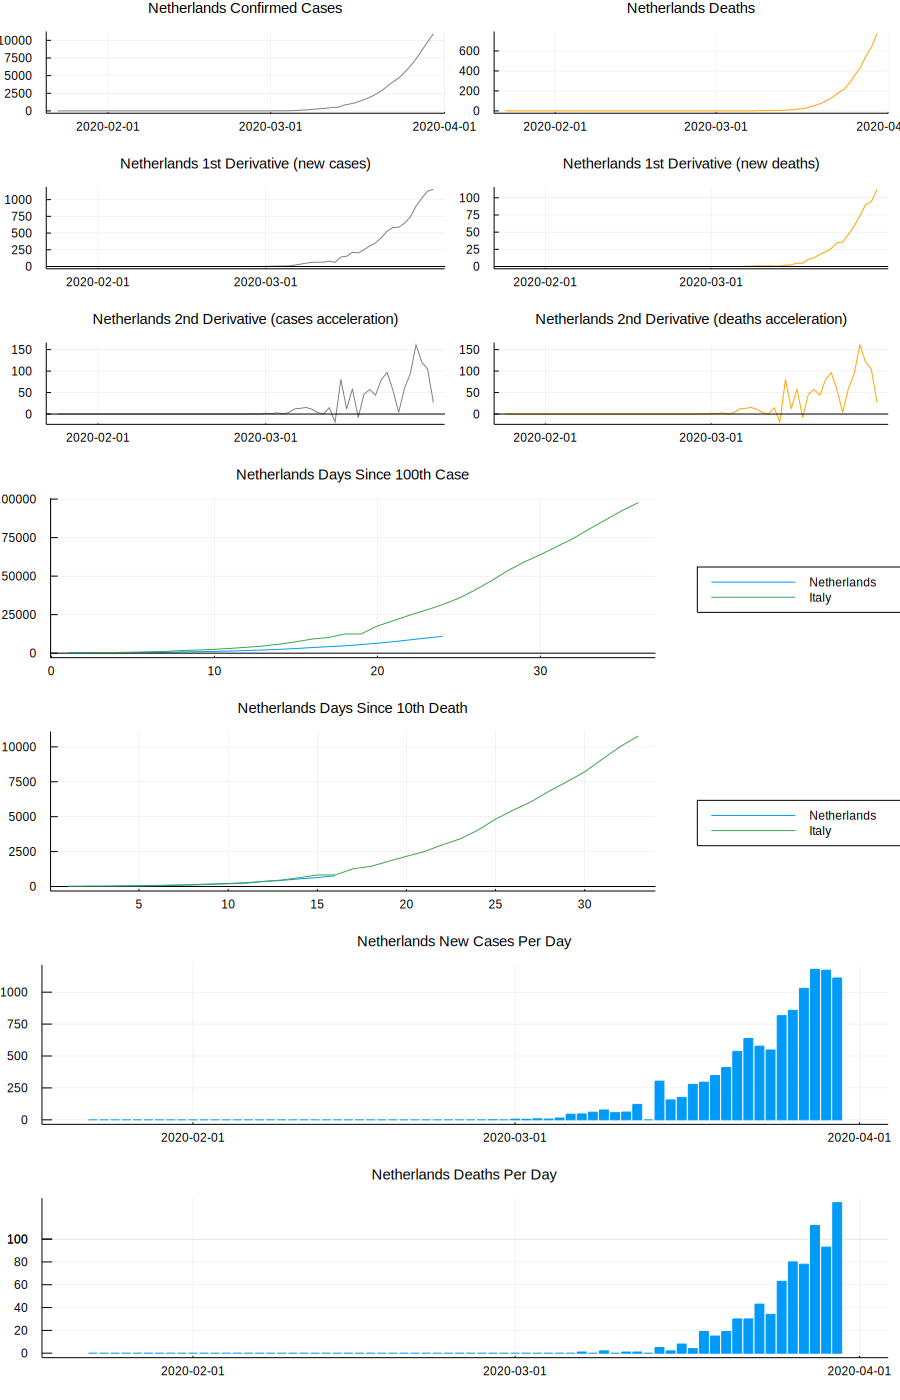

## New Zealand


  * Confirmed cases: 514
  * Deaths: 1
  * Death Rate: 0.19%


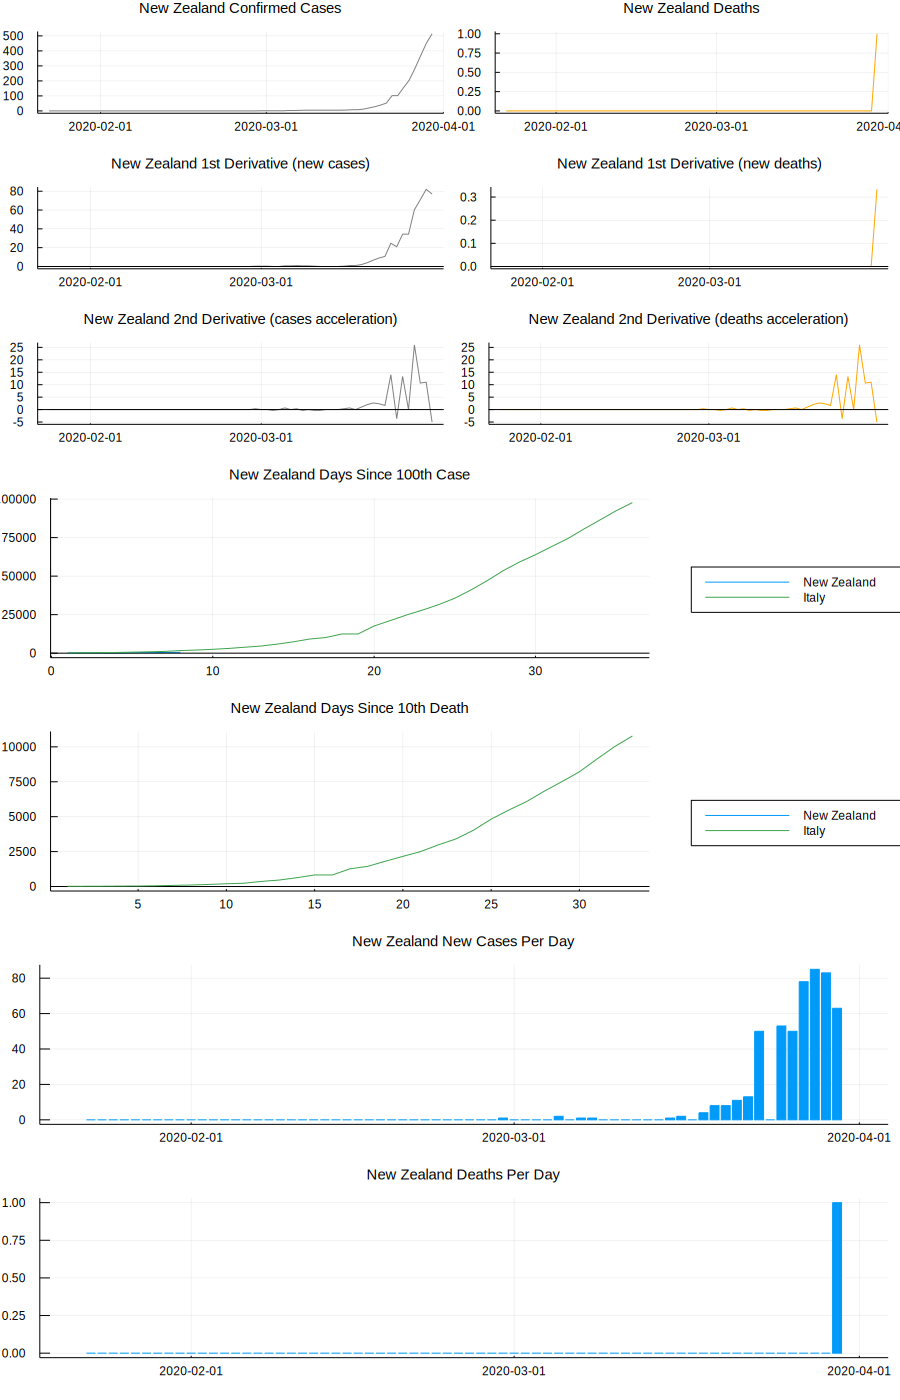

## Nicaragua


  * Confirmed cases: 4
  * Deaths: 1
  * Death Rate: 25.0%


## Niger


  * Confirmed cases: 18
  * Deaths: 1
  * Death Rate: 5.56%


## Nigeria


  * Confirmed cases: 111
  * Deaths: 1
  * Death Rate: 0.9%


## North Macedonia


  * Confirmed cases: 259
  * Deaths: 6
  * Death Rate: 2.32%


## Norway


  * Confirmed cases: 4284
  * Deaths: 25
  * Death Rate: 0.58%


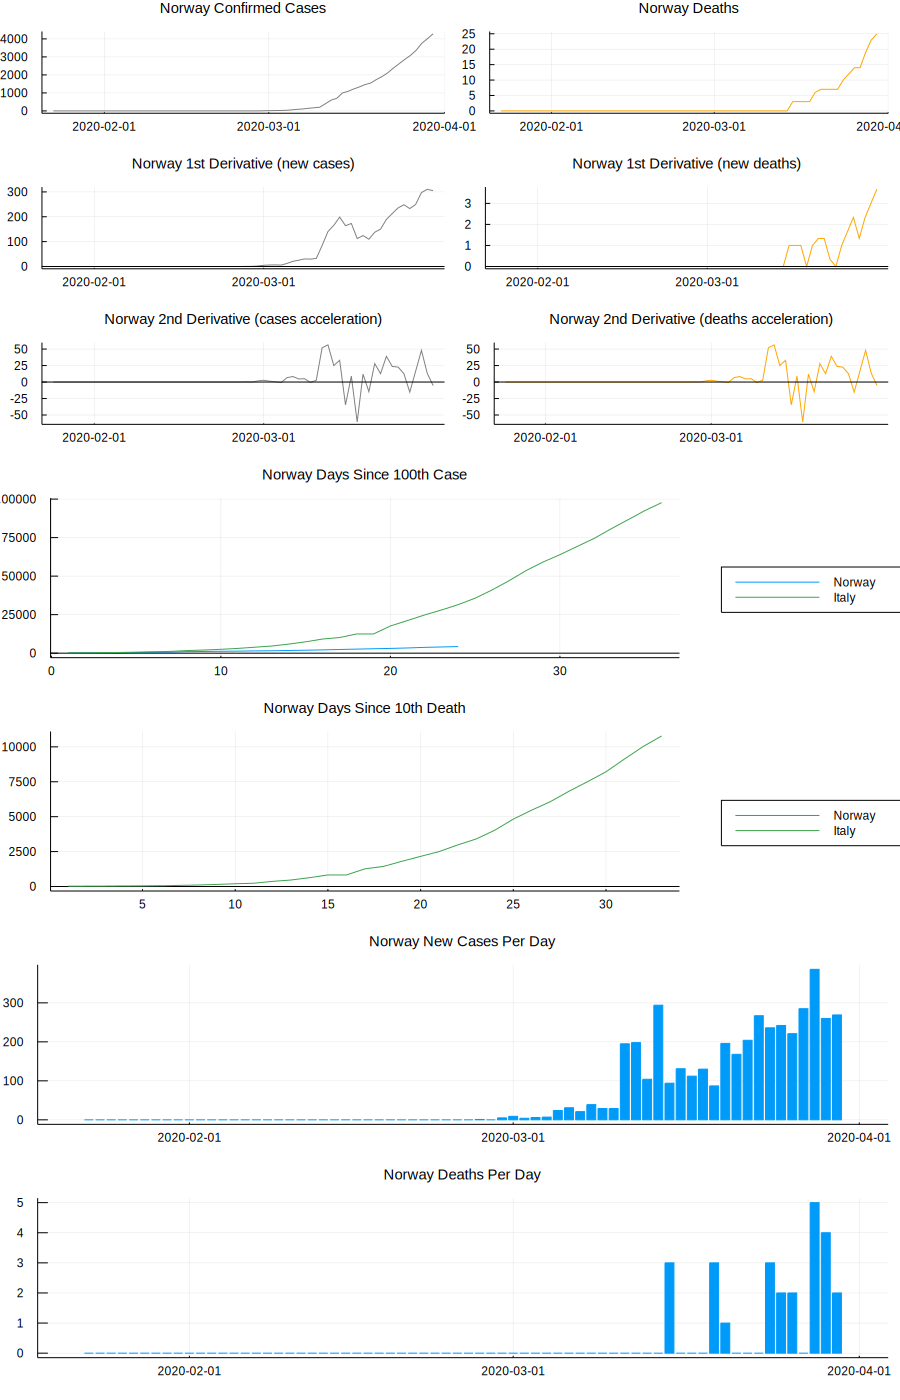

## Oman


  * Confirmed cases: 167
  * Deaths: 0
  * Death Rate: 0.0%


## Pakistan


  * Confirmed cases: 1597
  * Deaths: 14
  * Death Rate: 0.88%


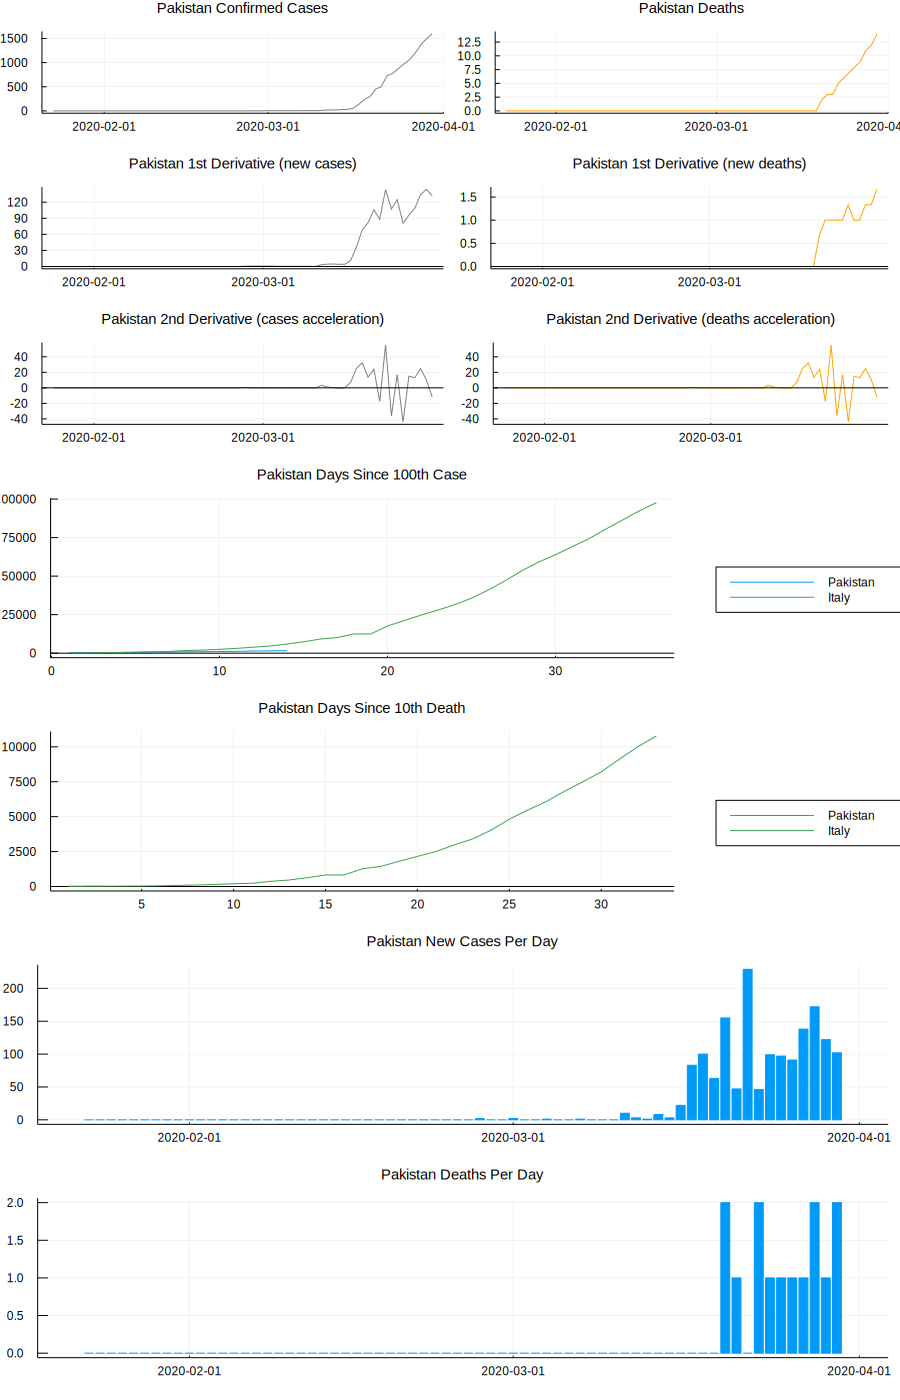

## Panama


  * Confirmed cases: 901
  * Deaths: 17
  * Death Rate: 1.89%


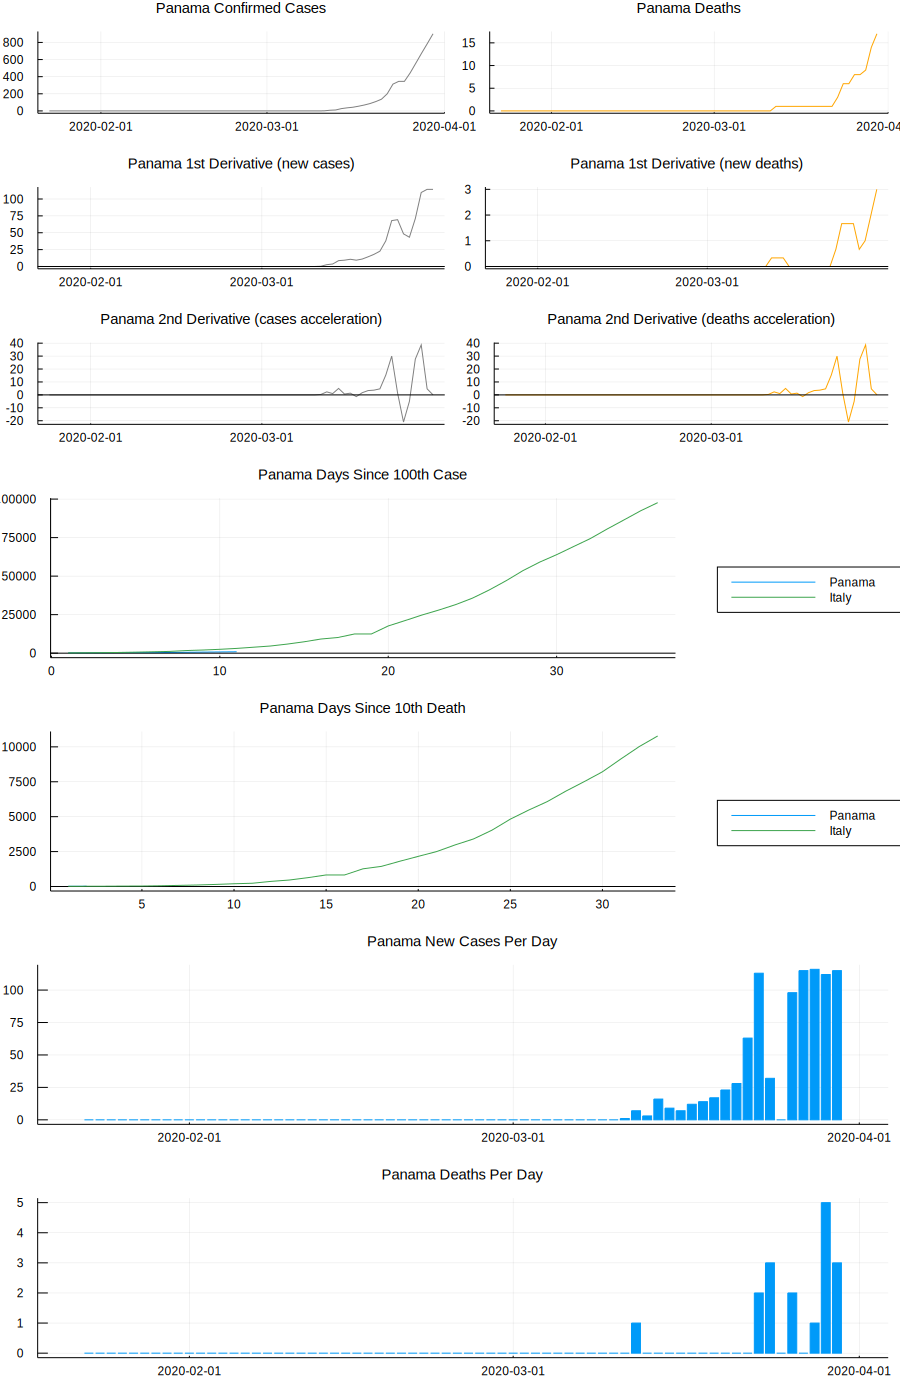

## Papua New Guinea


  * Confirmed cases: 1
  * Deaths: 0
  * Death Rate: 0.0%


## Paraguay


  * Confirmed cases: 59
  * Deaths: 3
  * Death Rate: 5.08%


## Peru


  * Confirmed cases: 852
  * Deaths: 18
  * Death Rate: 2.11%


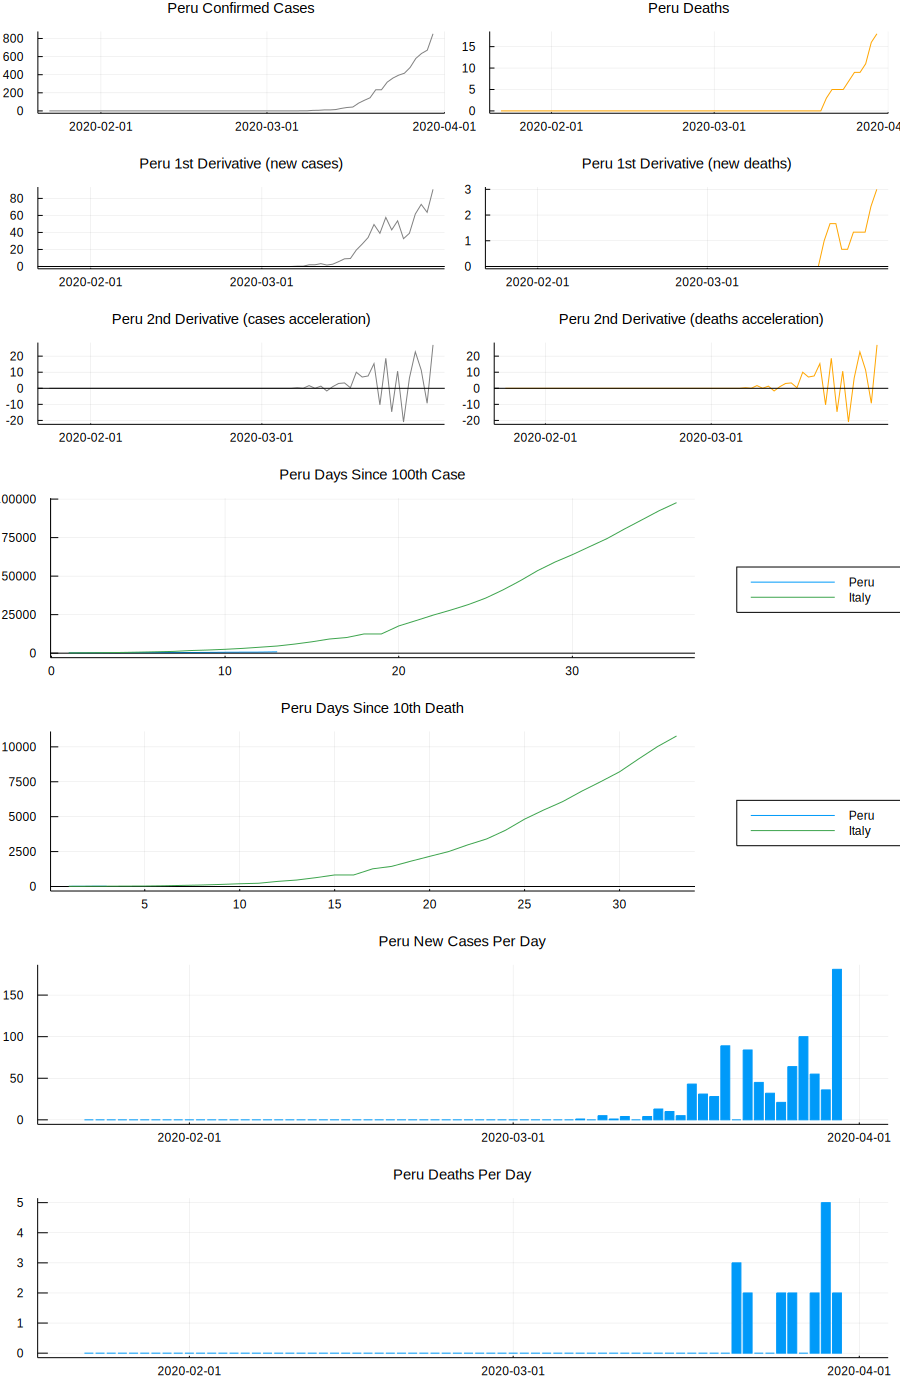

## Philippines


  * Confirmed cases: 1418
  * Deaths: 71
  * Death Rate: 5.01%


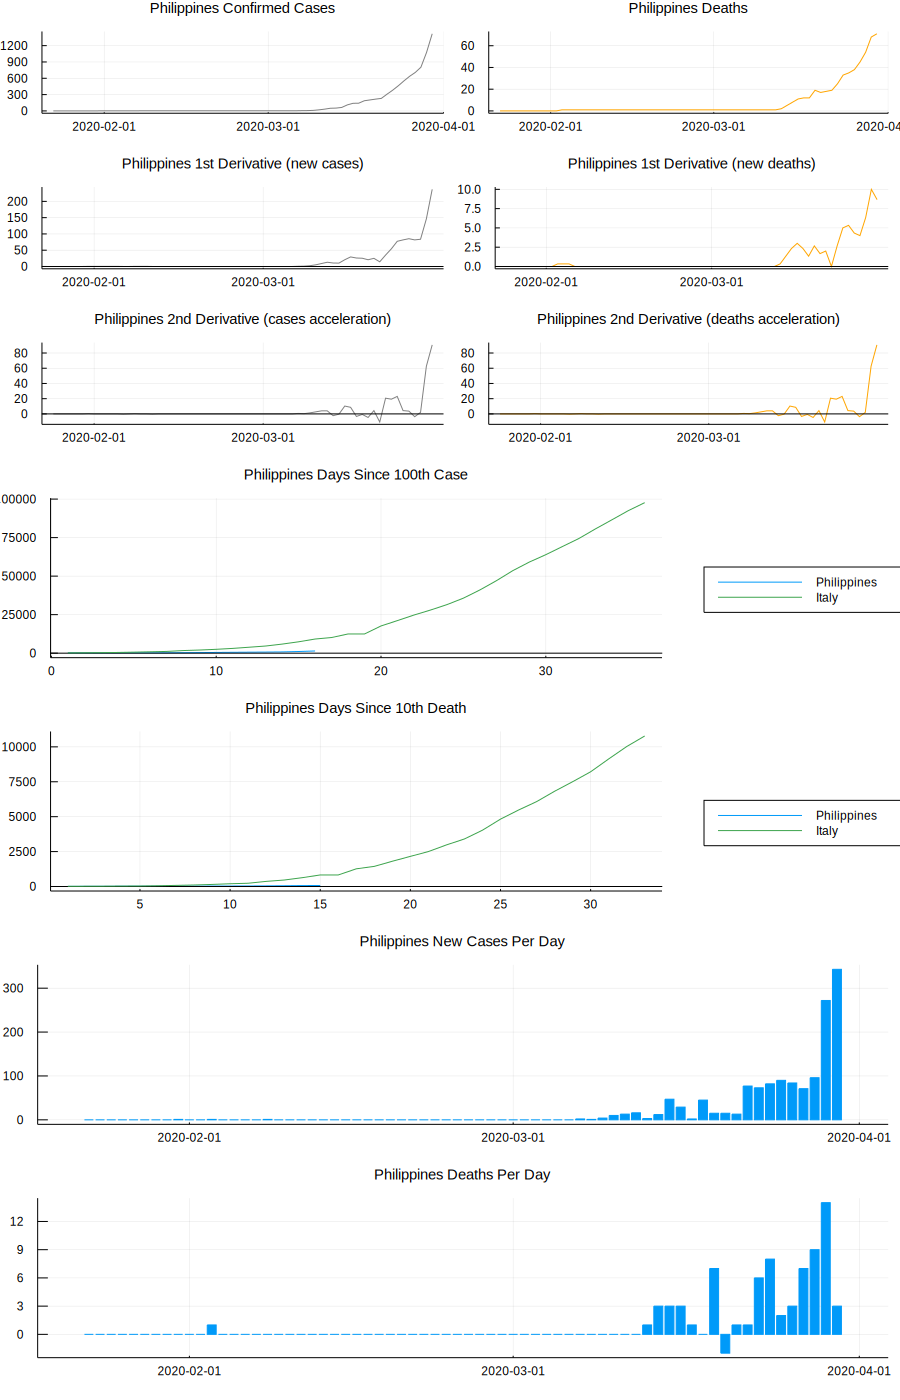

## Poland


  * Confirmed cases: 1862
  * Deaths: 22
  * Death Rate: 1.18%


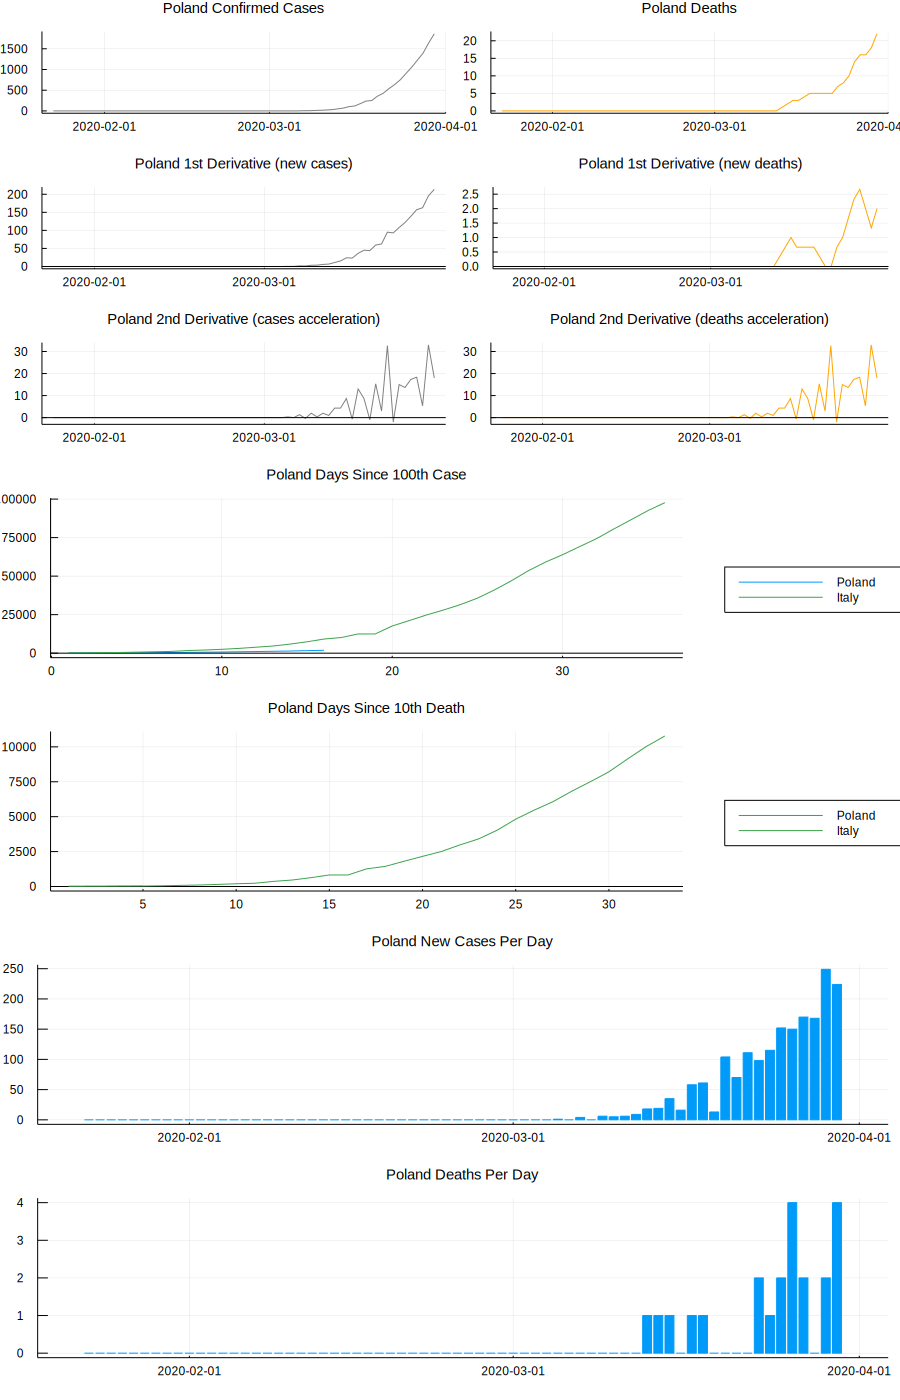

## Portugal


  * Confirmed cases: 5962
  * Deaths: 119
  * Death Rate: 2.0%


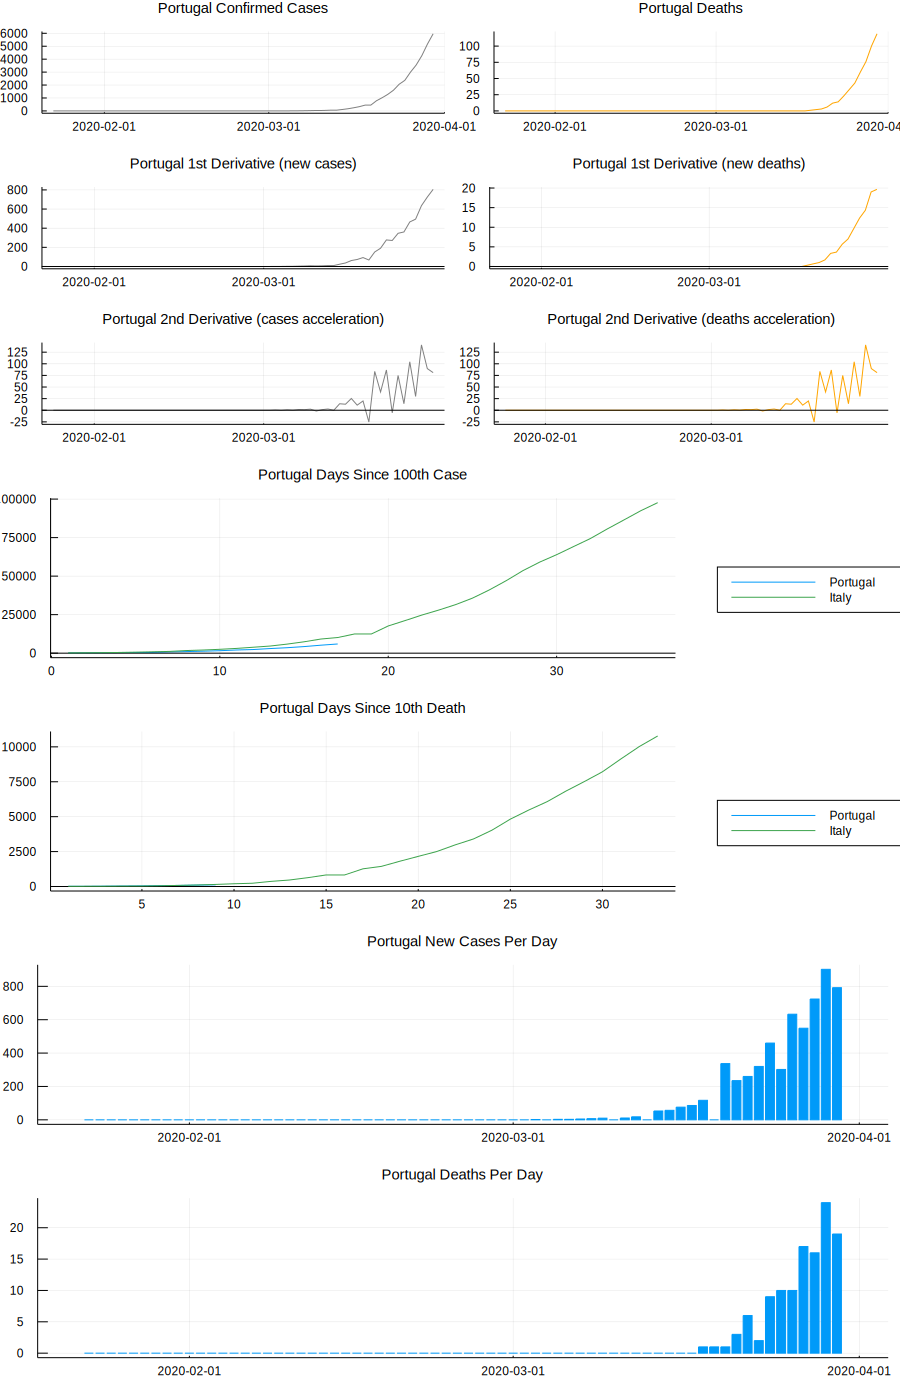

## Qatar


  * Confirmed cases: 634
  * Deaths: 1
  * Death Rate: 0.16%


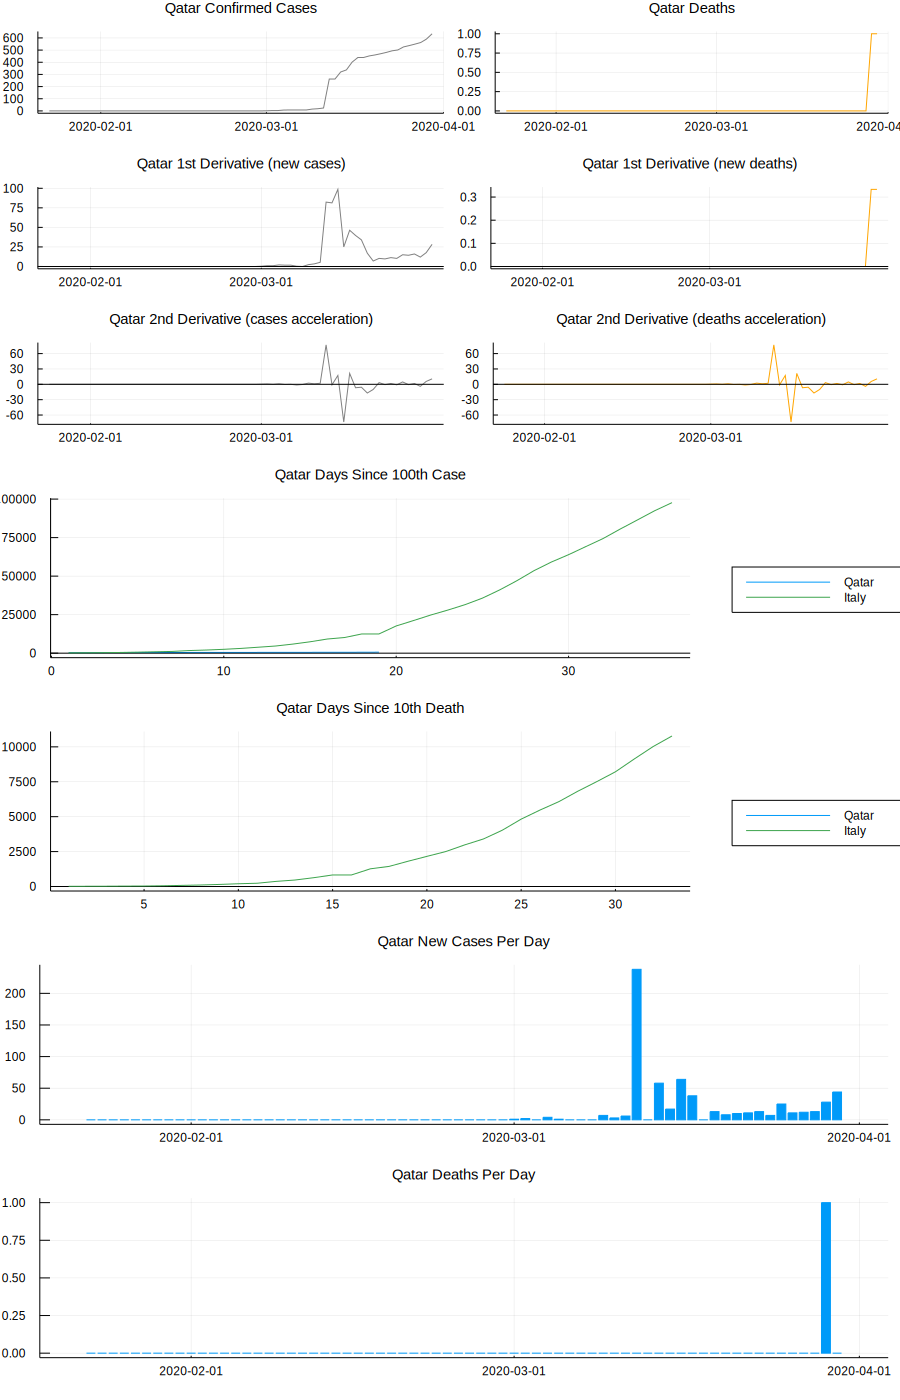

## Romania


  * Confirmed cases: 1815
  * Deaths: 43
  * Death Rate: 2.37%


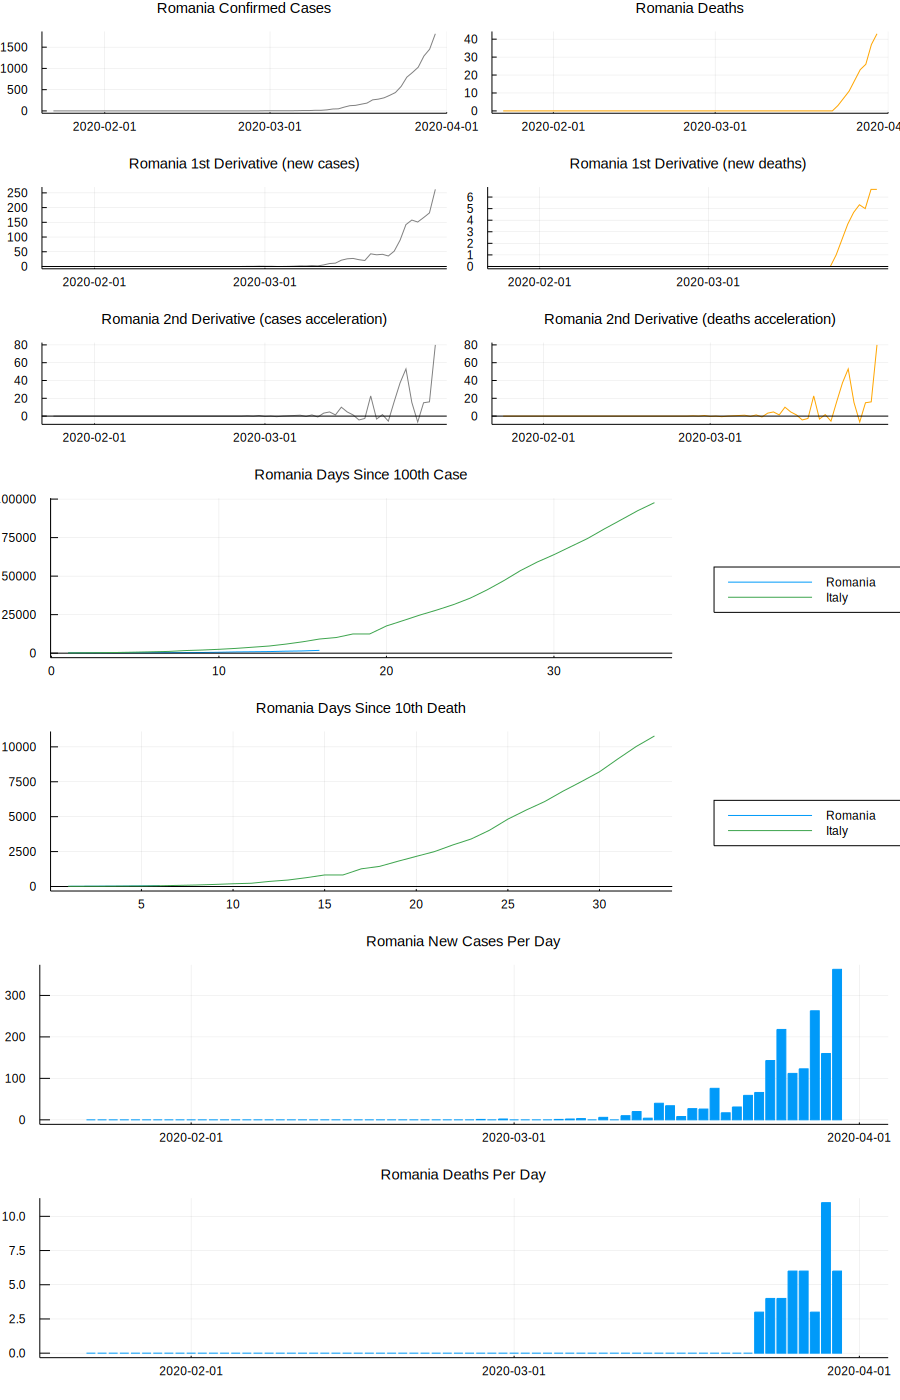

## Russia


  * Confirmed cases: 1534
  * Deaths: 8
  * Death Rate: 0.52%


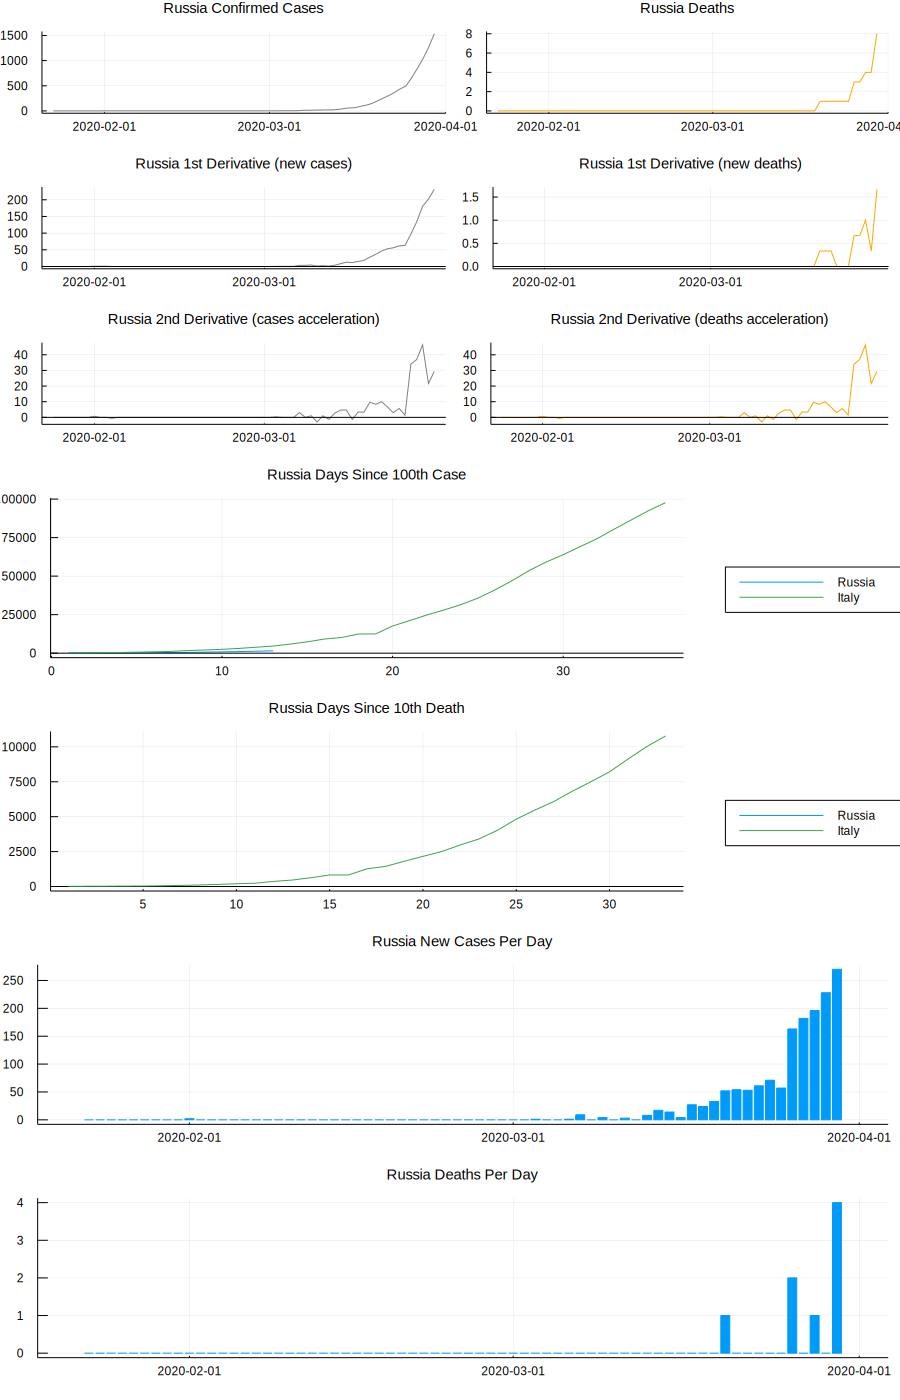

## Rwanda


  * Confirmed cases: 70
  * Deaths: 0
  * Death Rate: 0.0%


## Saint Kitts and Nevis


  * Confirmed cases: 2
  * Deaths: 0
  * Death Rate: 0.0%


## Saint Lucia


  * Confirmed cases: 9
  * Deaths: 0
  * Death Rate: 0.0%


## Saint Vincent and the Grenadines


  * Confirmed cases: 1
  * Deaths: 0
  * Death Rate: 0.0%


## San Marino


  * Confirmed cases: 224
  * Deaths: 22
  * Death Rate: 9.82%


## Saudi Arabia


  * Confirmed cases: 1299
  * Deaths: 8
  * Death Rate: 0.62%


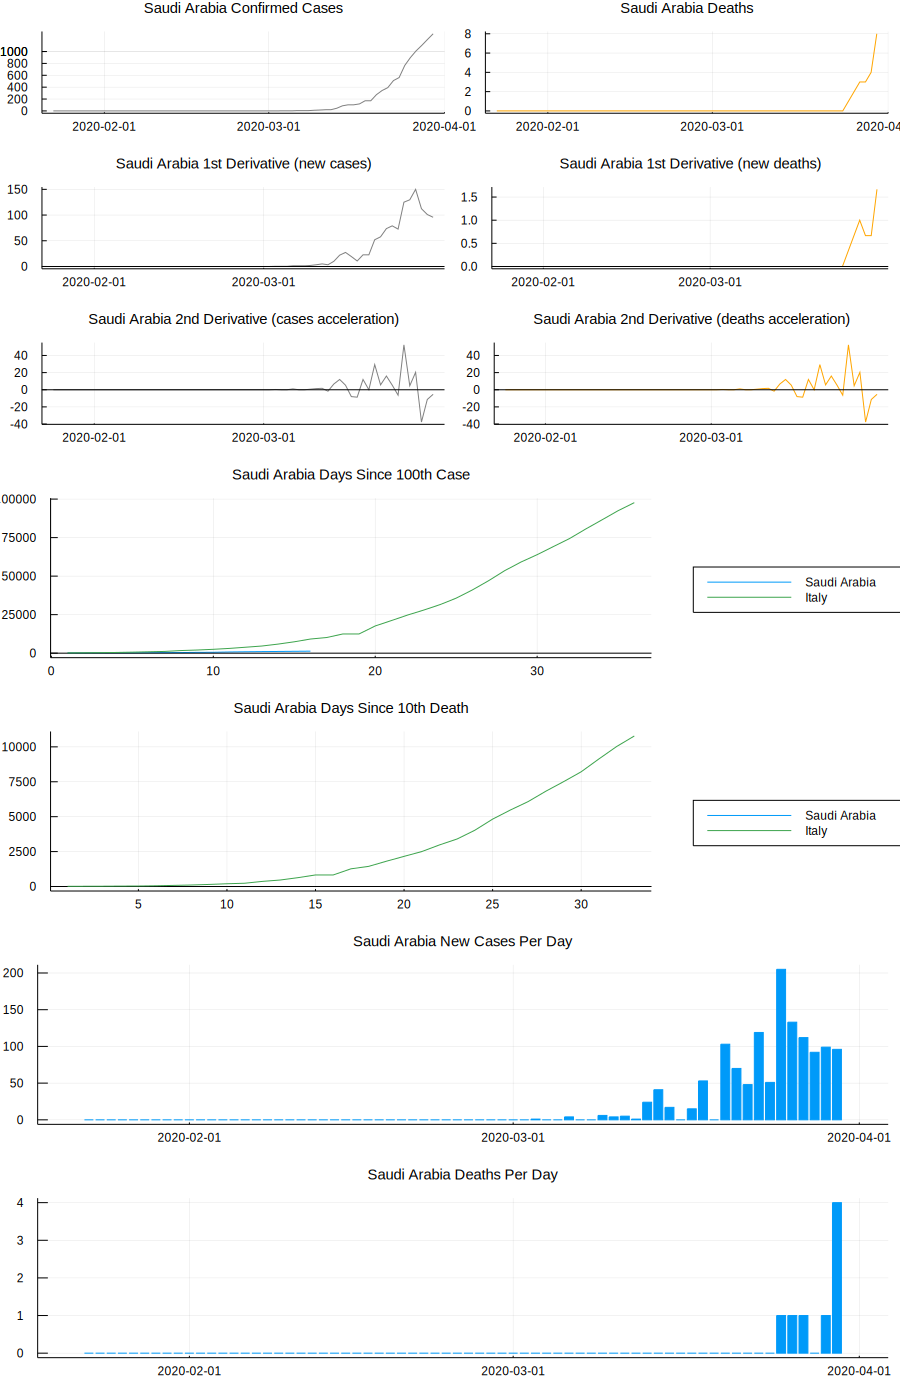

## Senegal


  * Confirmed cases: 142
  * Deaths: 0
  * Death Rate: 0.0%


## Serbia


  * Confirmed cases: 741
  * Deaths: 13
  * Death Rate: 1.75%


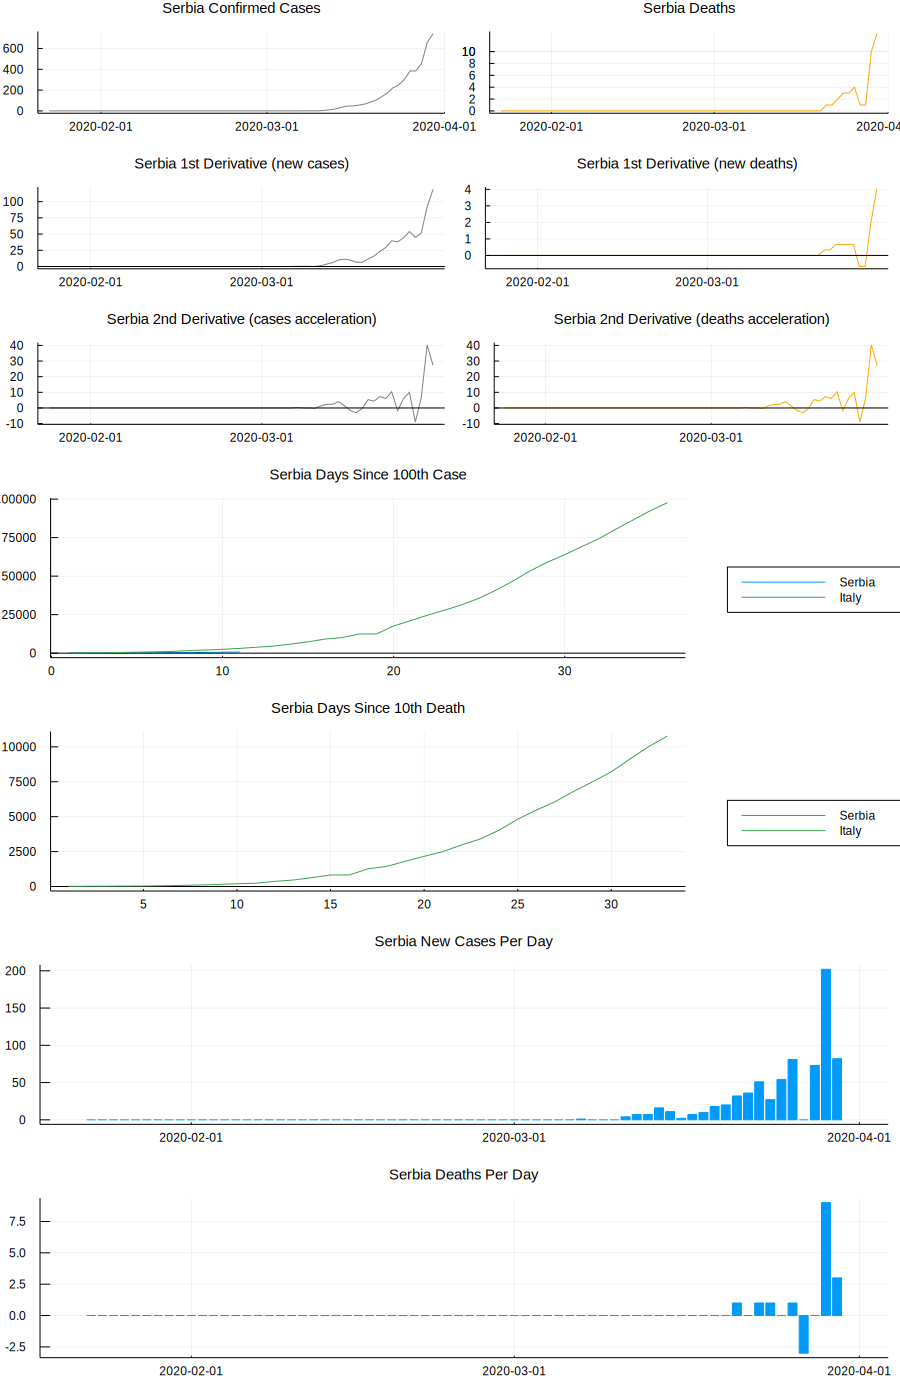

## Seychelles


  * Confirmed cases: 8
  * Deaths: 0
  * Death Rate: 0.0%


## Singapore


  * Confirmed cases: 844
  * Deaths: 3
  * Death Rate: 0.36%


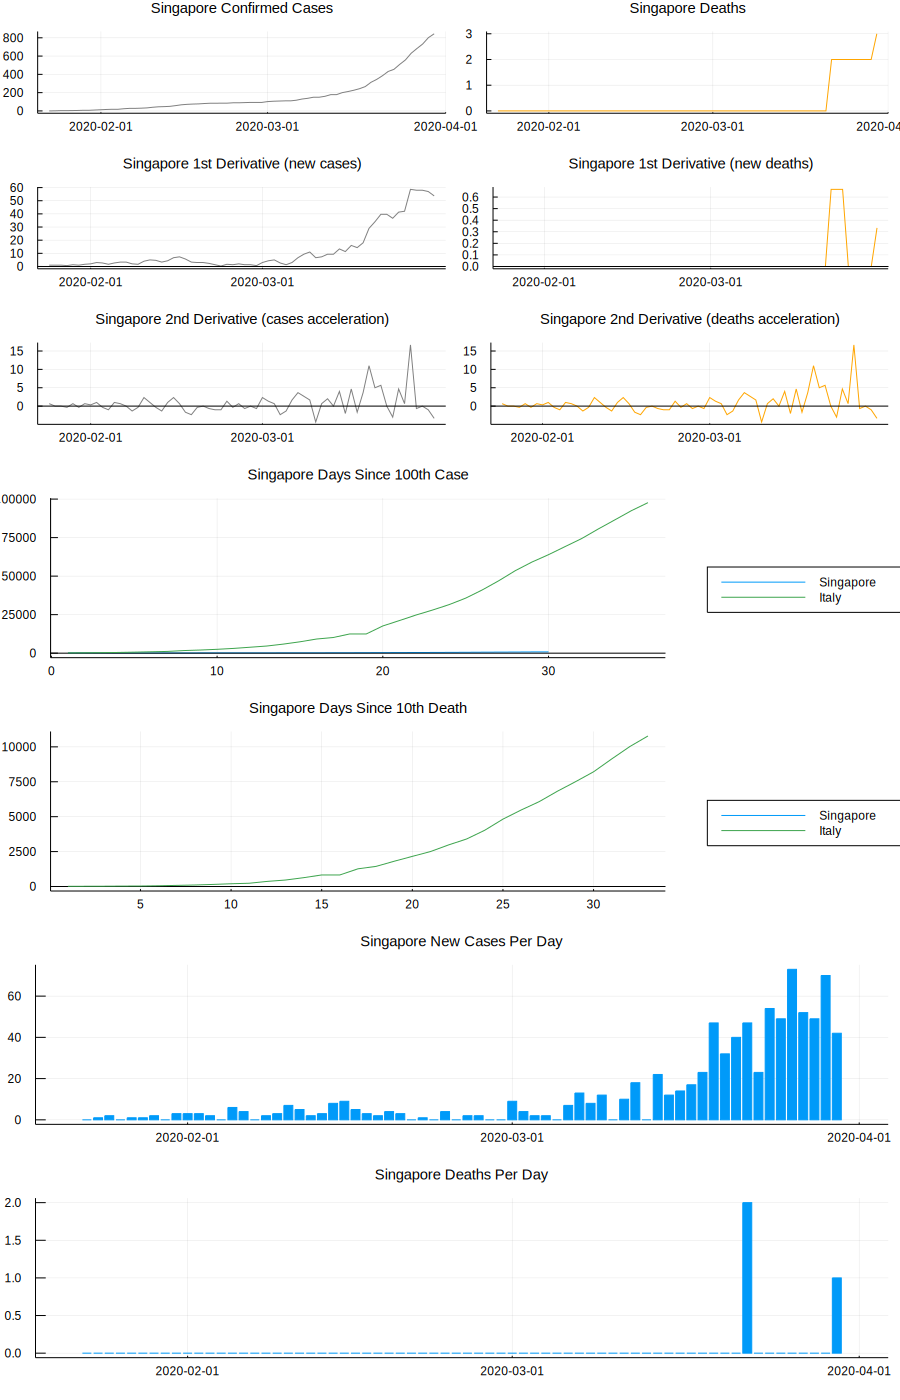

## Slovakia


  * Confirmed cases: 314
  * Deaths: 1
  * Death Rate: 0.32%


## Slovenia


  * Confirmed cases: 730
  * Deaths: 11
  * Death Rate: 1.51%


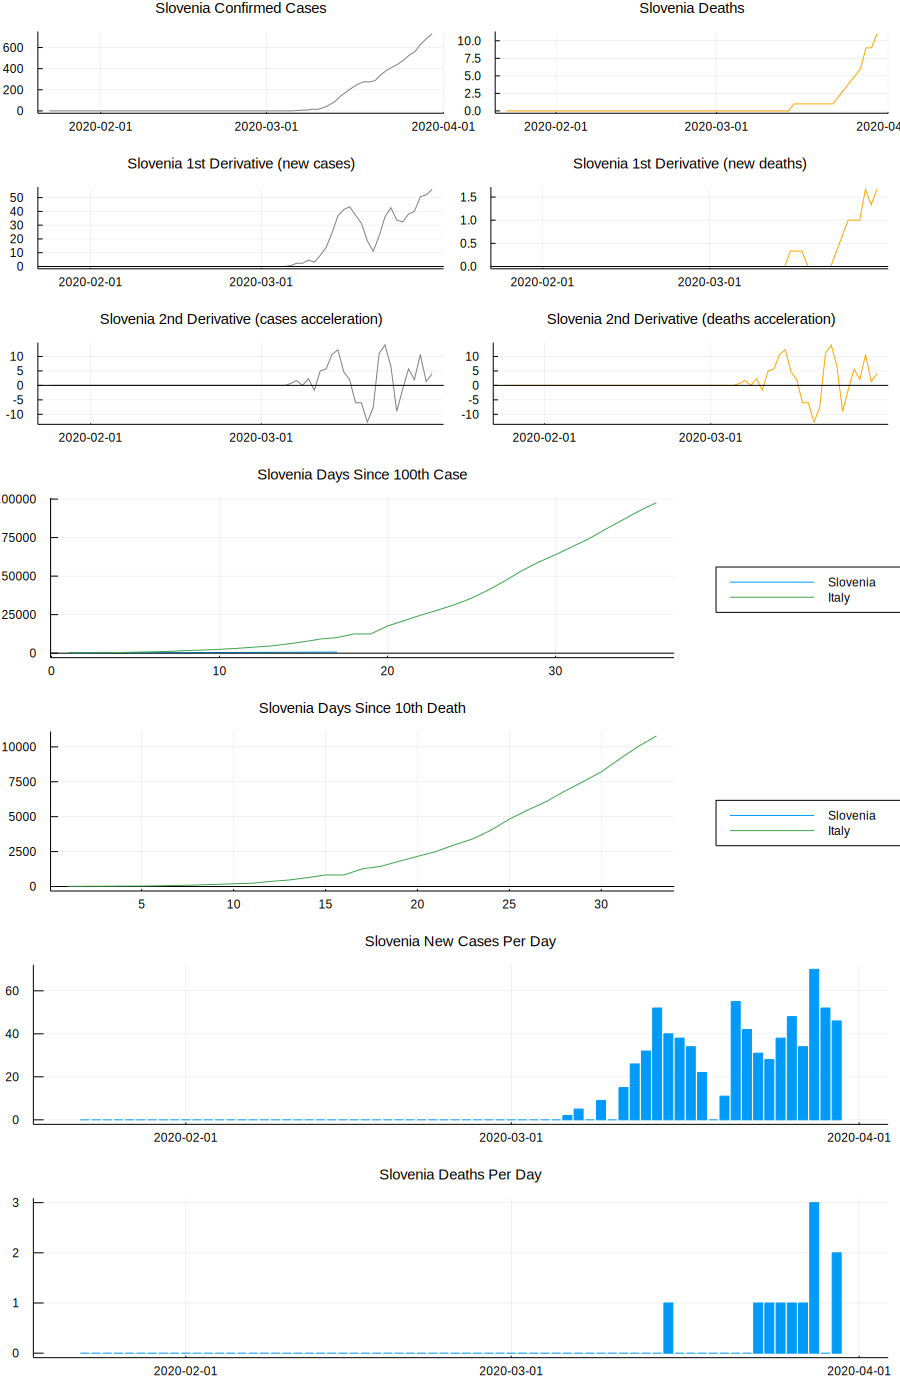

## Somalia


  * Confirmed cases: 3
  * Deaths: 0
  * Death Rate: 0.0%


## South Africa


  * Confirmed cases: 1280
  * Deaths: 2
  * Death Rate: 0.16%


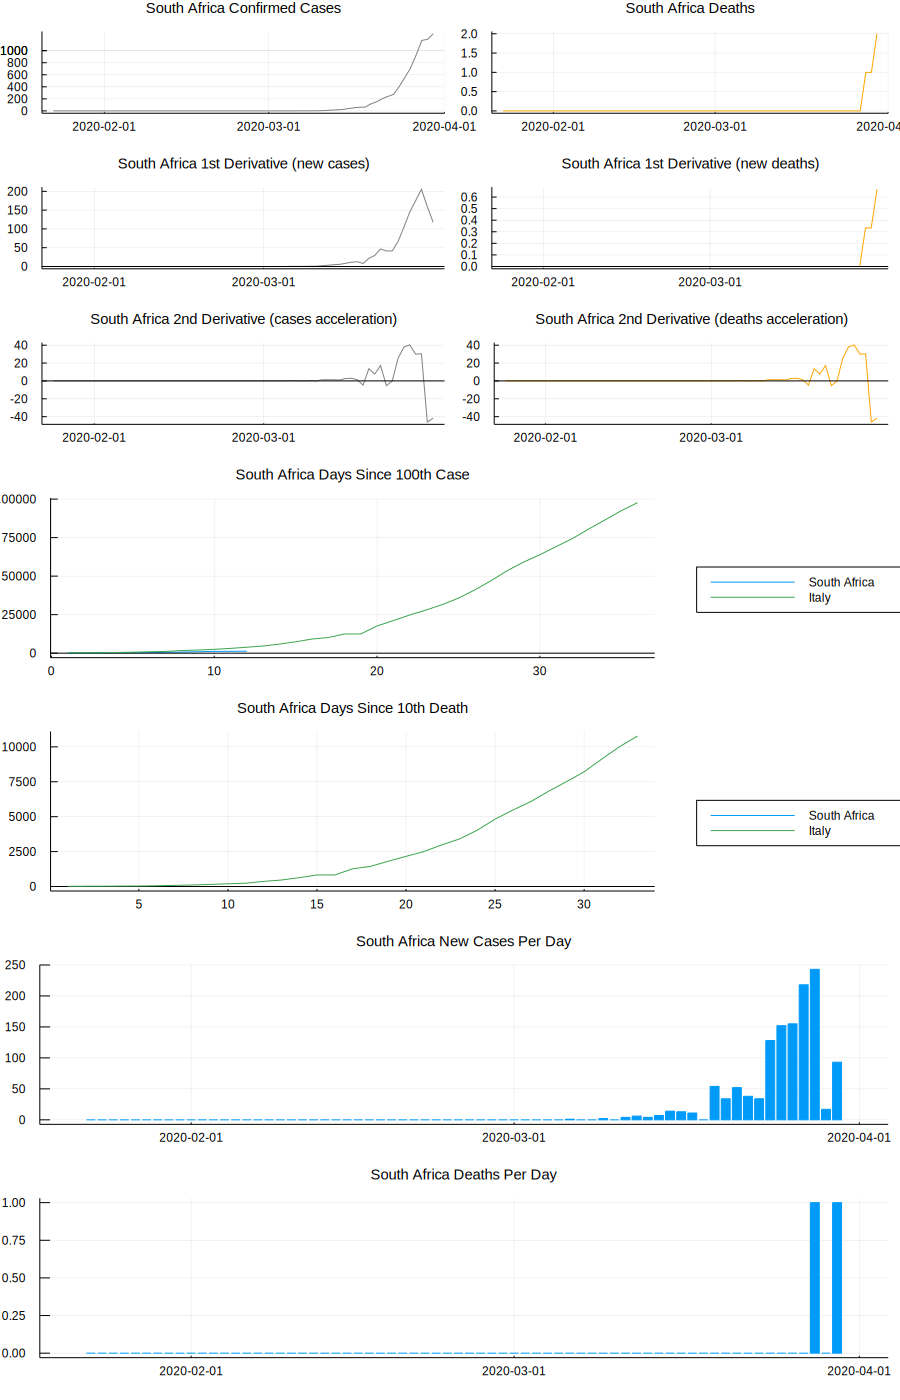

## Spain


  * Confirmed cases: 80110
  * Deaths: 6803
  * Death Rate: 8.49%


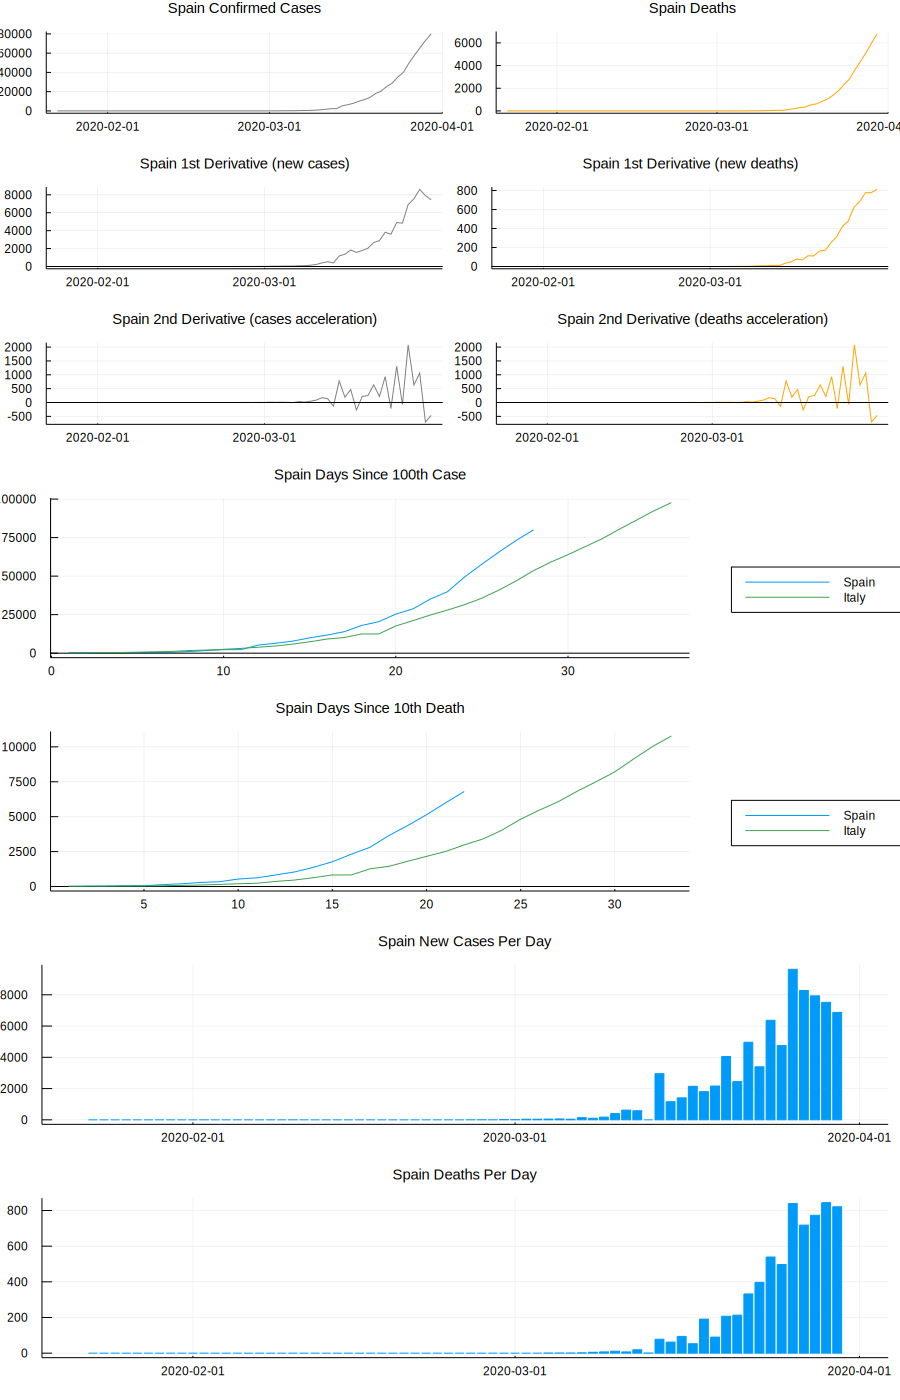

## Sri Lanka


  * Confirmed cases: 117
  * Deaths: 1
  * Death Rate: 0.85%


## Sudan


  * Confirmed cases: 6
  * Deaths: 1
  * Death Rate: 16.67%


## Suriname


  * Confirmed cases: 8
  * Deaths: 0
  * Death Rate: 0.0%


## Sweden


  * Confirmed cases: 3700
  * Deaths: 110
  * Death Rate: 2.97%


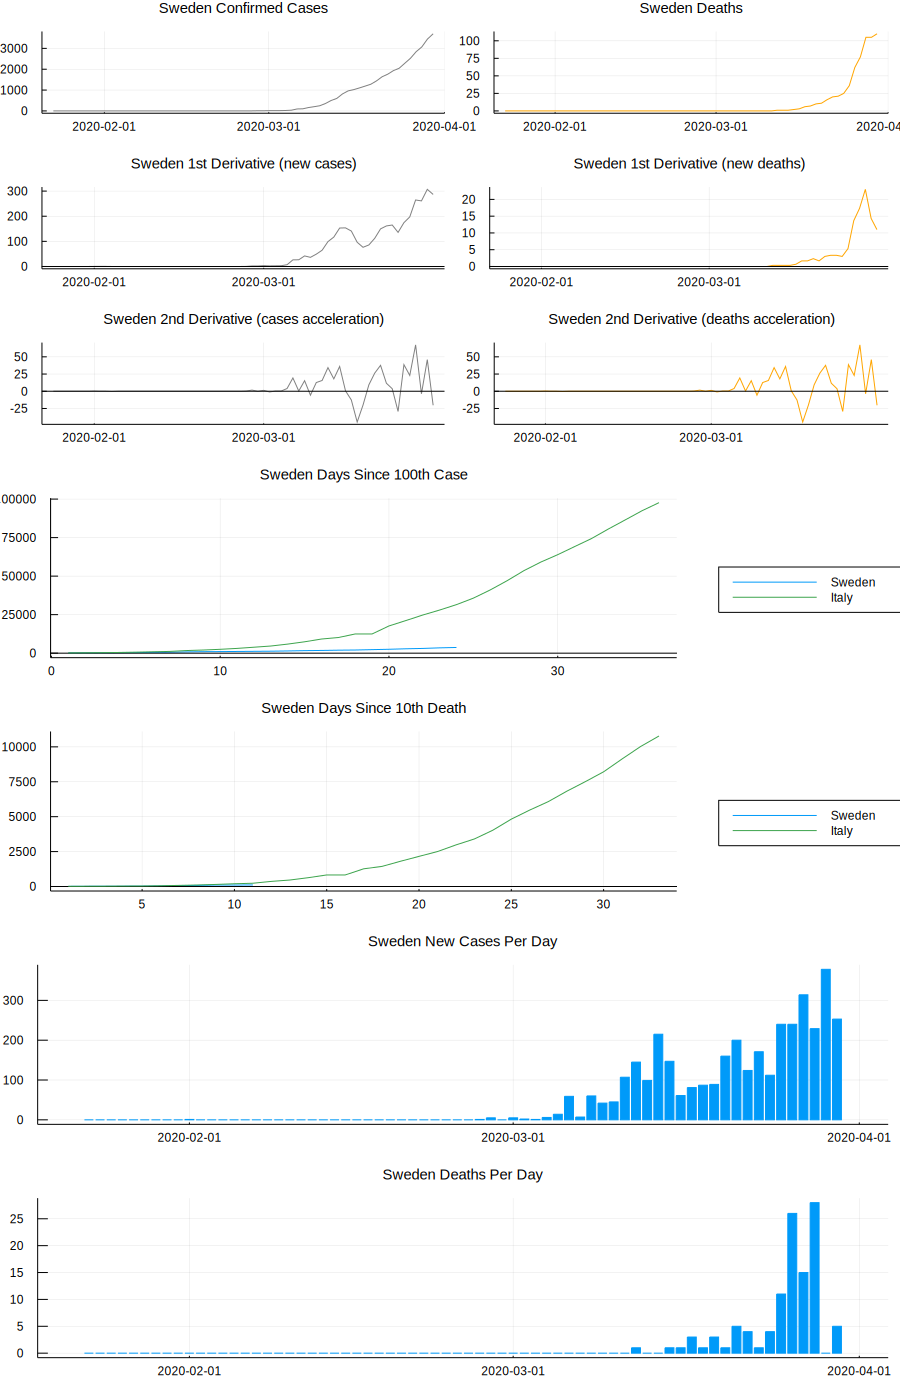

## Switzerland


  * Confirmed cases: 14829
  * Deaths: 300
  * Death Rate: 2.02%


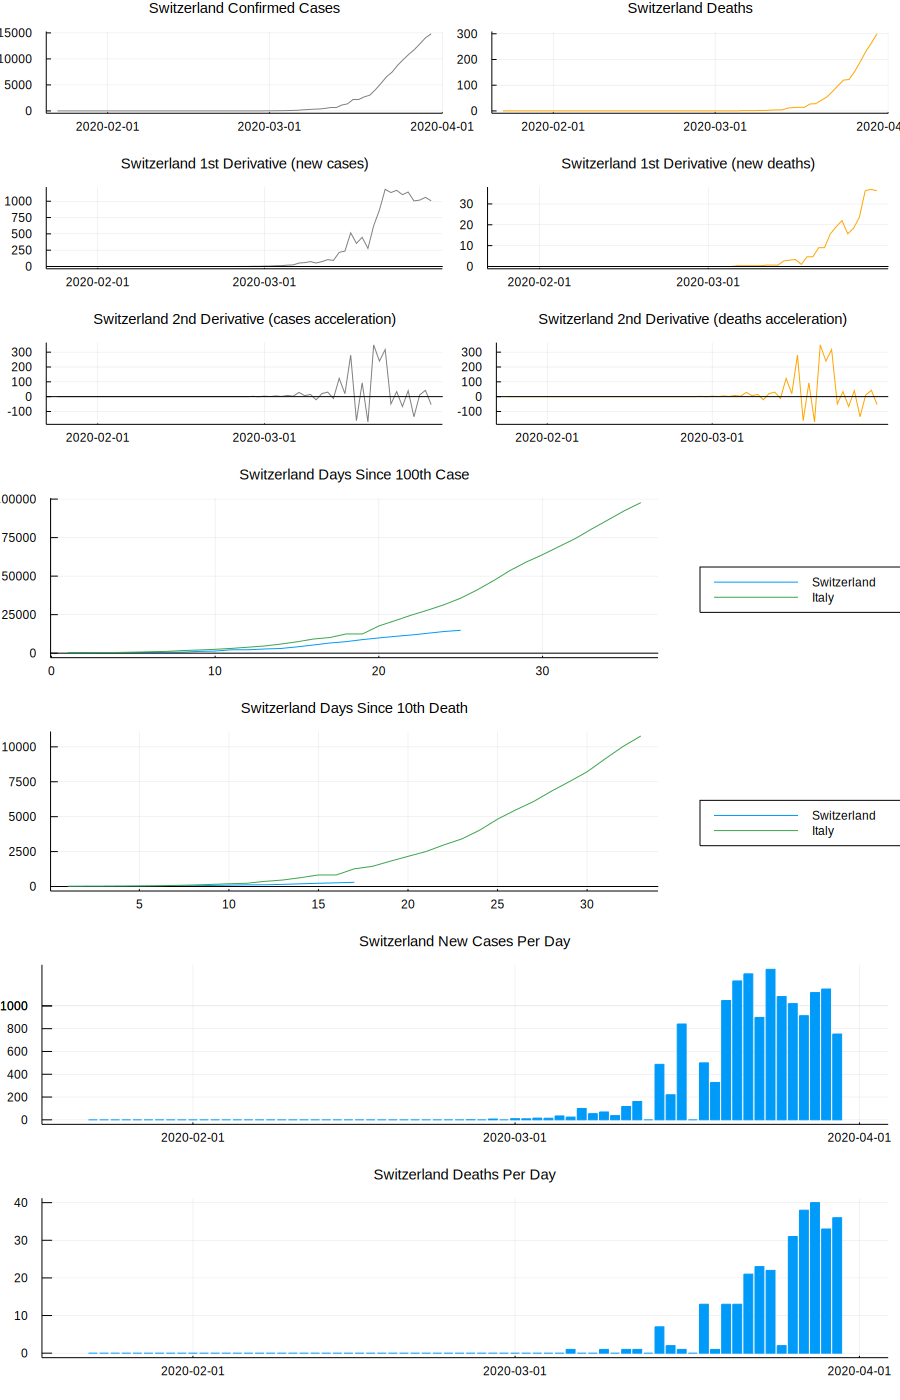

## Syria


  * Confirmed cases: 9
  * Deaths: 1
  * Death Rate: 11.11%


## Taiwan*


  * Confirmed cases: 298
  * Deaths: 2
  * Death Rate: 0.67%


## Tanzania


  * Confirmed cases: 14
  * Deaths: 0
  * Death Rate: 0.0%


## Thailand


  * Confirmed cases: 1388
  * Deaths: 7
  * Death Rate: 0.5%


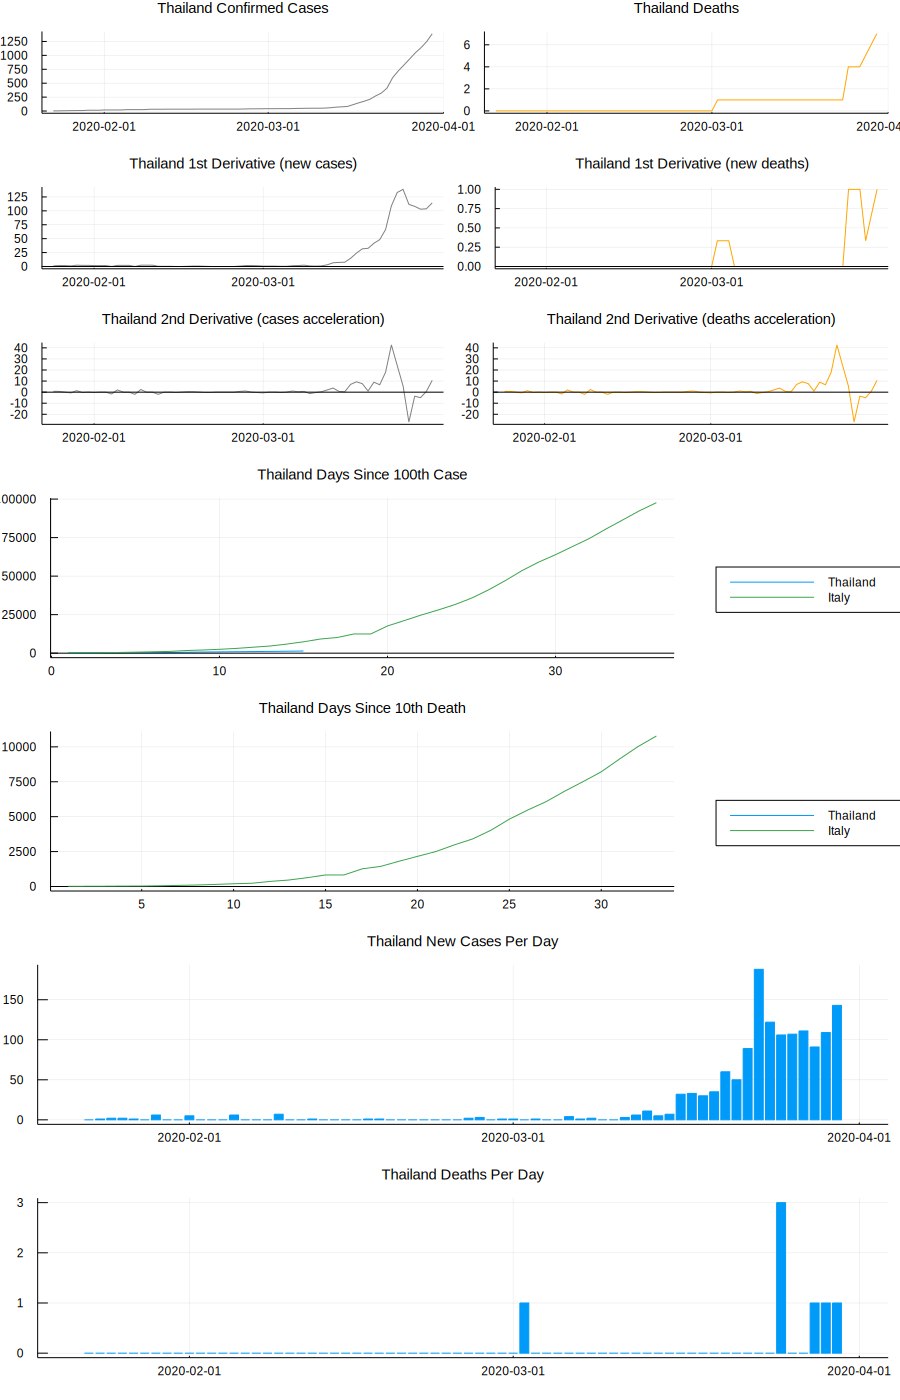

## Timor-Leste


  * Confirmed cases: 1
  * Deaths: 0
  * Death Rate: 0.0%


## Togo


  * Confirmed cases: 25
  * Deaths: 1
  * Death Rate: 4.0%


## Trinidad and Tobago


  * Confirmed cases: 78
  * Deaths: 3
  * Death Rate: 3.85%


## Tunisia


  * Confirmed cases: 312
  * Deaths: 8
  * Death Rate: 2.56%


## Turkey


  * Confirmed cases: 9217
  * Deaths: 131
  * Death Rate: 1.42%


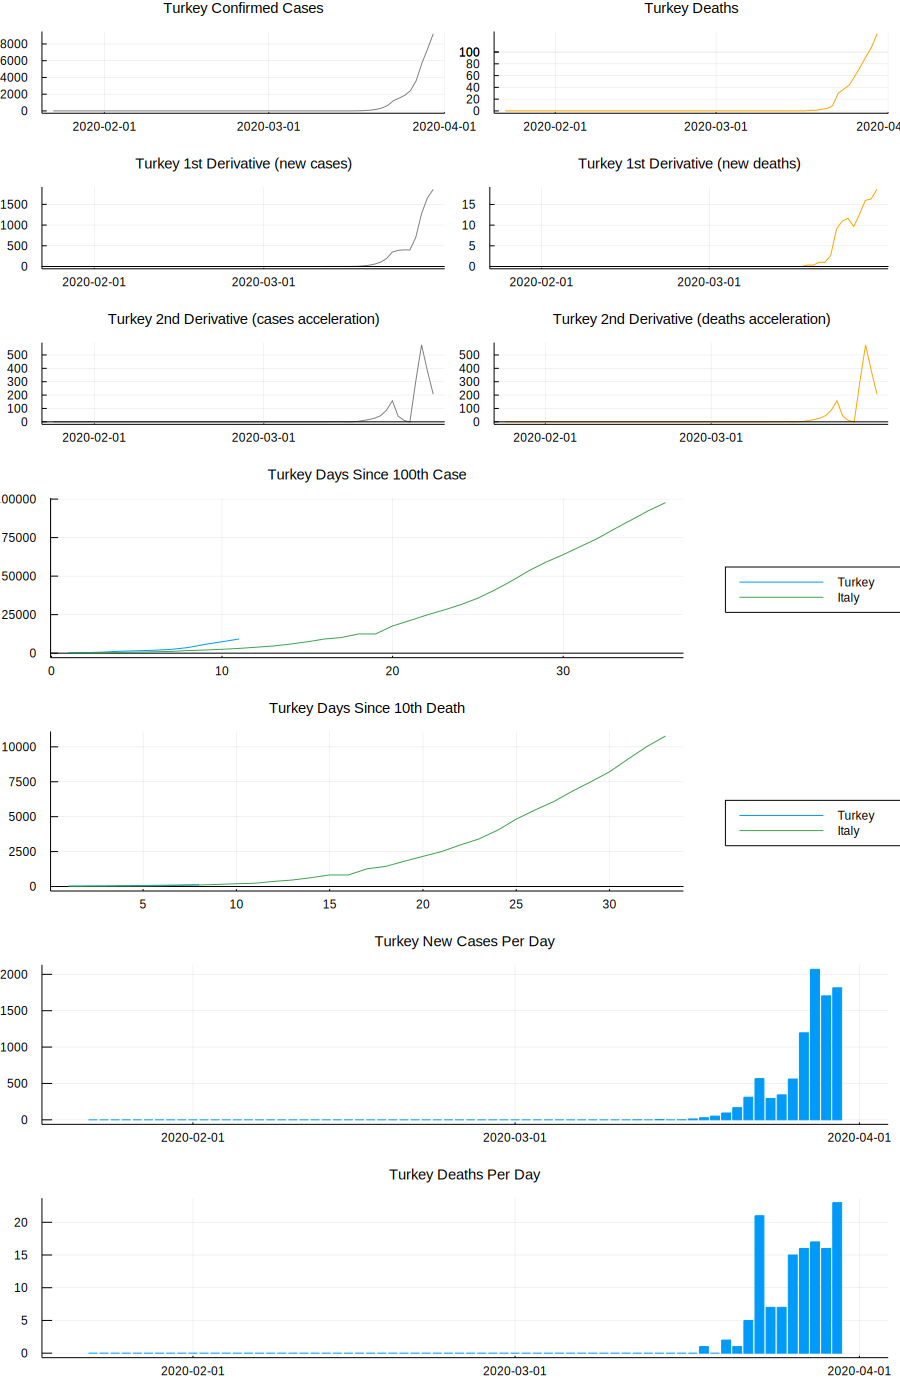

## US


  * Confirmed cases: 140886
  * Deaths: 2467
  * Death Rate: 1.75%


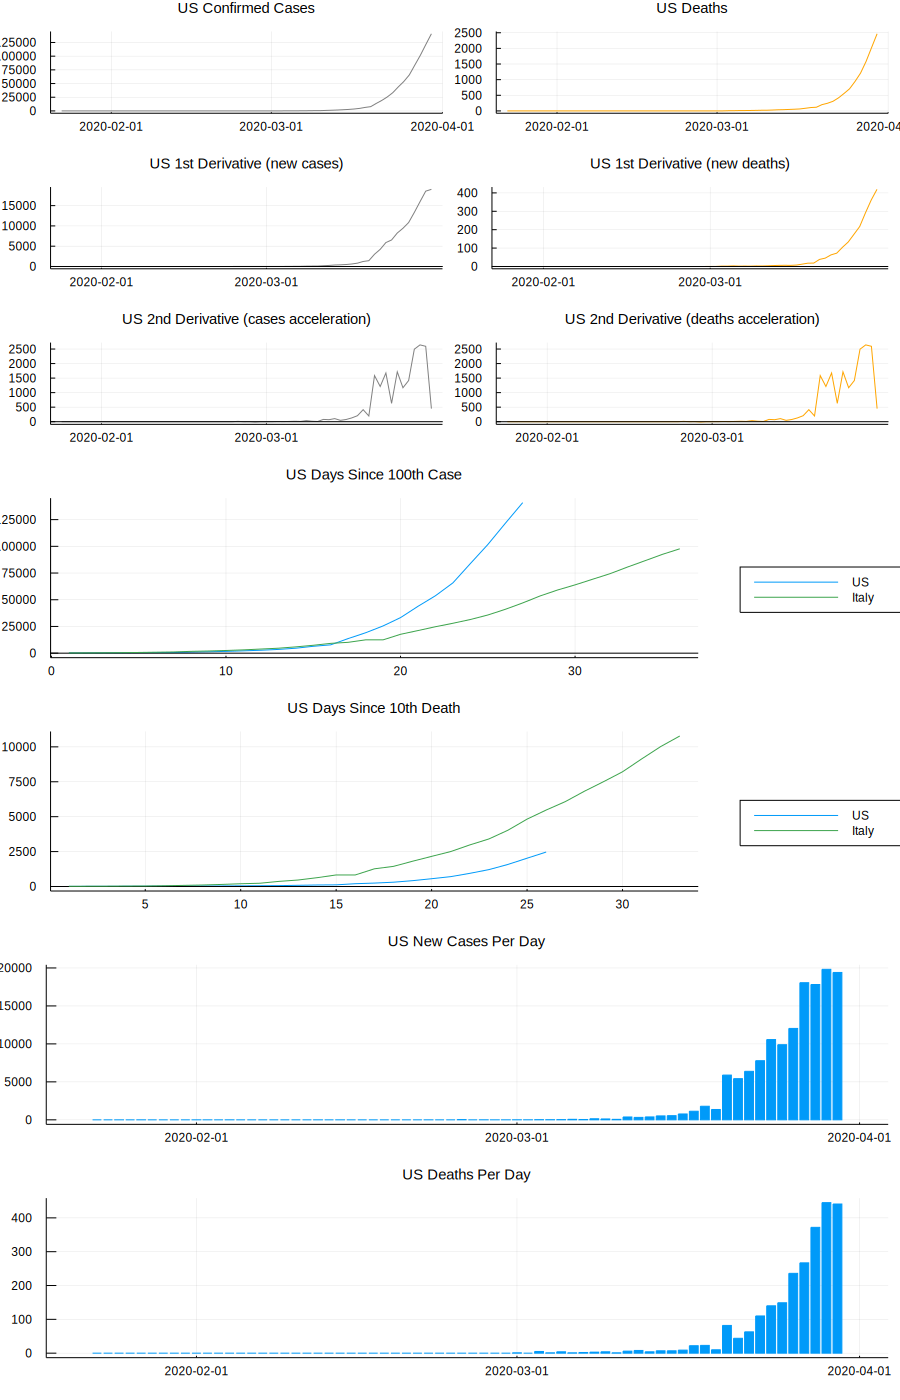

## Uganda


  * Confirmed cases: 33
  * Deaths: 0
  * Death Rate: 0.0%


## Ukraine


  * Confirmed cases: 475
  * Deaths: 10
  * Death Rate: 2.11%


## United Arab Emirates


  * Confirmed cases: 570
  * Deaths: 3
  * Death Rate: 0.53%


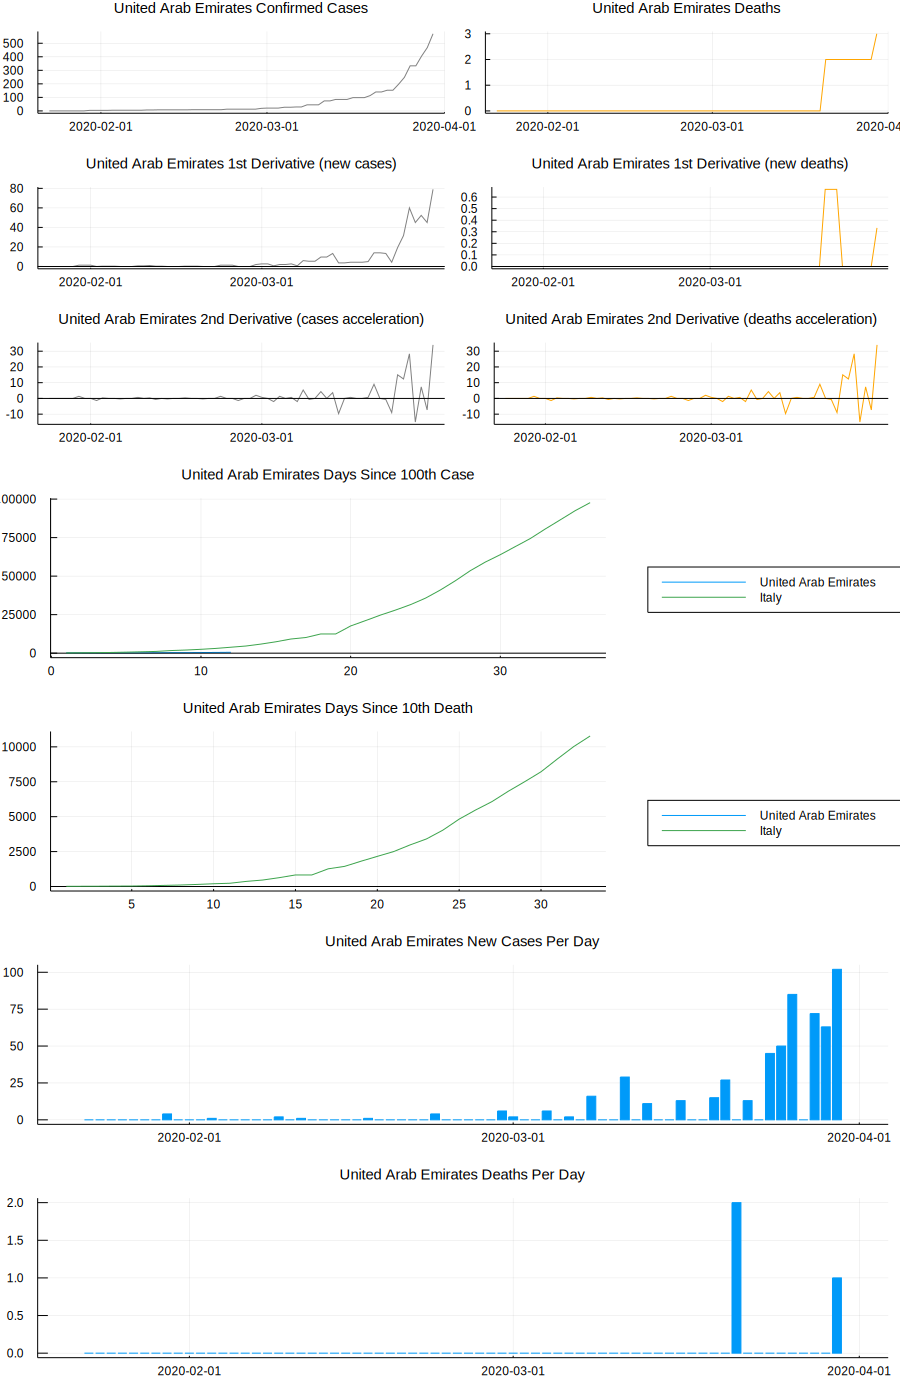

## United Kingdom


  * Confirmed cases: 19780
  * Deaths: 1231
  * Death Rate: 6.22%


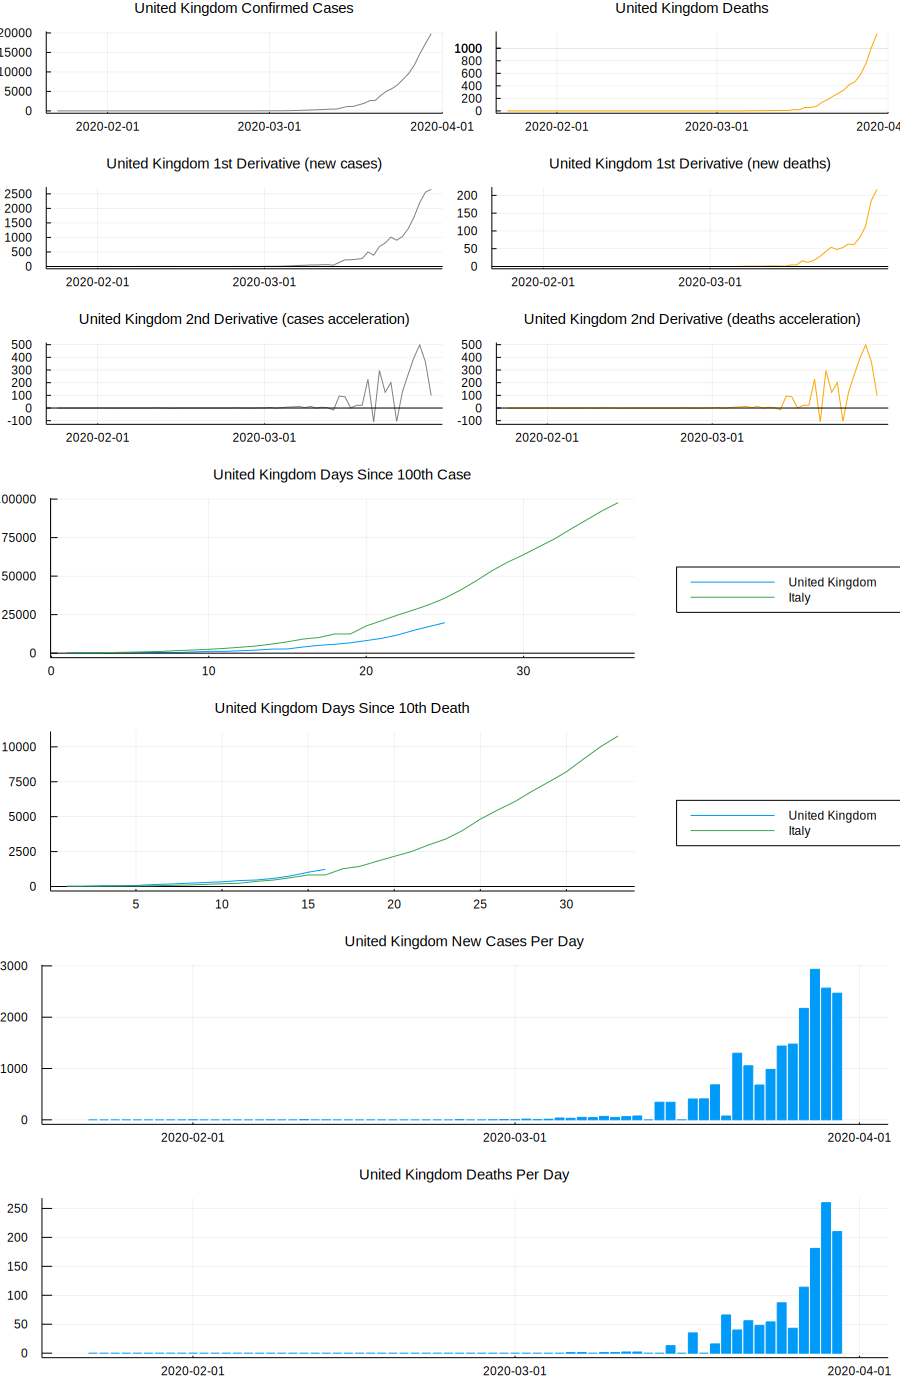

## Uruguay


  * Confirmed cases: 304
  * Deaths: 1
  * Death Rate: 0.33%


## Uzbekistan


  * Confirmed cases: 144
  * Deaths: 2
  * Death Rate: 1.39%


## Venezuela


  * Confirmed cases: 119
  * Deaths: 2
  * Death Rate: 1.68%


## Vietnam


  * Confirmed cases: 188
  * Deaths: 0
  * Death Rate: 0.0%


## West Bank and Gaza


  * Confirmed cases: 109
  * Deaths: 1
  * Death Rate: 0.92%


## Zambia


  * Confirmed cases: 29
  * Deaths: 0
  * Death Rate: 0.0%


## Zimbabwe


  * Confirmed cases: 7
  * Deaths: 1
  * Death Rate: 14.29%


In [14]:
for coun in all_countries
    data = country_data(coun)
    display(Markdown.parse("## $coun"))
    Markdown.parse("""
- Confirmed cases: $(maximum(data.confirmed))
- Deaths: $(maximum(data.deaths))
- Death Rate: $(round(maximum(data.deaths) / maximum(data.confirmed) * 100, digits=2))%
""") |> display
    if maximum(data.confirmed) >= 500 || coun == "Hungary"
        display(individual_country(coun))
    end
end